In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cat /proc/meminfo | grep MemTotal
!df -h /content
!cp "/content/drive/MyDrive/DM/basic.csv" /content/basic.csv
!cp "/content/drive/MyDrive/DM/vahc.csv" /content/vahc.csv
!cp "/content/drive/MyDrive/DM/extended.csv" /content/extended.csv



MemTotal:       13286956 kB
Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   22G   87G  20% /


In [ ]:
!cat /proc/meminfo | grep MemTotal
!df -h /content
!cp "/content/drive/MyDrive/DM/tens.csv" /content/tens.csv

MemTotal:       13286956 kB
Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   38G   70G  36% /


In [ ]:
!pip install -q duckdb pyarrow

In [ ]:
import duckdb,gc,sys, pandas as pd, numpy as np, matplotlib.pyplot as plt

In [ ]:
import duckdb,gc,sys, pandas as pd, numpy as np, matplotlib.pyplot as plt
basic_csv = '/content/basic.csv'
#vahc_csv  = '/content/vahc.csv'
ext_csv='/content/extended.csv'
tens_csv = '/content/tens.csv'


#EDA

In [ ]:
def combine_csvs_by_row_simple(basic_csv, ext_csv, vahc_csv,
                               basic_keep=None, ext_keep=None, vahc_keep=None,
                               verbose=True):

    con = duckdb.connect(database=':memory:')
    try:
        if basic_keep is None:
            basic_keep = ['id','Mvir','Rvir','rs','vrms','x','y','z','vx','vy','vz','Mpeak','Vpeak','b1']
        if ext_keep is None:
            ext_keep = ['Orig_halo_ID','Spin','Spin_Bullock','b_to_a','c_to_a','Xoff','Voff','Acc_Rate_Inst','Acc_Rate_100Myr','Jx','Jy','Jz']
        if vahc_keep is None:
            vahc_keep = ['haloID','lam1_R4R200b','lam2_R4R200b','lam3_R4R200b','lam1_R2R200b','lam3_R2R200b']

        def q(name):
            return '"' + name.replace('"','""') + '"'
        basic_cols_cte = ", ".join([q(c) for c in basic_keep])
        ext_cols_cte   = ", ".join([q(c) for c in ext_keep])
        vahc_cols_cte  =", ".join([q(c) for c in vahc_keep])
        basic_cols_outer= ", ".join([f"b.{q(c)}" for c in basic_keep])
        ext_cols_outer  = ", ".join([f"e.{q(c)}" for c in ext_keep])
        vahc_cols_outer= ", ".join([f"v.{q(c)}" for c in vahc_keep])
        sql = f"""
        WITH
          basic AS (
             SELECT {basic_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{basic_csv}')
          ),
          ext AS (
             SELECT {ext_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{ext_csv}')
          ),
          vahc AS (
             SELECT {vahc_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{vahc_csv}')
          )
        SELECT
          {basic_cols_outer},
          {ext_cols_outer},
          {vahc_cols_outer}
        FROM basic b
        LEFT JOIN ext   e ON b.rn = e.rn
        LEFT JOIN vahc  v ON b.rn = v.rn
        ;
        """

        if verbose:
            print("Running DuckDB query to load selected columns and join by row number...")
        df = con.execute(sql).df()

        if verbose:
            print("Loaded shape:", df.shape)
            print("Columns:", df.columns.tolist())

        return df

    finally:
        try:
            con.close()
        except:
            pass
        gc.collect()

df = combine_csvs_by_row_simple('basic.csv', 'extended.csv', 'vahc.csv', verbose=True)


Running DuckDB query to load selected columns and join by row number...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
df.head()

id          Mvir      Rvir        rs     vrms         x         y  \
0  1310204287  3.690000e+14  1455.176   347.786  1205.54  32.51410  18.76534   
1  1310192416  3.637000e+14  1448.118  1121.843  1140.66  32.83216  34.71375   
2  1310193415  2.640000e+14  1301.423   408.964  1092.24  33.51439  35.39557   
3  1310219719  1.669000e+14  1117.072   239.855  1015.97  30.73376  26.87315   
4  1310214330  1.621000e+14  1106.100   112.604   971.01  11.01126  19.40722   

          z      vx      vy  ...      Xoff    Voff  Acc_Rate_Inst  \
0  34.81572  -12.91  408.24  ...  149.4810  242.88        69560.0   
1  28.81610  449.72    4.82  ...  300.8370  366.86       215000.0   
2  27.85350 -281.37 -313.82  ...  217.1460  599.61        46980.0   
3  33.39271  -74.96 -173.40  ...   97.9649  418.01         9938.0   
4   1.10470  200.55  -42.51  ...   18.9992   29.37         8131.0   

   Acc_Rate_100Myr      haloID  lam1_R4R200b  lam2_R4R200b  lam3_R4R200b  \
0          69560.0  1310204287      3.771847      4.403918      5.291896   
1         215000.0  1310192416      3.456567      4.418976      5.875593   
2          46980.0  1310193415      5.623648      6.870534      8.379129   
3           9938.0  1310219719      1.349161      5.699795      7.524177   
4           8131.0  1310214330      3.966265      5.650493      6.916995   

   lam1_R2R200b  lam3_R2R200b  
0     21.157839     26.283495  
1     17.634478     28.191383  
2     29.079180     43.500343  
3     18.848068     30.927004  
4     20.047516     33.209780  

[5 rows x 29 columns]

In [ ]:
df.columns

Index(['id', 'Mvir', 'Rvir', 'rs', 'vrms', 'x', 'y', 'z', 'vx', 'vy', 'vz',
       'Mpeak', 'Vpeak', 'b1', 'Orig_halo_ID', 'Spin', 'Spin_Bullock',
       'b_to_a', 'c_to_a', 'Xoff', 'Voff', 'Acc_Rate_Inst', 'Acc_Rate_100Myr',
       'haloID', 'lam1_R4R200b', 'lam2_R4R200b', 'lam3_R4R200b',
       'lam1_R2R200b', 'lam3_R2R200b'],
      dtype='object')

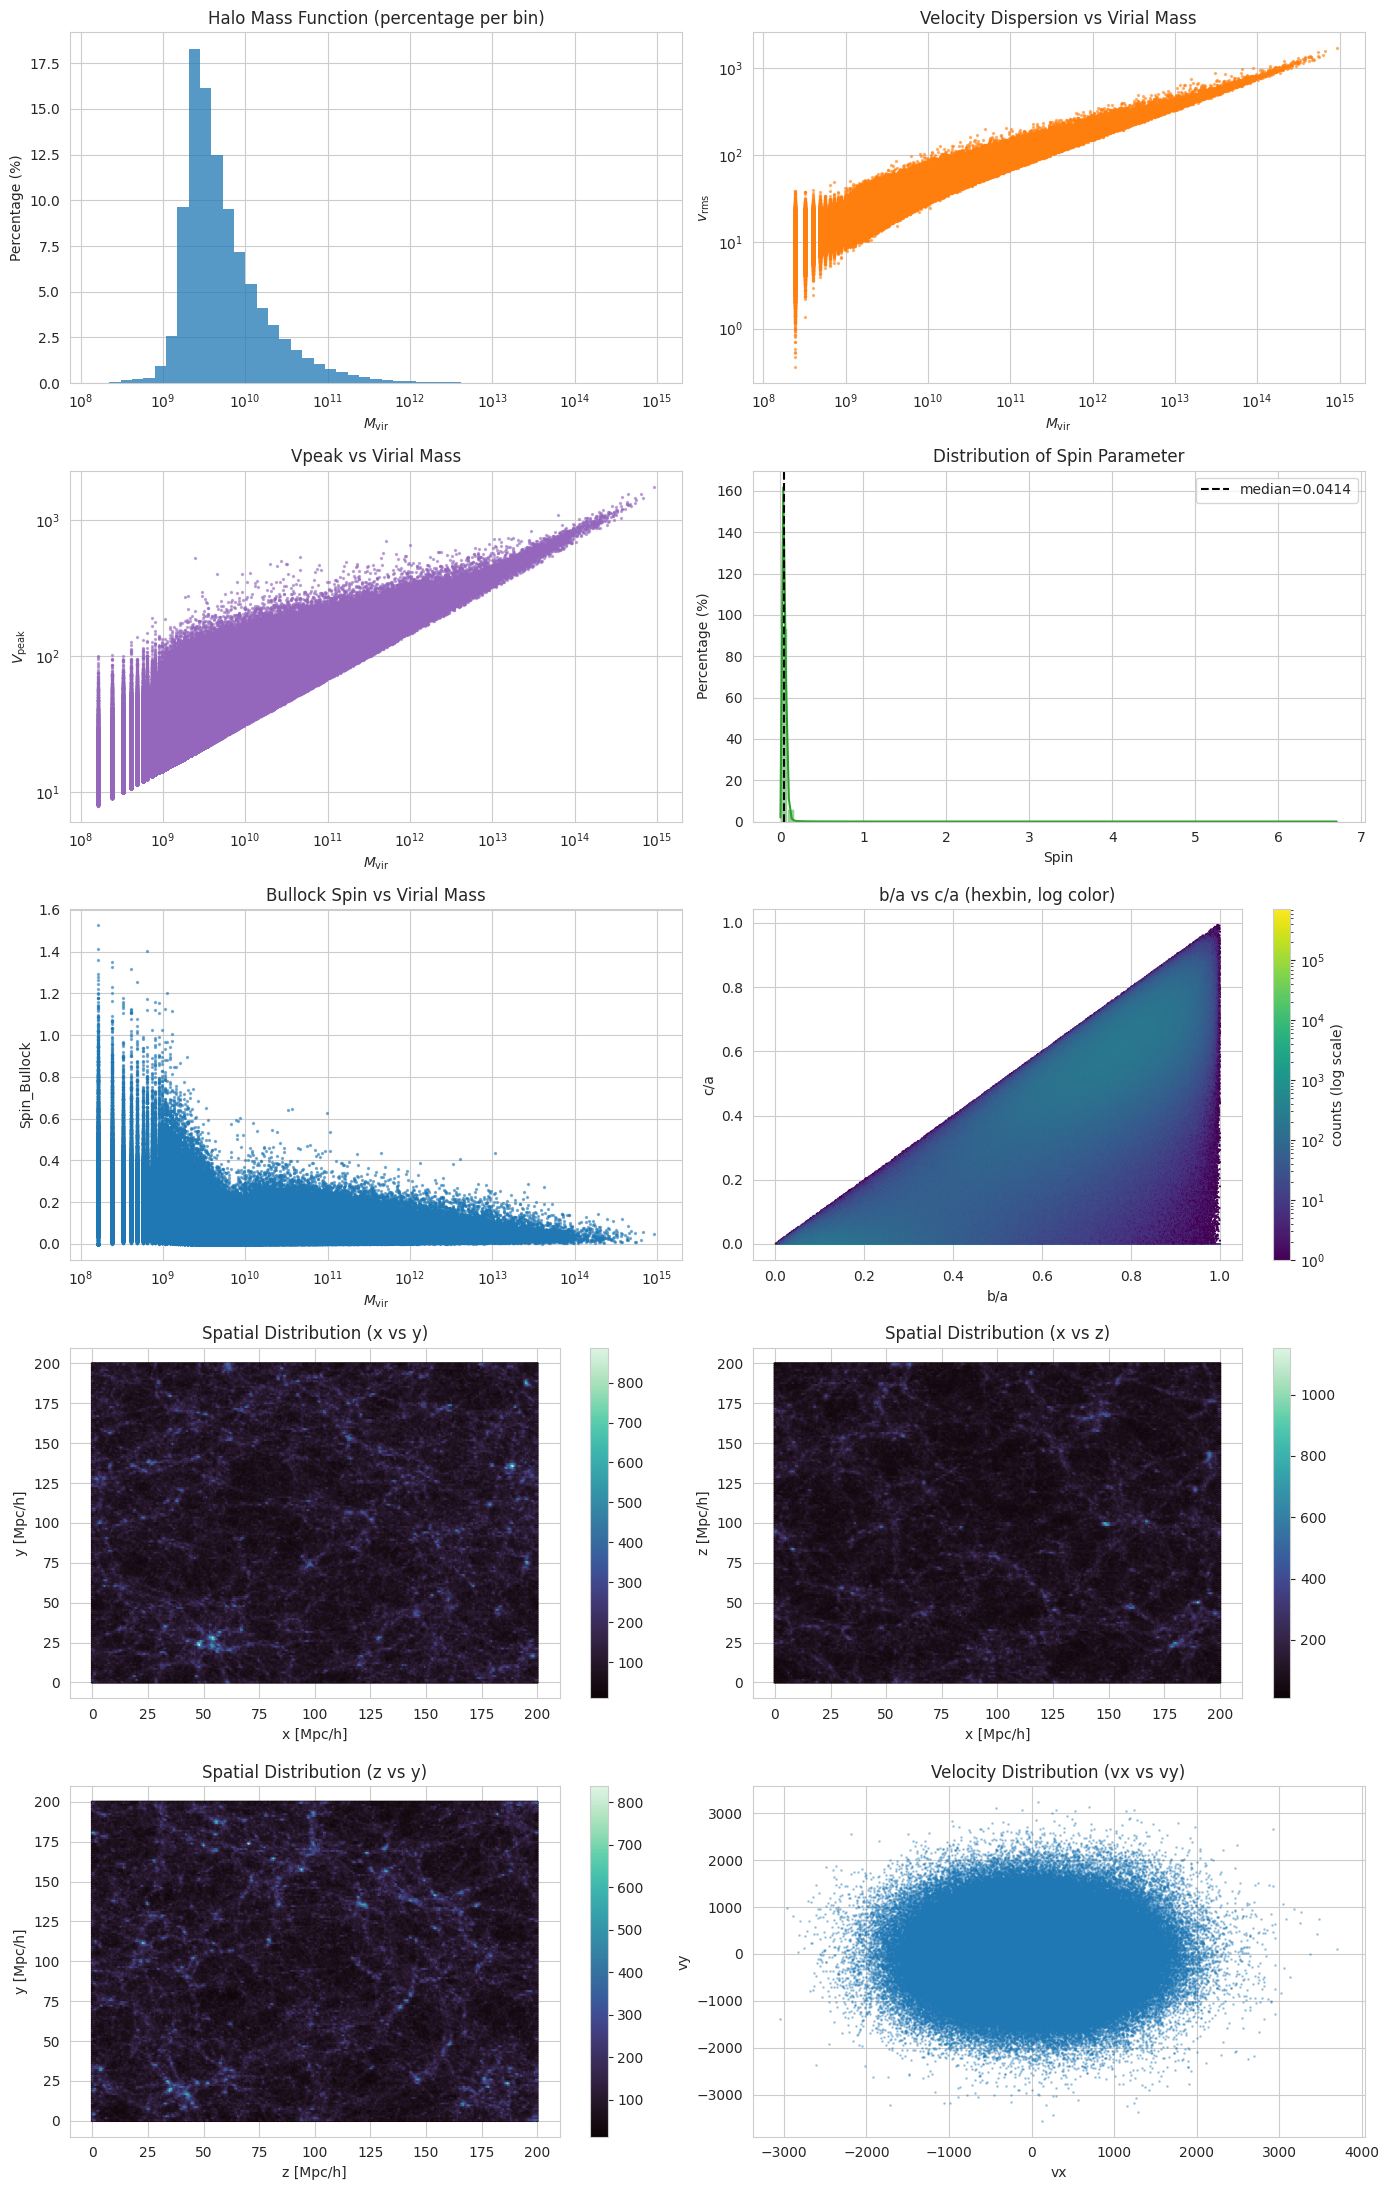

In [ ]:
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('whitegrid')
def plot(df):
    D = df
    fig, axes = plt.subplots(5, 2, figsize=(14, 22))
    axes = axes.flatten()

    #1)Mass function (percentage)
    masses = D['Mvir'].dropna().values
    bins = np.logspace(np.log10(masses.min()), np.log10(masses.max()), 50)
    sns.histplot(masses, bins=bins, stat='percent', ax=axes[0])
    axes[0].set_xscale('log')
    axes[0].set_xlabel(r"$M_{\rm vir}$"); axes[0].set_ylabel("Percentage (%)")
    axes[0].set_title("Halo Mass Function (percentage per bin)")
    #2)vrms vs Mvir
    axes[1].scatter(D['Mvir'], D['vrms'], s=2, alpha=0.5, c="tab:orange")
    axes[1].set_xscale("log"); axes[1].set_yscale("log")
    axes[1].set_xlabel(r"$M_{\rm vir}$"); axes[1].set_ylabel(r"$v_{\rm rms}$")
    axes[1].set_title("Velocity Dispersion vs Virial Mass")
    #3)Vpeak vs Mvir
    axes[2].scatter(D['Mvir'], D['Vpeak'], s=2, alpha=0.5, c="tab:purple")
    axes[2].set_xscale("log"); axes[2].set_yscale("log")
    axes[2].set_xlabel(r"$M_{\rm vir}$"); axes[2].set_ylabel(r"$V_{\rm peak}$")
    axes[2].set_title("Vpeak vs Virial Mass")
    #4)Spin histogram (percent)
    sns.histplot(D['Spin'].dropna(), bins=80, kde=True, stat='percent', color='tab:green', ax=axes[3])
    axes[3].axvline(np.nanmedian(D['Spin'].dropna()), color='k', linestyle='--',
                    label=f"median={np.nanmedian(D['Spin'].dropna()):.3g}")
    axes[3].set_xlabel("Spin"); axes[3].set_ylabel("Percentage (%)")
    axes[3].set_title("Distribution of Spin Parameter")
    axes[3].legend()
    #5)Bullock spin vs Mass
    axes[4].scatter(D['Mvir'], D['Spin_Bullock'], s=2, alpha=0.5)
    axes[4].set_xscale('log')
    axes[4].set_xlabel(r"$M_{\rm vir}$"); axes[4].set_ylabel("Spin_Bullock")
    axes[4].set_title("Bullock Spin vs Virial Mass")
    #6)Axis ratios b/a vs c/a (hexbin, log color)
    hb = axes[5].hexbin(df['b_to_a'], df['c_to_a'], gridsize=500, mincnt=1,
                        cmap='viridis', norm=LogNorm())
    fig.colorbar(hb, ax=axes[5], label='counts (log scale)')
    axes[5].set_xlabel('b/a'); axes[5].set_ylabel('c/a')
    axes[5].set_title('b/a vs c/a (hexbin, log color)')
    #7)Spatial (x vs y)
    pts = D[['x','y']].dropna().values
    hb2 = axes[6].hexbin(pts[:,0], pts[:,1], gridsize=300, cmap='mako', mincnt=1)
    fig.colorbar(hb2, ax=axes[6])
    axes[6].set_xlabel('x [Mpc/h]'); axes[6].set_ylabel('y [Mpc/h]')
    axes[6].set_title('Spatial Distribution (x vs y)')
    #8)Spatial (x vs z)
    pts = D[['x','z']].dropna().values
    hb3 = axes[7].hexbin(pts[:,0], pts[:,1], gridsize=300, cmap='mako', mincnt=1)
    fig.colorbar(hb3, ax=axes[7])
    axes[7].set_xlabel('x [Mpc/h]'); axes[7].set_ylabel('z [Mpc/h]')
    axes[7].set_title('Spatial Distribution (x vs z)')
    #9)Spatial (z vs y)
    pts=D[['z','y']].dropna().values
    hb4=axes[8].hexbin(pts[:,0], pts[:,1], gridsize=300, cmap='mako', mincnt=1)
    fig.colorbar(hb4, ax=axes[8])
    axes[8].set_xlabel('z [Mpc/h]'); axes[8].set_ylabel('y [Mpc/h]')
    axes[8].set_title('Spatial Distribution (z vs y)')
    #10)Velocity scatter (vx vs vy)
    sel = D[['vx','vy']].dropna()
    axes[9].scatter(sel['vx'], sel['vy'], s=1, alpha=0.3)
    axes[9].set_xlabel('vx'); axes[9].set_ylabel('vy')
    axes[9].set_title('Velocity Distribution (vx vs vy)')

    plt.tight_layout()
    plt.show()
plot(df)


# Reproducing Sujatha et. al. 2019

In [ ]:
nbins=10
bins_to_do=[0,1,2,3,4,5,6,7,8,9]
basic_keep =['Mvir','Rvir','rs','b1']
vahc_keep  =['lam1_R4R200b','lam2_R4R200b','lam3_R4R200b']
ext_keep   =['Jx','Jy','Jz','Spin','Spin_Bullock','b_to_a','c_to_a']
con = duckdb.connect()
def q(name):
    return '"' + name.replace('"','""') + '"'

basic_cols_cte= ', '.join([q(c) for c in basic_keep])
vahc_cols_cte= ', '.join([q(c) for c in vahc_keep]) if vahc_keep else ''
ext_cols_cte= ', '.join([q(c) for c in ext_keep])  if ext_keep  else ''

minmax=con.execute(f"""
    SELECT MIN(LOG10({q('Mvir')}::DOUBLE)) AS minlog,
           MAX(LOG10({q('Mvir')}::DOUBLE)) AS maxlog
    FROM read_csv_auto('{basic_csv}')
""").fetchdf()
minlog=float(minmax.loc[0,'minlog'])
maxlog=float(minmax.loc[0,'maxlog'])

sql=f"""
WITH basic AS (
  SELECT {basic_cols_cte},
         LOG10({q('Mvir')}::DOUBLE) AS logMvir,
         ROW_NUMBER() OVER () AS rn
  FROM read_csv_auto('{basic_csv}')
),
vahc AS (
  SELECT {vahc_cols_cte}, ROW_NUMBER() OVER () AS rn
  FROM read_csv_auto('{vahc_csv}')
),
extended AS (
  SELECT {ext_cols_cte}, ROW_NUMBER() OVER () AS rn
  FROM read_csv_auto('{ext_csv}')
),
joined AS (
  SELECT
    b.{q('Mvir')}, b.{q('Rvir')}, b.{q('rs')}, b.{q('b1')}, b.logMvir
    { (', v.' + ', v.'.join([q(c) for c in vahc_keep])) if vahc_keep else '' }
    { (', e.' + ', e.'.join([q(c) for c in ext_keep]))  if ext_keep  else '' },
    CAST(
      LEAST(
        GREATEST(
          FLOOR( ((b.logMvir - {minlog}) / ({maxlog} - {minlog})) * {nbins} ),
          0
        ),
        {nbins}-1
      ) AS INTEGER
    ) AS mbin
  FROM basic b
  LEFT JOIN vahc v ON b.rn = v.rn
  LEFT JOIN extended e ON b.rn = e.rn
  WHERE b.{q('Mvir')} IS NOT NULL
)
SELECT *
FROM joined
WHERE mbin IN ({','.join(map(str,bins_to_do))});
"""
try:
    df = con.execute(sql).df()
except Exception as e:
    print("=== DuckDB error ===")
    print(e)
    print("\n--- SQL ---\n", sql)
    con.close()
    raise

con.close()

print("Loaded dataframe shape:", df.shape)
print("Columns:", df.columns.tolist())
con=duckdb.connect()
ct_basic=int(con.execute(f"SELECT COUNT(*) FROM read_csv_auto('{basic_csv}')").fetchdf().iloc[0,0])
ct_vahc=int(con.execute(f"SELECT COUNT(*) FROM read_csv_auto('{vahc_csv}')").fetchdf().iloc[0,0])
ct_ext= int(con.execute(f"SELECT COUNT(*) FROM read_csv_auto('{ext_csv}')").fetchdf().iloc[0,0])
con.close()
print("Counts (basic, vahc, ext):", ct_basic, ct_vahc, ct_ext)
print("Rows loaded into pandas:", len(df))
display(df.head())
display(df.tail())
gc.collect()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded dataframe shape: (10549241, 16)
Columns: ['Mvir', 'Rvir', 'rs', 'b1', 'logMvir', 'lam1_R4R200b', 'lam2_R4R200b', 'lam3_R4R200b', 'Jx', 'Jy', 'Jz', 'Spin', 'Spin_Bullock', 'b_to_a', 'c_to_a', 'mbin']


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Counts (basic, vahc, ext): 10549241 10549241 10549241
Rows loaded into pandas: 10549241


Mvir      Rvir        rs        b1    logMvir  lam1_R4R200b  \
0  3.690000e+14  1455.176   347.786  8.804691  14.567026      3.771847   
1  3.637000e+14  1448.118  1121.843  6.174762  14.560743      3.456567   
2  2.640000e+14  1301.423   408.964  6.028630  14.421604      5.623648   
3  1.669000e+14  1117.072   239.855  7.745976  14.222456      1.349161   
4  1.621000e+14  1106.100   112.604  4.474640  14.209783      3.966265   

   lam2_R4R200b  lam3_R4R200b            Jx            Jy            Jz  \
0      4.403918      5.291896 -1.593000e+15 -1.223000e+16  2.673000e+16   
1      4.418976      5.875593 -8.927000e+15  3.993000e+16 -6.612000e+15   
2      6.870534      8.379129  2.342000e+15  2.324000e+16  2.347000e+16   
3      5.699795      7.524177  1.450000e+14  3.183000e+15 -1.414000e+15   
4      5.650493      6.916995 -1.761000e+15  1.376000e+15  3.109000e+15   

      Spin  Spin_Bullock   b_to_a   c_to_a  mbin  
0  0.03065       0.03711  0.53878  0.37788     9  
1  0.03584       0.05355  0.82220  0.67789     9  
2  0.02989       0.07296  0.40686  0.28477     9  
3  0.01158       0.01649  0.35997  0.30630     8  
4  0.01924       0.01903  0.83051  0.49211     8

Mvir    Rvir     rs        b1   logMvir  lam1_R4R200b  \
10549236  162200000.0  11.064  2.341 -5.772792  8.210051           0.0   
10549237  162200000.0  11.064  1.324 -4.723429  8.210051           0.0   
10549238  162200000.0  11.064  1.350 -5.282835  8.210051           0.0   
10549239  162200000.0  11.064  3.686 -3.613937  8.210051           0.0   
10549240  162200000.0  11.064  3.304 -4.801786  8.210051           0.0   

          lam2_R4R200b  lam3_R4R200b         Jx          Jy          Jz  \
10549236           0.0           0.0 -7503000.0  -3476000.0  -6273000.0   
10549237           0.0           0.0        0.0         0.0         0.0   
10549238           0.0           0.0        0.0         0.0         0.0   
10549239           0.0           0.0  -521000.0   1708000.0  -2834000.0   
10549240           0.0           0.0 -2717000.0  10090000.0 -10690000.0   

             Spin  Spin_Bullock  b_to_a  c_to_a  mbin  
10549236  0.82433       0.51517     0.0     0.0     0  
10549237  0.00000       0.00000     0.0     0.0     0  
10549238  0.00000       0.00000     0.0     0.0     0  
10549239  0.20073       0.16625     0.0     0.0     0  
10549240  1.35937       0.74207     0.0     0.0     0

2904

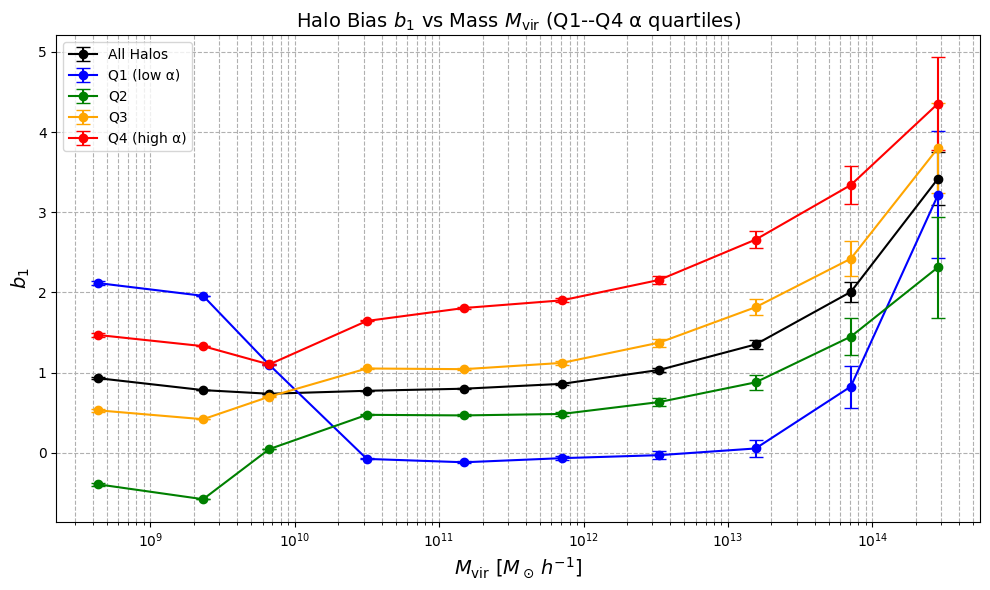

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

bin 0: total= 89962 halos; cleaned_for_sorting= 89962; quartiles -> Q1=22491, Q2=22491, Q3=22490, Q4=22490
   Q1: alpha_min = 0, alpha_max = 0
   Q2: alpha_min = 0, alpha_max = 0
   Q3: alpha_min = 0, alpha_max = 0
   Q4: alpha_min = 0, alpha_max = 0.709777

bin 1: total=4706881 halos; cleaned_for_sorting=4706881; quartiles -> Q1=1176721, Q2=1176720, Q3=1176720, Q4=1176720
   Q1: alpha_min = -27.565, alpha_max = 0
   Q2: alpha_min = 0, alpha_max = 0
   Q3: alpha_min = 0, alpha_max = 0
   Q4: alpha_min = 0, alpha_max = 3.85712

bin 2: total=4271456 halos; cleaned_for_sorting=4271456; quartiles -> Q1=1067864, Q2=1067864, Q3=1067864, Q4=1067864
   Q1: alpha_min = -786235, alpha_max = 0
   Q2: alpha_min = 0, alpha_max = 0
   Q3: alpha_min = 0, alpha_max = 0.476344
   Q4: alpha_min = 0.476344, alpha_max = 130384

bin 3: total=1108967 halos; clea

In [ ]:
def run_cell():
    df1 = df.copy()
    df1['logMvir'] = np.log10(df1['Mvir'].astype(float))
    df1['trace'] = df1['lam1_R4R200b'].astype(float) + df1['lam2_R4R200b'].astype(float) + df1['lam3_R4R200b'].astype(float)
    df1['q2'] = 0.5 * (
        (df1['lam1_R4R200b'] - df1['lam2_R4R200b'])**2 +
        (df1['lam1_R4R200b'] - df1['lam3_R4R200b'])**2 +
        (df1['lam2_R4R200b'] - df1['lam3_R4R200b'])**2
    )
    df1['delta'] = df1['trace']
    df1['alpha'] = np.sqrt(df1['q2']) / (1 + df1['delta'])
    grouped = df1.groupby('mbin')
    m_mean_all = (10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all = grouped['b1'].count()
    b1_sem_all = (grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()

    m_mean_all = m_mean_all.sort_index()
    b1_mean_all = b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all = b1_sem_all.reindex(m_mean_all.index)

    quartile_names = ['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q = {q: [] for q in quartile_names}
    b1_mean_q = {q: [] for q in quartile_names}
    b1_sem_q = {q: [] for q in quartile_names}
    mbin_list_for_plot = []
    counts_per_bin = {}
    alpha_range_per_bin = {}

    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin'] == mbin]
        n_bin = len(bin_df)

        if n_bin == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            alpha_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        clean = bin_df[['alpha','logMvir','b1']].replace([np.inf, -np.inf], np.nan).dropna(subset=['alpha']).copy()
        n_clean = len(clean)

        if n_clean == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            alpha_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        order = np.argsort(clean['alpha'].values, kind='stable')
        sorted_idx = clean.index.values[order]

        base = n_clean // 4
        rem = n_clean % 4
        sizes = [base + (1 if i < rem else 0) for i in range(4)]
        edges = np.cumsum([0] + sizes)

        q_masks = {}
        for i, qname in enumerate(quartile_names):
            lo, hi = edges[i], edges[i+1]
            sel_idx = sorted_idx[lo:hi]
            q_masks[qname] = bin_df.index.isin(sel_idx)

        counts_per_bin[mbin] = {q: int(q_masks[q].sum()) for q in quartile_names}
        alpha_range_per_bin[mbin] = {}
        for qname in quartile_names:
            qdf = bin_df[q_masks[qname]]
            if len(qdf) == 0:
                alpha_min, alpha_max = np.nan, np.nan
            else:
                a_clean = qdf['alpha'].replace([np.inf, -np.inf], np.nan).dropna()
                alpha_min = a_clean.min() if len(a_clean) else np.nan
                alpha_max = a_clean.max() if len(a_clean) else np.nan
            alpha_range_per_bin[mbin][qname] = (alpha_min, alpha_max)

        for qname in quartile_names:
            qdf = bin_df[q_masks[qname]]
            if len(qdf) == 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    plot_data = {}
    for q in quartile_names:
        xm, ym, em = [], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval = m_mean_q[q][i]
            bval = b1_mean_q[q][i]
            err = b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(x_all[i])
                ym.append(bval)
                em.append(err)
        plot_data[q] = (np.array(xm), np.array(ym), np.array(em))

    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    colors = {'Q1': 'blue', 'Q2': 'green', 'Q3': 'orange', 'Q4': 'red'}
    labels = {'Q1': 'Q1 (low α)', 'Q2': 'Q2', 'Q3': 'Q3', 'Q4': 'Q4 (high α)'}
    for q in quartile_names:
        xm, ym, em = plot_data[q]
        if len(xm) > 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])

    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ (Q1--Q4 α quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n_total = len(df1[df1['mbin'] == mbin])
        qcounts = counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\nbin {mbin}: total={n_total:6d} halos; cleaned_for_sorting={sum(qcounts.values()):6d}; "
              + "quartiles -> " + ", ".join([f"{q}={qcounts[q]:4d}" for q in quartile_names]))
        for q in quartile_names:
            amin, amax = alpha_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: alpha_min = {np.nan if np.isnan(amin) else format(amin, '.6g')}, "
                  f"alpha_max = {np.nan if np.isnan(amax) else format(amax, '.6g')}")

output = run_cell()

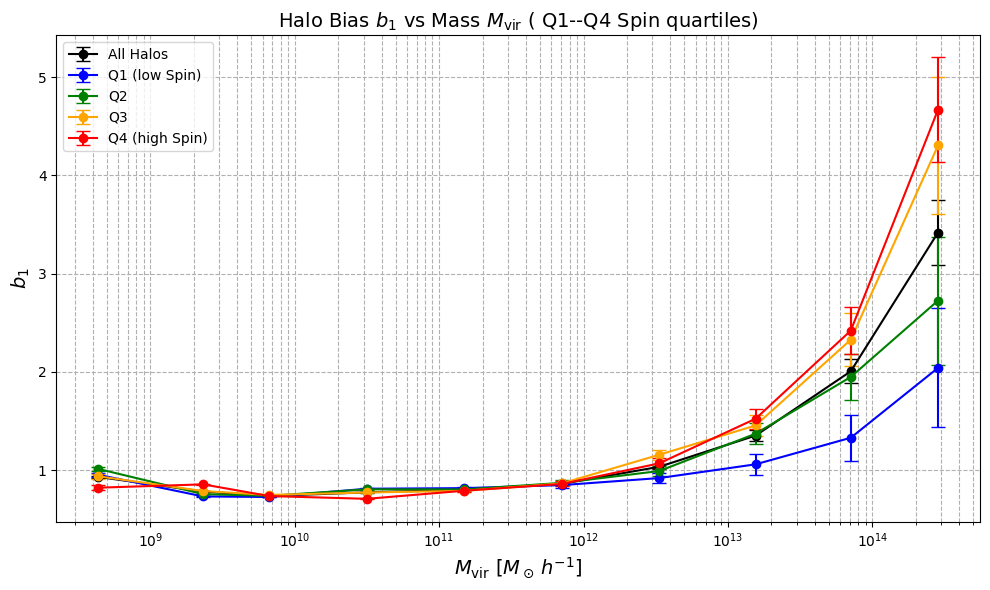

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

 bin 0: total=89962 halos; quartiles -> Q1=22496, Q2=22485, Q3=22490, Q4=22491
   Q1: Spin_min = 0, Spin_max = 0.03352
   Q2: Spin_min = 0.03353, Spin_max = 0.07678
   Q3: Spin_min = 0.07679, Spin_max = 0.20541
   Q4: Spin_min = 0.20542, Spin_max = 6.70428

 bin 1: total=4706881 halos; quartiles -> Q1=1177157, Q2=1177065, Q3=1175998, Q4=1176661
   Q1: Spin_min = 5e-05, Spin_max = 0.03043
   Q2: Spin_min = 0.03044, Spin_max = 0.0445
   Q3: Spin_min = 0.04451, Spin_max = 0.0613
   Q4: Spin_min = 0.06131, Spin_max = 3.71418

 bin 2: total=4271456 halos; quartiles -> Q1=1068193, Q2=1068212, Q3=1067557, Q4=1067494
   Q1: Spin_min = 0.00013, Spin_max = 0.02762
   Q2: Spin_min = 0.02763, Spin_max = 0.03983
   Q3: Spin_min = 0.03984, Spin_max = 0.05482
   Q4: Spin_min = 0.05483, Spin_max = 0.96052

 bin 3: total=1108967 halos; quartiles -> Q1=27731

In [ ]:
def run_cell():
    df1=df.copy()
    grouped=df1.groupby('mbin')

    m_mean_all=(10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all=grouped['b1'].count()
    b1_sem_all =(grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all = m_mean_all.sort_index()
    b1_mean_all=b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all=b1_sem_all.reindex(m_mean_all.index)
    quartile_names=['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q={q: [] for q in quartile_names}
    b1_mean_q={q: [] for q in quartile_names}
    b1_sem_q ={q: [] for q in quartile_names}
    mbin_list_for_plot = []
    counts_per_bin ={}
    spin_range_per_bin= {}

    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin']==mbin]
        if len(bin_df)==0:
            counts_per_bin[mbin]={q: 0 for q in quartile_names}
            spin_range_per_bin[mbin]={q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        q1, q2, q3=np.quantile(bin_df['Spin'].values, [0.25, 0.5, 0.75])
        masks = {
            'Q1': bin_df['Spin'] <= q1,
            'Q2': (bin_df['Spin'] > q1) & (bin_df['Spin'] <= q2),
            'Q3': (bin_df['Spin'] > q2) & (bin_df['Spin'] <= q3),
            'Q4': bin_df['Spin'] > q3
        }
        counts_per_bin[mbin]={q: int(masks[q].sum()) for q in quartile_names}
        spin_range_per_bin[mbin]={}
        for qname in quartile_names:
            qdf = bin_df[masks[qname]]
            if len(qdf)==0:
                spin_min=np.nan
                spin_max=np.nan
            else:
                s_clean=qdf['Spin'].replace([np.inf, -np.inf], np.nan).dropna()
                if len(s_clean)==0:
                    spin_min=np.nan
                    spin_max = np.nan
                else:
                    spin_min=s_clean.min()
                    spin_max=s_clean.max()
            spin_range_per_bin[mbin][qname] = (spin_min, spin_max)

        for qname in quartile_names:
            qdf=bin_df[masks[qname]]
            if len(qdf) == 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    plot_data = {}
    for q in quartile_names:
        xm, ym, em = [], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval = m_mean_q[q][i]
            bval = b1_mean_q[q][i]
            err = b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(x_all[i])
                ym.append(bval)
                em.append(err)
        plot_data[q]=(np.array(xm), np.array(ym), np.array(em))

    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    colors={'Q1':'blue','Q2':'green','Q3':'orange','Q4':'red'}
    labels={'Q1':'Q1 (low Spin)', 'Q2':'Q2', 'Q3':'Q3', 'Q4':'Q4 (high Spin)'}
    for q in quartile_names:
        xm, ym, em = plot_data[q]
        if len(xm) > 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])
    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ ( Q1--Q4 Spin quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n=len(df1[df1['mbin']==mbin])
        qcounts = counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\n bin {mbin}: total={n:4d} halos; quartiles -> " +
              ", ".join([f"{q}={qcounts[q]:3d}" for q in quartile_names]))
        for q in quartile_names:
            smin, smax = spin_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: Spin_min = {np.nan if np.isnan(smin) else format(smin, '.6g')}, "
                  f"Spin_max = {np.nan if np.isnan(smax) else format(smax, '.6g')}")
    del df1
    gc.collect()

output = run_cell()

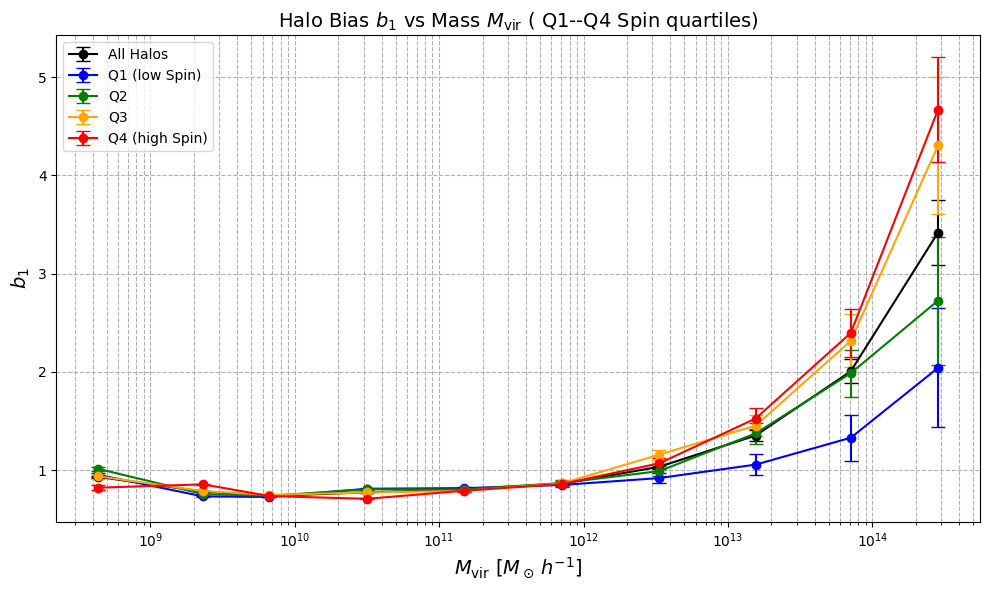

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

 bin 0: total=89962 halos; quartiles -> Q1=22491, Q2=22491, Q3=22490, Q4=22490
   Q1: Spin_min = 0, Spin_max = 0.03352
   Q2: Spin_min = 0.03352, Spin_max = 0.07679
   Q3: Spin_min = 0.0768, Spin_max = 0.20542
   Q4: Spin_min = 0.20544, Spin_max = 6.70428

 bin 1: total=4706881 halos; quartiles -> Q1=1176721, Q2=1176720, Q3=1176720, Q4=1176720
   Q1: Spin_min = 5e-05, Spin_max = 0.03043
   Q2: Spin_min = 0.03043, Spin_max = 0.0445
   Q3: Spin_min = 0.0445, Spin_max = 0.0613
   Q4: Spin_min = 0.0613, Spin_max = 3.71418

 bin 2: total=4271456 halos; quartiles -> Q1=1067864, Q2=1067864, Q3=1067864, Q4=1067864
   Q1: Spin_min = 0.00013, Spin_max = 0.02762
   Q2: Spin_min = 0.02762, Spin_max = 0.03983
   Q3: Spin_min = 0.03983, Spin_max = 0.05482
   Q4: Spin_min = 0.05482, Spin_max = 0.96052

 bin 3: total=1108967 halos; quartiles -> Q1=277242, 

In [ ]:
def run_cell():
    df1 = df.copy()
    grouped = df1.groupby('mbin')

    m_mean_all = (10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all = grouped['b1'].count()
    b1_sem_all = (grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all = m_mean_all.sort_index()
    b1_mean_all = b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all = b1_sem_all.reindex(m_mean_all.index)
    quartile_names = ['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q = {q: [] for q in quartile_names}
    b1_mean_q = {q: [] for q in quartile_names}
    b1_sem_q = {q: [] for q in quartile_names}
    mbin_list_for_plot = []
    counts_per_bin = {}
    spin_range_per_bin = {}

    # main modification here
    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin'] == mbin]
        if len(bin_df) == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            spin_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        clean = bin_df[['Spin', 'logMvir', 'b1']].replace([np.inf, -np.inf], np.nan).dropna(subset=['Spin']).copy()
        n_clean = len(clean)
        if n_clean == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            spin_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        order = np.argsort(clean['Spin'].values, kind='stable')
        sorted_idx = clean.index.values[order]

        base = n_clean // 4
        rem = n_clean % 4
        sizes = [base + (1 if i < rem else 0) for i in range(4)]
        edges = np.cumsum([0] + sizes)

        q_masks = {}
        for i, qname in enumerate(quartile_names):
            lo, hi = edges[i], edges[i + 1]
            sel_idx = sorted_idx[lo:hi]
            q_masks[qname] = clean.index.isin(sel_idx)

        counts_per_bin[mbin] = {q: int(q_masks[q].sum()) for q in quartile_names}
        spin_range_per_bin[mbin] = {}
        for qname in quartile_names:
            qdf = clean[q_masks[qname]]
            if len(qdf) == 0:
                spin_min, spin_max = np.nan, np.nan
            else:
                s_clean = qdf['Spin'].replace([np.inf, -np.inf], np.nan).dropna()
                spin_min = s_clean.min() if len(s_clean) else np.nan
                spin_max = s_clean.max() if len(s_clean) else np.nan
            spin_range_per_bin[mbin][qname] = (spin_min, spin_max)

        for qname in quartile_names:
            qdf = clean[q_masks[qname]]
            if len(qdf) == 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    plot_data = {}
    for q in quartile_names:
        xm, ym, em = [], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval = m_mean_q[q][i]
            bval = b1_mean_q[q][i]
            err = b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(x_all[i])
                ym.append(bval)
                em.append(err)
        plot_data[q] = (np.array(xm), np.array(ym), np.array(em))

    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    colors = {'Q1': 'blue', 'Q2': 'green', 'Q3': 'orange', 'Q4': 'red'}
    labels = {'Q1': 'Q1 (low Spin)', 'Q2': 'Q2', 'Q3': 'Q3', 'Q4': 'Q4 (high Spin)'}
    for q in quartile_names:
        xm, ym, em = plot_data[q]
        if len(xm) > 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])
    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ ( Q1--Q4 Spin quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n = len(df1[df1['mbin'] == mbin])
        qcounts = counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\n bin {mbin}: total={n:4d} halos; quartiles -> " +
              ", ".join([f"{q}={qcounts[q]:3d}" for q in quartile_names]))
        for q in quartile_names:
            smin, smax = spin_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: Spin_min = {np.nan if np.isnan(smin) else format(smin, '.6g')}, "
                  f"Spin_max = {np.nan if np.isnan(smax) else format(smax, '.6g')}")
    del df1
    gc.collect()

output = run_cell()


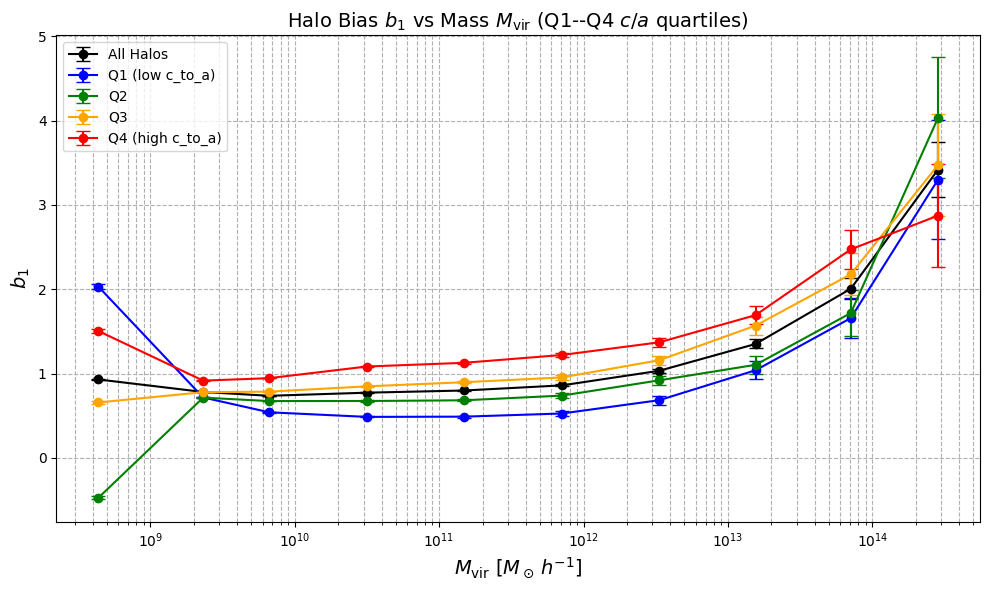

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

bin 0: total= 89962 halos; cleaned_for_sorting= 89962; quartiles -> Q1=22491, Q2=22491, Q3=22490, Q4=22490
   Q1: c_to_a_min = 0, c_to_a_max = 0
   Q2: c_to_a_min = 0, c_to_a_max = 0
   Q3: c_to_a_min = 0, c_to_a_max = 0
   Q4: c_to_a_min = 0, c_to_a_max = 0.84861

bin 1: total=4706881 halos; cleaned_for_sorting=4706881; quartiles -> Q1=1176721, Q2=1176720, Q3=1176720, Q4=1176720
   Q1: c_to_a_min = 0, c_to_a_max = 0.02547
   Q2: c_to_a_min = 0.02547, c_to_a_max = 0.17922
   Q3: c_to_a_min = 0.17922, c_to_a_max = 0.39184
   Q4: c_to_a_min = 0.39184, c_to_a_max = 0.98413

bin 2: total=4271456 halos; cleaned_for_sorting=4271456; quartiles -> Q1=1067864, Q2=1067864, Q3=1067864, Q4=1067864
   Q1: c_to_a_min = 0, c_to_a_max = 0.37002
   Q2: c_to_a_min = 0.37002, c_to_a_max = 0.50989
   Q3: c_to_a_min = 0.50989, c_to_a_max = 0.62613
   Q4: c_to_a

In [ ]:
def run_cell():
    df1=df.copy()
    df1['logMvir']=np.log10(df1['Mvir'].astype(float))
    df1['trace']=df1['lam1_R4R200b'].astype(float) + df1['lam2_R4R200b'].astype(float) + df1['lam3_R4R200b'].astype(float)
    df1['q2']=0.5 * (
        (df1['lam1_R4R200b'] - df1['lam2_R4R200b'])**2 +
        (df1['lam1_R4R200b'] - df1['lam3_R4R200b'])**2 +
        (df1['lam2_R4R200b'] - df1['lam3_R4R200b'])**2
    )
    df1['delta'] =df1['trace']
    df1['alpha'] = np.sqrt(df1['q2']) / (1 + df1['delta'])
    grouped = df1.groupby('mbin')
    m_mean_all =(10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all= grouped['b1'].mean().dropna()
    b1_count_all= grouped['b1'].count()
    b1_sem_all=(grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all =m_mean_all.sort_index()
    b1_mean_all=b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all= b1_sem_all.reindex(m_mean_all.index)
    quartile_names =['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q ={q: [] for q in quartile_names}
    b1_mean_q= {q: [] for q in quartile_names}
    b1_sem_q = {q: [] for q in quartile_names}
    mbin_list_for_plot =[]
    counts_per_bin ={}
    c_to_a_range_per_bin= {}
    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin'] == mbin]
        n_bin = len(bin_df)

        if n_bin == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            c_to_a_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue
        clean=bin_df[['c_to_a', 'logMvir', 'b1']].replace([np.inf, -np.inf], np.nan).dropna(subset=['c_to_a']).copy()
        n_clean=len(clean)
        if n_clean== 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            c_to_a_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        order=np.argsort(clean['c_to_a'].values, kind='stable')
        sorted_idx=clean.index.values[order]


        base=n_clean // 4
        rem=n_clean % 4
        sizes=[base + (1 if i < rem else 0) for i in range(4)]
        edges=np.cumsum([0] + sizes)

        q_masks ={}
        for i, qname in enumerate(quartile_names):
            lo, hi= edges[i], edges[i+1]
            sel_idx= sorted_idx[lo:hi]
            q_masks[qname]= bin_df.index.isin(sel_idx)
        counts_per_bin[mbin]={q: int(q_masks[q].sum()) for q in quartile_names}
        c_to_a_range_per_bin[mbin] = {}
        for qname in quartile_names:
            qdf=bin_df[q_masks[qname]]
            if len(qdf)==0:
                cmin, cmax=np.nan, np.nan
            else:
                cleanvals =qdf['c_to_a'].replace([np.inf, -np.inf], np.nan).dropna()
                cmin =cleanvals.min() if len(cleanvals) else np.nan
                cmax =cleanvals.max() if len(cleanvals) else np.nan
            c_to_a_range_per_bin[mbin][qname]=(cmin, cmax)

        for qname in quartile_names:
            qdf=bin_df[q_masks[qname]]
            if len(qdf)== 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))
    plot_data={}
    x_all =m_mean_all.loc[mbin_list_for_plot].values
    y_all= b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all=b1_sem_all.loc[mbin_list_for_plot].values
    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    for q in quartile_names:
        xm, ym, em=[], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval=m_mean_q[q][i]
            bval=b1_mean_q[q][i]
            err =b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(x_all[i])
                ym.append(bval)
                em.append(err)
        plot_data[q] =(np.array(xm), np.array(ym), np.array(em))

    colors ={'Q1': 'blue', 'Q2': 'green', 'Q3': 'orange', 'Q4': 'red'}
    labels ={'Q1': 'Q1 (low c_to_a)', 'Q2': 'Q2', 'Q3': 'Q3', 'Q4': 'Q4 (high c_to_a)'}
    for q in quartile_names:
        xm, ym, em= plot_data[q]
        if len(xm)> 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])

    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ (Q1--Q4 $c/a$ quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n_total =len(df1[df1['mbin'] == mbin])
        qcounts =counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\nbin {mbin}: total={n_total:6d} halos; cleaned_for_sorting={sum(qcounts.values()):6d}; "
              + "quartiles -> " + ", ".join([f"{q}={qcounts[q]:4d}" for q in quartile_names]))
        for q in quartile_names:
            cmin, cmax = c_to_a_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: c_to_a_min = {np.nan if np.isnan(cmin) else format(cmin, '.6g')}, "
                  f"c_to_a_max = {np.nan if np.isnan(cmax) else format(cmax, '.6g')}")
    del df1
    gc.collect()
output=run_cell()


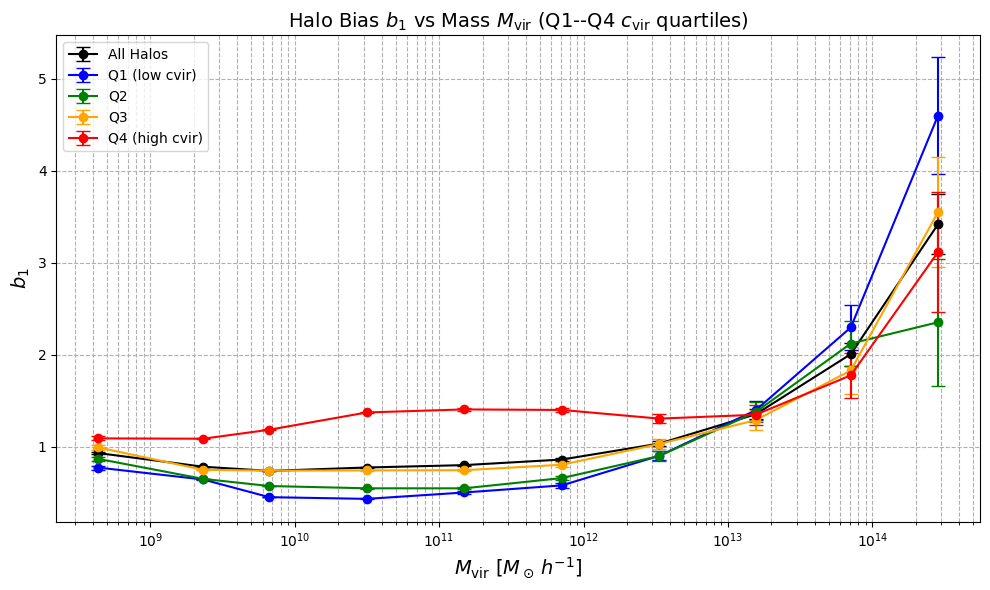

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

bin 0: total= 89962 halos; cleaned_for_sorting= 89962; quartiles -> Q1=22491, Q2=22491, Q3=22490, Q4=22490
   Q1: cvir_min = 2.17, cvir_max = 3.57163
   Q2: cvir_min = 3.57169, cvir_max = 4.75247
   Q3: cvir_min = 4.75258, cvir_max = 6.89505
   Q4: cvir_min = 6.89517, cvir_max = 55.0207

bin 1: total=4706881 halos; cleaned_for_sorting=4706881; quartiles -> Q1=1176721, Q2=1176720, Q3=1176720, Q4=1176720
   Q1: cvir_min = 2.16255, cvir_max = 7.04106
   Q2: cvir_min = 7.04106, cvir_max = 11.1593
   Q3: cvir_min = 11.1593, cvir_max = 16.3302
   Q4: cvir_min = 16.3302, cvir_max = 131.078

bin 2: total=4271456 halos; cleaned_for_sorting=4271456; quartiles -> Q1=1067864, Q2=1067864, Q3=1067864, Q4=1067864
   Q1: cvir_min = 1.00359, cvir_max = 10.9398
   Q2: cvir_min = 10.9398, cvir_max = 14.9372
   Q3: cvir_min = 14.9372, cvir_max = 20.4109
   Q4:

In [ ]:
def run_cell():
    df1 = df.copy()
    df1['logMvir'] = np.log10(df1['Mvir'].astype(float))
    df1['cvir'] = df1['Rvir'].astype(float) / df1['rs'].astype(float)
    grouped = df1.groupby('mbin')

    m_mean_all = (10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all = grouped['b1'].count()
    b1_sem_all = (grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()

    m_mean_all = m_mean_all.sort_index()
    b1_mean_all = b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all = b1_sem_all.reindex(m_mean_all.index)

    quartile_names = ['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q = {q: [] for q in quartile_names}
    b1_mean_q = {q: [] for q in quartile_names}
    b1_sem_q = {q: [] for q in quartile_names}
    mbin_list_for_plot = []

    counts_per_bin = {}
    cvir_range_per_bin = {}

    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin'] == mbin]
        n_bin = len(bin_df)

        if n_bin == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            cvir_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        clean = bin_df[['cvir', 'logMvir', 'b1']].replace([np.inf, -np.inf], np.nan).dropna(subset=['cvir']).copy()
        n_clean = len(clean)

        if n_clean == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            cvir_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        order = np.argsort(clean['cvir'].values, kind='stable')
        sorted_idx = clean.index.values[order]

        base = n_clean // 4
        rem = n_clean % 4
        sizes = [base + (1 if i < rem else 0) for i in range(4)]
        edges = np.cumsum([0] + sizes)

        q_masks = {}
        for i, qname in enumerate(quartile_names):
            lo, hi = edges[i], edges[i+1]
            sel_idx = sorted_idx[lo:hi]
            q_masks[qname] = bin_df.index.isin(sel_idx)

        counts_per_bin[mbin] = {q: int(q_masks[q].sum()) for q in quartile_names}
        cvir_range_per_bin[mbin] = {}
        for qname in quartile_names:
            qdf = bin_df[q_masks[qname]]
            if len(qdf) == 0:
                cmin, cmax = np.nan, np.nan
            else:
                cleanvals = qdf['cvir'].replace([np.inf, -np.inf], np.nan).dropna()
                cmin = cleanvals.min() if len(cleanvals) else np.nan
                cmax = cleanvals.max() if len(cleanvals) else np.nan
            cvir_range_per_bin[mbin][qname] = (cmin, cmax)

        for qname in quartile_names:
            qdf = bin_df[q_masks[qname]]
            if len(qdf) == 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    plot_data = {}
    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    for q in quartile_names:
        xm, ym, em = [], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval = m_mean_q[q][i]
            bval = b1_mean_q[q][i]
            err = b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(x_all[i])
                ym.append(bval)
                em.append(err)
        plot_data[q] = (np.array(xm), np.array(ym), np.array(em))


    colors = {'Q1': 'blue', 'Q2': 'green', 'Q3': 'orange', 'Q4': 'red'}
    labels = {'Q1': 'Q1 (low cvir)', 'Q2': 'Q2', 'Q3': 'Q3', 'Q4': 'Q4 (high cvir)'}
    for q in quartile_names:
        xm, ym, em = plot_data[q]
        if len(xm) > 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])

    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ (Q1--Q4 $c_{\rm vir}$ quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n_total = len(df1[df1['mbin'] == mbin])
        qcounts = counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\nbin {mbin}: total={n_total:6d} halos; cleaned_for_sorting={sum(qcounts.values()):6d}; "
              + "quartiles -> " + ", ".join([f"{q}={qcounts[q]:4d}" for q in quartile_names]))
        for q in quartile_names:
            cmin, cmax = cvir_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: cvir_min = {np.nan if np.isnan(cmin) else format(cmin, '.6g')}, "
                  f"cvir_max = {np.nan if np.isnan(cmax) else format(cmax, '.6g')}")

    del df1
    gc.collect()

output = run_cell()

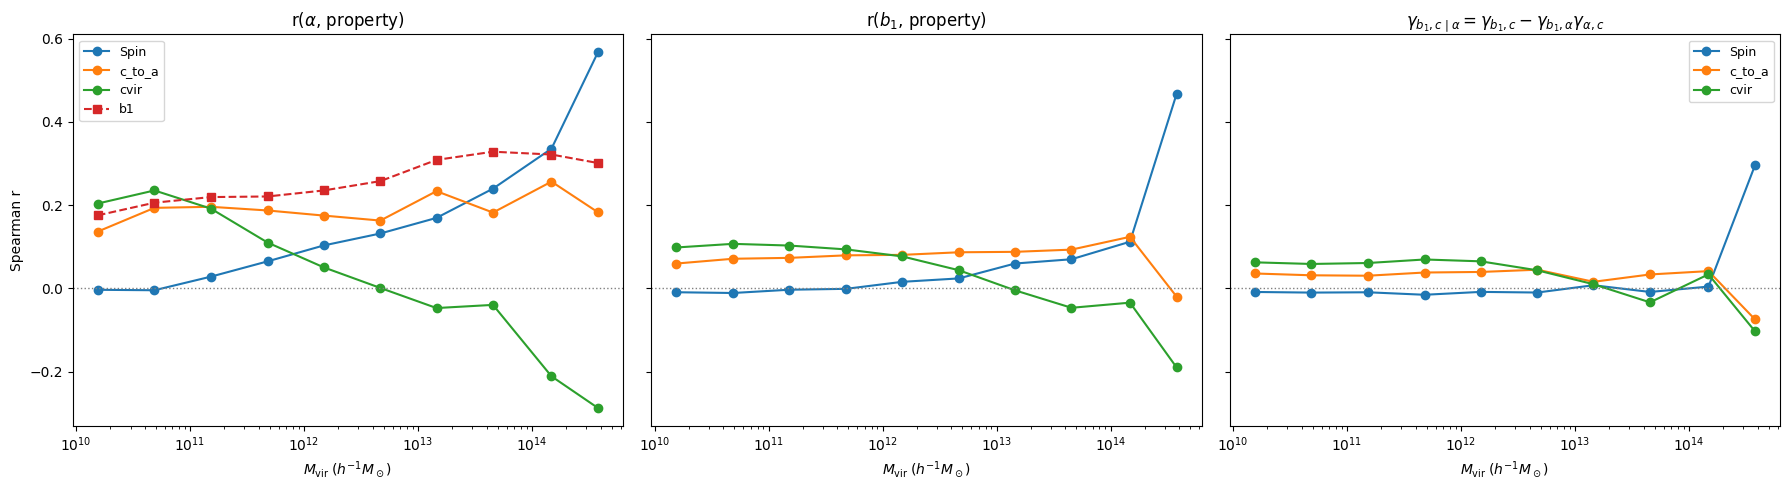

In [ ]:
def run_cell(min_n_for_stat=30, compute_normalized_partial=False):
    df1 =df.copy()

    if 'mbin' in df1.columns:
        df1= df1.drop(columns=['mbin'])
    df1['Mvir']= df1['Mvir'].astype(float)
    df1['logMvir']= np.log10(df1['Mvir'])

    df1['trace'] =df1['lam1_R4R200b'].astype(float) + df1['lam2_R4R200b'].astype(float) + df1['lam3_R4R200b'].astype(float)
    df1['q2'] =0.5 * (
        (df1['lam1_R4R200b'] - df1['lam2_R4R200b'])**2 +
        (df1['lam1_R4R200b'] - df1['lam3_R4R200b'])**2 +
        (df1['lam2_R4R200b'] - df1['lam3_R4R200b'])**2
    )
    df1['delta']= df1['trace']
    df1['alpha']= np.sqrt(df1['q2']) / (1 + df1['delta'])

    if 'cvir' not in df1.columns and ('Rvir' in df1.columns and 'rs' in df1.columns):
        df1['cvir']=df1['Rvir'].astype(float) / df1['rs'].astype(float)

    mass_cut =1e10
    df1 =df1[df1['Mvir'] > mass_cut].copy()

    if len(df1)== 0:
        raise RuntimeError("No halos left after mass cut Mvir > 1e10. Check your data or lower the cut.")

    logmin =df1['logMvir'].min()
    logmax =df1['logMvir'].max()
    edges =np.linspace(logmin, logmax, 11)
    df1['mbin']=pd.cut(df1['logMvir'], bins=edges, labels=False, include_lowest=True)
    df1=df1.dropna(subset=['mbin']).copy()
    df1['mbin']=df1['mbin'].astype(int)

    wanted=[('Spin','Spin'), ('c_to_a','c_to_a'), ('cvir','cvir')]
    props=[(lab, col) for lab, col in wanted if col in df1.columns]
    if not props:
        raise RuntimeError("No internal properties (Spin, c_to_a, cvir) found in df1 after mass cut. Edit columns or compute them.")
    grouped=df1.groupby('mbin')
    m_mean_all=(10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all=grouped['b1'].mean().dropna()
    b1_count_all=grouped['b1'].count()
    b1_sem_all =(grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all= m_mean_all.sort_index()
    b1_mean_all= b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all= b1_sem_all.reindex(m_mean_all.index)
    bins =np.sort(df1['mbin'].dropna().unique())
    n_bins= len(bins)
    r_alpha_c= {lab: np.full(n_bins, np.nan) for lab, col in props}
    r_b1_c    ={lab: np.full(n_bins, np.nan) for lab, col in props}
    gamma_b1c_given_alpha={lab: np.full(n_bins, np.nan) for lab, col in props}
    partial_normalized={lab: np.full(n_bins, np.nan) for lab, col in props}
    r_alpha_b1=np.full(n_bins, np.nan)
    bin_median_M= np.full(n_bins, np.nan)
    counts_per_prop_bin={lab: np.full(n_bins, 0, dtype=int) for lab, col in props}
    bin_n_total =np.full(n_bins, 0, dtype=int)
    for i, mbin in enumerate(bins):
        bin_df =df1[df1['mbin'] == mbin]
        n_total =len(bin_df)
        bin_n_total[i]= n_total
        if n_total ==0:
            continue
        bin_median_M[i]=bin_df['Mvir'].median()
        mask_ab =(~np.isnan(bin_df['b1'].values)) & (~np.isnan(bin_df['alpha'].values))
        if mask_ab.sum() >= int(min_n_for_stat):
            r_alpha_b1[i] = spearmanr(bin_df['alpha'].values[mask_ab], bin_df['b1'].values[mask_ab]).correlation
        else:
            r_alpha_b1[i] = np.nan
        for lab, col in props:
            arr_b1=bin_df['b1'].values
            arr_alpha=bin_df['alpha'].values
            arr_p=bin_df[col].values
            mask=(~np.isnan(arr_b1)) & (~np.isnan(arr_alpha)) & (~np.isnan(arr_p))
            nclean=int(mask.sum())
            counts_per_prop_bin[lab][i] = nclean
            if nclean < int(min_n_for_stat):
                r_alpha_c[lab][i]=np.nan
                r_b1_c[lab][i] =np.nan
                gamma_b1c_given_alpha[lab][i] =np.nan
                partial_normalized[lab][i] = np.nan
                continue

            bvals =arr_b1[mask]
            avals = arr_alpha[mask]
            pvals =arr_p[mask]

            r_b1_p =spearmanr(bvals, pvals).correlation
            r_alpha_p= spearmanr(avals, pvals).correlation
            r_b1_alpha_local= spearmanr(bvals, avals).correlation

            r_alpha_c[lab][i] =r_alpha_p
            r_b1_c[lab][i] =r_b1_p
            gamma_b1c_given_alpha[lab][i]=r_b1_p - (r_b1_alpha_local * r_alpha_p)
            if compute_normalized_partial:
                denom =np.sqrt((1 - r_b1_alpha_local**2) * (1 - r_alpha_p**2))
                if denom== 0:
                    partial_normalized[lab][i]= np.nan
                else:
                    partial_normalized[lab][i] = (r_b1_p - r_b1_alpha_local * r_alpha_p) / denom

    valid = ~np.isnan(bin_median_M)
    x = bin_median_M[valid]

    fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
    axL, axM, axR = axes
    for lab, col in props:
        axL.plot(x, r_alpha_c[lab][valid], marker='o', linestyle='-', label=lab)
    axL.plot(x, r_alpha_b1[valid], marker='s', linestyle='--', label='b1')
    axL.axhline(0, color='gray', linestyle=':', linewidth=1)
    for lab, col in props:
        axM.plot(x, r_b1_c[lab][valid], marker='o', linestyle='-', label=lab)
    axM.axhline(0, color='gray', linestyle=':', linewidth=1)

    for lab, col in props:
        axR.plot(x, gamma_b1c_given_alpha[lab][valid], marker='o', linestyle='-', label=lab)
    axR.axhline(0, color='gray', linestyle=':', linewidth=1)
    for ax in axes:
        ax.set_xscale('log')
        ax.set_xlabel(r'$M_{\rm vir}\; (h^{-1}M_\odot)$')
    axL.set_ylabel('Spearman r')
    axL.set_title(r'r($\alpha$, property)')
    axM.set_title(r'r($b_1$, property)')
    axR.set_title(r'$\gamma_{b_1,c \mid \alpha} = \gamma_{b_1,c} - \gamma_{b_1,\alpha}\gamma_{\alpha,c}$')
    axL.legend(fontsize=9)
    axR.legend(fontsize=9)
    plt.tight_layout()
    plt.show()
    if compute_normalized_partial:
        fig2, ax2 = plt.subplots(1,1,figsize=(6,4))
        for lab, col in props:
            ax2.plot(x, partial_normalized[lab][valid], marker='o', linestyle='-', label=lab)
        ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
        ax2.set_xscale('log')
        ax2.set_xlabel(r'$M_{\rm vir}\; (h^{-1}M_\odot)$')
        ax2.set_ylabel('normalized partial Spearman r')
        ax2.set_title('normalized partial correlation r(b1, prop | alpha)')
        ax2.legend(fontsize=9)
        plt.tight_layout()
        plt.show()
    del df1
    gc.collect()

output = run_cell()

In [ ]:
def combine_csvs_by_row_simple(basic_csv, ext_csv, vahc_csv,
                               basic_keep=None, ext_keep=None, vahc_keep=None,
                               verbose=True):

    con = duckdb.connect(database=':memory:')
    try:
        if basic_keep is None:
            basic_keep = ['id','Mvir','b1']
        if ext_keep is None:
            ext_keep = ['Orig_halo_ID','Spin','Spin_Bullock','Jx','Jy','Jz']
        if vahc_keep is None:
            vahc_keep = ['haloID','lam1_R4R200b','lam2_R4R200b','lam3_R4R200b','lam1_R2R200b','lam3_R2R200b']

        def q(name):
            return '"' + name.replace('"','""') + '"'
        basic_cols_cte = ", ".join([q(c) for c in basic_keep])
        ext_cols_cte   = ", ".join([q(c) for c in ext_keep])
        vahc_cols_cte  =", ".join([q(c) for c in vahc_keep])
        basic_cols_outer= ", ".join([f"b.{q(c)}" for c in basic_keep])
        ext_cols_outer  = ", ".join([f"e.{q(c)}" for c in ext_keep])
        vahc_cols_outer= ", ".join([f"v.{q(c)}" for c in vahc_keep])
        sql = f"""
        WITH
          basic AS (
             SELECT {basic_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{basic_csv}')
          ),
          ext AS (
             SELECT {ext_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{ext_csv}')
          ),
          vahc AS (
             SELECT {vahc_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{vahc_csv}')
          )
        SELECT
          {basic_cols_outer},
          {ext_cols_outer},
          {vahc_cols_outer}
        FROM basic b
        LEFT JOIN ext   e ON b.rn = e.rn
        LEFT JOIN vahc  v ON b.rn = v.rn
        ;
        """

        if verbose:
            print("Running DuckDB query to load selected columns and join by row number...")
        df = con.execute(sql).df()

        if verbose:
            print("Loaded shape:", df.shape)
            print("Columns:", df.columns.tolist())

        return df

    finally:
        try:
            con.close()
        except:
            pass
        gc.collect()

df = combine_csvs_by_row_simple('basic.csv', 'extended.csv', 'vahc.csv', verbose=True)


Running DuckDB query to load selected columns and join by row number...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded shape: (10549241, 15)
Columns: ['id', 'Mvir', 'b1', 'Orig_halo_ID', 'Spin', 'Spin_Bullock', 'Jx', 'Jy', 'Jz', 'haloID', 'lam1_R4R200b', 'lam2_R4R200b', 'lam3_R4R200b', 'lam1_R2R200b', 'lam3_R2R200b']


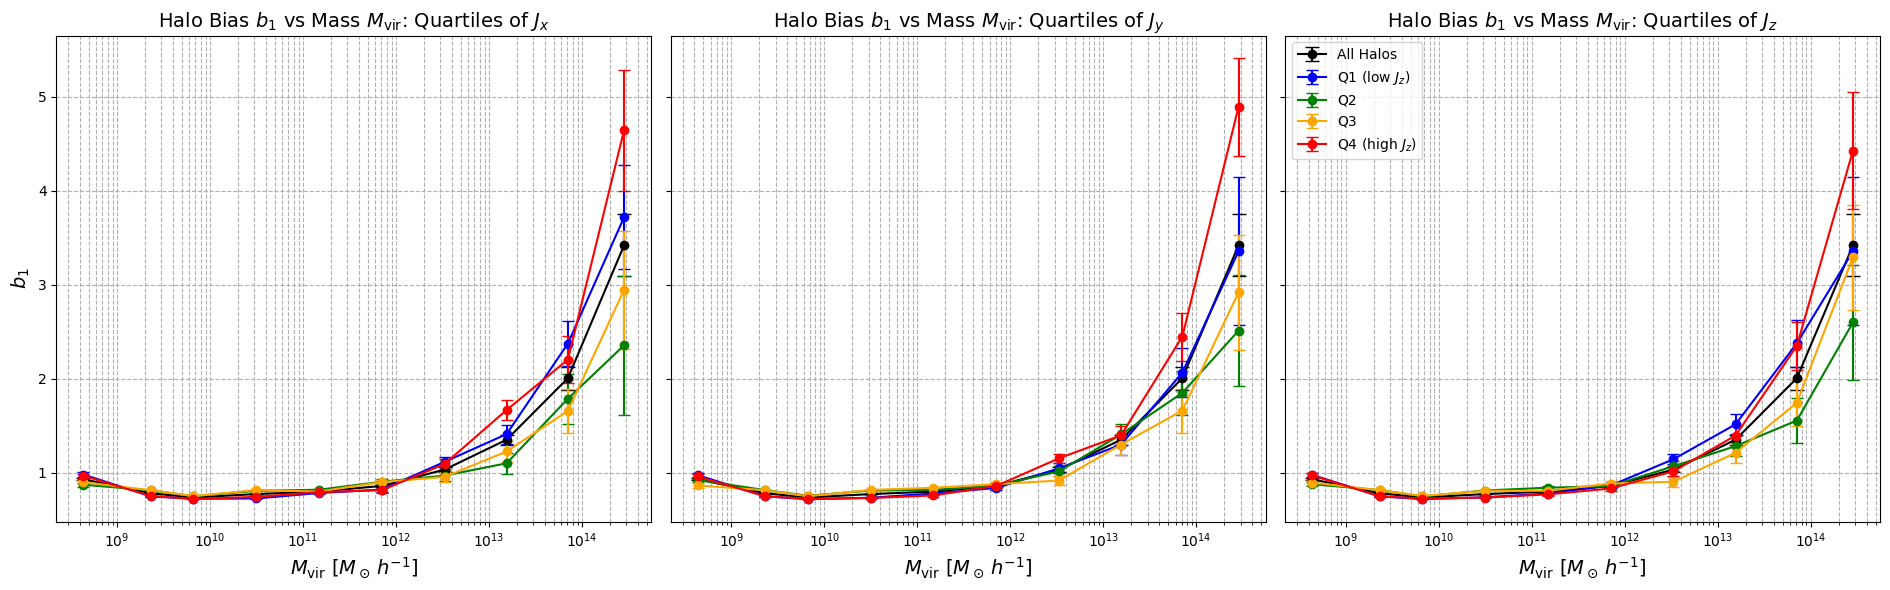


=== $J_x$ Quartiles ===
 bin 0: total=89962 halos; quartiles -> Q1=22491, Q2=22491, Q3=22490, Q4=22490
   Q1: Jx_min = -1.947e+08, Jx_max = -6.67e+06
   Q2: Jx_min = -6.67e+06, Jx_max = 0
   Q3: Jx_min = 0, Jx_max = 6.504e+06
   Q4: Jx_min = 6.506e+06, Jx_max = 1.993e+08
 bin 1: total=4706881 halos; quartiles -> Q1=1176721, Q2=1176720, Q3=1176720, Q4=1176720
   Q1: Jx_min = -1.19e+09, Jx_max = -3.559e+07
   Q2: Jx_min = -3.559e+07, Jx_max = -37580
   Q3: Jx_min = -37570, Jx_max = 3.558e+07
   Q4: Jx_min = 3.558e+07, Jx_max = 1.982e+09
 bin 2: total=4271456 halos; quartiles -> Q1=1067864, Q2=1067864, Q3=1067864, Q4=1067864
   Q1: Jx_min = -1.409e+10, Jx_max = -1.402e+08
   Q2: Jx_min = -1.402e+08, Jx_max = 96960
   Q3: Jx_min = 97210, Jx_max = 1.405e+08
   Q4: Jx_min = 1.405e+08, Jx_max = 1.589e+10
 bin 3: total=1108967 halos; quartiles -> Q1=277242, Q2=277242, Q3=277242, Q4=277241
   Q1: Jx_min = -1.557e+11, Jx_max = -1.663e+09
   Q2: Jx_min = -1.663e+09, Jx_max = -2.881e+06
   Q3: Jx

In [ ]:
def run_cell():
    df1 = df.copy()
    grouped = df1.groupby('mbin')
    m_mean_all = (10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all = grouped['b1'].count()
    b1_sem_all = (grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all = m_mean_all.sort_index()
    b1_mean_all = b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all = b1_sem_all.reindex(m_mean_all.index)
    mbin_list_for_plot = sorted(df1['mbin'].unique())
    quartile_names = ['Q1', 'Q2', 'Q3', 'Q4']
    Jcols = ['Jx', 'Jy', 'Jz']
    comp_labels = {'Jx':'$J_x$','Jy':'$J_y$','Jz':'$J_z$'}
    colors = {'Q1': 'blue','Q2': 'green','Q3': 'orange','Q4': 'red'}
    labels = {'Q1': 'Q1 (low)','Q2': 'Q2','Q3': 'Q3','Q4': 'Q4 (high)'}

    # Store everything by component (Jx/Jy/Jz)
    m_mean_q = {J: {q: [] for q in quartile_names} for J in Jcols}
    b1_mean_q = {J: {q: [] for q in quartile_names} for J in Jcols}
    b1_sem_q = {J: {q: [] for q in quartile_names} for J in Jcols}
    counts_per_bin = {J: {} for J in Jcols}
    J_range_per_bin = {J: {} for J in Jcols}
    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    # Calculate quartiles for each J-component
    for J in Jcols:
        for mbin in mbin_list_for_plot:
            bin_df = df1[df1['mbin'] == mbin]
            if len(bin_df) == 0:
                counts_per_bin[J][mbin] = {q: 0 for q in quartile_names}
                J_range_per_bin[J][mbin] = {q: (np.nan, np.nan) for q in quartile_names}
                for q in quartile_names:
                    m_mean_q[J][q].append(np.nan)
                    b1_mean_q[J][q].append(np.nan)
                    b1_sem_q[J][q].append(np.nan)
                continue

            clean = bin_df[[J, 'logMvir', 'b1']].replace([np.inf, -np.inf], np.nan).dropna(subset=[J]).copy()
            n_clean = len(clean)
            if n_clean == 0:
                counts_per_bin[J][mbin] = {q: 0 for q in quartile_names}
                J_range_per_bin[J][mbin] = {q: (np.nan, np.nan) for q in quartile_names}
                for q in quartile_names:
                    m_mean_q[J][q].append(np.nan)
                    b1_mean_q[J][q].append(np.nan)
                    b1_sem_q[J][q].append(np.nan)
                continue

            order = np.argsort(clean[J].values, kind='stable')
            sorted_idx = clean.index.values[order]
            base = n_clean // 4
            rem = n_clean % 4
            sizes = [base + (1 if i < rem else 0) for i in range(4)]
            edges = np.cumsum([0] + sizes)
            q_masks = {}
            for i, qname in enumerate(quartile_names):
                lo, hi = edges[i], edges[i+1]
                sel_idx = sorted_idx[lo:hi]
                q_masks[qname] = clean.index.isin(sel_idx)
            counts_per_bin[J][mbin] = {q: int(q_masks[q].sum()) for q in quartile_names}
            J_range_per_bin[J][mbin] = {}
            for qname in quartile_names:
                qdf = clean[q_masks[qname]]
                if len(qdf) == 0:
                    j_min, j_max = np.nan, np.nan
                else:
                    jvals = qdf[J].replace([np.inf, -np.inf], np.nan).dropna()
                    j_min = jvals.min() if len(jvals) else np.nan
                    j_max = jvals.max() if len(jvals) else np.nan
                J_range_per_bin[J][mbin][qname] = (j_min, j_max)
            for qname in quartile_names:
                qdf = clean[q_masks[qname]]
                if len(qdf) == 0:
                    m_mean_q[J][qname].append(np.nan)
                    b1_mean_q[J][qname].append(np.nan)
                    b1_sem_q[J][qname].append(np.nan)
                else:
                    m_mean_q[J][qname].append(10 ** qdf['logMvir'].mean())
                    b1_mean_q[J][qname].append(qdf['b1'].mean())
                    b1_sem_q[J][qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(19, 6), sharey=True)
    for iplt, J in enumerate(Jcols):
        ax = axes[iplt]
        ax.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')
        for q in quartile_names:
            xm, ym, em = [], [], []
            for i, mbin in enumerate(mbin_list_for_plot):
                mval = x_all[i]
                bval = b1_mean_q[J][q][i]
                err = b1_sem_q[J][q][i]
                if not np.isnan(bval) and not np.isnan(mval):
                    xm.append(mval)
                    ym.append(bval)
                    em.append(err)
            ax.errorbar(xm, ym, yerr=em, fmt='o-', capsize=4, label=labels[q].replace('(low','(low '+comp_labels[J]).replace('(high','(high '+comp_labels[J]), color=colors[q])
        ax.set_xscale('log')
        ax.set_xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
        if iplt == 0:
            ax.set_ylabel(r'$b_1$', fontsize=14)
        ax.set_title(f"Halo Bias $b_1$ vs Mass $M_{{\\rm vir}}$: Quartiles of {comp_labels[J]}", fontsize=14)
        ax.grid(True, which="both", ls="--")
        if iplt == 2:
            ax.legend()
    plt.tight_layout()
    plt.show()

    # Print summary for all J components
    for J in Jcols:
        print(f"\n=== {comp_labels[J]} Quartiles ===")
        for mbin in mbin_list_for_plot:
            n = len(df1[df1['mbin'] == mbin])
            qcounts = counts_per_bin[J].get(mbin, {q: 0 for q in quartile_names})
            print(f" bin {mbin}: total={n:4d} halos; quartiles -> " +
                  ", ".join([f"{q}={qcounts[q]:3d}" for q in quartile_names]))
            for q in quartile_names:
                smin, smax = J_range_per_bin[J].get(mbin, {}).get(q, (np.nan, np.nan))
                print(f"   {q}: {J}_min = {np.nan if np.isnan(smin) else format(smin, '.6g')}, "
                      f"{J}_max = {np.nan if np.isnan(smax) else format(smax, '.6g')}")
    del df1
    gc.collect()

output = run_cell()


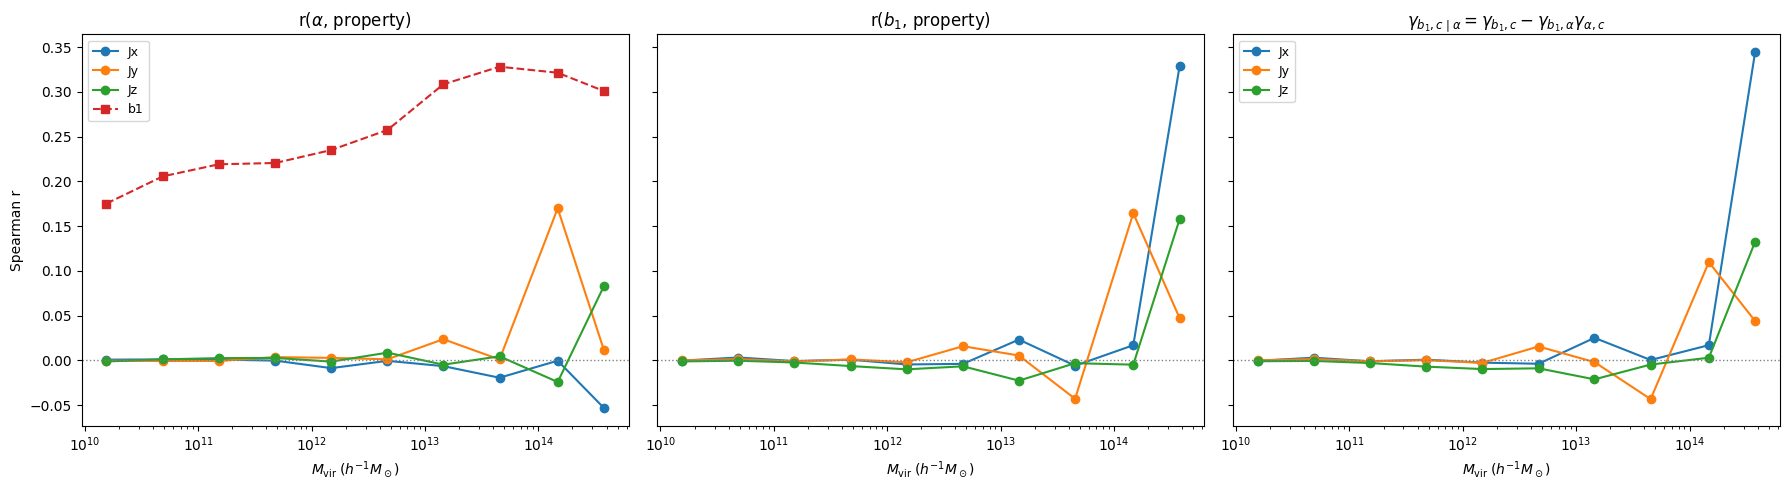

In [ ]:
from scipy.stats import spearmanr

def run_cell(min_n_for_stat=30, compute_normalized_partial=False):
    df1 = df.copy()

    if 'mbin' in df1.columns:
        df1 = df1.drop(columns=['mbin'])
    df1['Mvir'] = df1['Mvir'].astype(float)
    df1['logMvir'] = np.log10(df1['Mvir'])
    df1['trace'] = df1['lam1_R4R200b'].astype(float) + df1['lam2_R4R200b'].astype(float) + df1['lam3_R4R200b'].astype(float)
    df1['q2'] = 0.5 * (
        (df1['lam1_R4R200b'] - df1['lam2_R4R200b'])**2 +
        (df1['lam1_R4R200b'] - df1['lam3_R4R200b'])**2 +
        (df1['lam2_R4R200b'] - df1['lam3_R4R200b'])**2
    )
    df1['delta'] = df1['trace']
    df1['alpha'] = np.sqrt(df1['q2']) / (1 + df1['delta'])

    if 'cvir' not in df1.columns and ('Rvir' in df1.columns and 'rs' in df1.columns):
        df1['cvir'] = df1['Rvir'].astype(float) / df1['rs'].astype(float)

    # For Jx, Jy, Jz: ensure float type and not nan
    for J in ['Jx', 'Jy', 'Jz']:
        df1[J] = df1[J].astype(float)

    mass_cut = 1e10
    df1 = df1[df1['Mvir'] > mass_cut].copy()

    if len(df1) == 0:
        raise RuntimeError("No halos left after mass cut Mvir > 1e10. Check your data or lower the cut.")

    logmin = df1['logMvir'].min()
    logmax = df1['logMvir'].max()
    edges = np.linspace(logmin, logmax, 11)
    df1['mbin'] = pd.cut(df1['logMvir'], bins=edges, labels=False, include_lowest=True)
    df1 = df1.dropna(subset=['mbin']).copy()
    df1['mbin'] = df1['mbin'].astype(int)

    wanted = [('Jx','Jx'), ('Jy','Jy'), ('Jz','Jz')]
    props = [(lab, col) for lab, col in wanted if col in df1.columns]
    if not props:
        raise RuntimeError("No Jx, Jy, Jz found in df1 after mass cut. Edit columns or compute them.")
    grouped = df1.groupby('mbin')
    m_mean_all = (10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all = grouped['b1'].count()
    b1_sem_all = (grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all = m_mean_all.sort_index()
    b1_mean_all = b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all = b1_sem_all.reindex(m_mean_all.index)
    bins = np.sort(df1['mbin'].dropna().unique())
    n_bins = len(bins)
    r_alpha_c = {lab: np.full(n_bins, np.nan) for lab, col in props}
    r_b1_c    = {lab: np.full(n_bins, np.nan) for lab, col in props}
    gamma_b1c_given_alpha = {lab: np.full(n_bins, np.nan) for lab, col in props}
    partial_normalized = {lab: np.full(n_bins, np.nan) for lab, col in props}
    r_alpha_b1 = np.full(n_bins, np.nan)
    bin_median_M = np.full(n_bins, np.nan)
    counts_per_prop_bin = {lab: np.full(n_bins, 0, dtype=int) for lab, col in props}
    bin_n_total = np.full(n_bins, 0, dtype=int)
    for i, mbin in enumerate(bins):
        bin_df = df1[df1['mbin'] == mbin]
        n_total = len(bin_df)
        bin_n_total[i] = n_total
        if n_total == 0:
            continue
        bin_median_M[i] = bin_df['Mvir'].median()
        mask_ab = (~np.isnan(bin_df['b1'].values)) & (~np.isnan(bin_df['alpha'].values))
        if mask_ab.sum() >= int(min_n_for_stat):
            r_alpha_b1[i] = spearmanr(bin_df['alpha'].values[mask_ab], bin_df['b1'].values[mask_ab]).correlation
        else:
            r_alpha_b1[i] = np.nan
        for lab, col in props:
            arr_b1 = bin_df['b1'].values
            arr_alpha = bin_df['alpha'].values
            arr_p = bin_df[col].values
            mask = (~np.isnan(arr_b1)) & (~np.isnan(arr_alpha)) & (~np.isnan(arr_p))
            nclean = int(mask.sum())
            counts_per_prop_bin[lab][i] = nclean
            if nclean < int(min_n_for_stat):
                r_alpha_c[lab][i] = np.nan
                r_b1_c[lab][i] = np.nan
                gamma_b1c_given_alpha[lab][i] = np.nan
                partial_normalized[lab][i] = np.nan
                continue

            bvals = arr_b1[mask]
            avals = arr_alpha[mask]
            pvals = arr_p[mask]

            r_b1_p = spearmanr(bvals, pvals).correlation
            r_alpha_p = spearmanr(avals, pvals).correlation
            r_b1_alpha_local = spearmanr(bvals, avals).correlation

            r_alpha_c[lab][i] = r_alpha_p
            r_b1_c[lab][i] = r_b1_p
            gamma_b1c_given_alpha[lab][i] = r_b1_p - (r_b1_alpha_local * r_alpha_p)
            if compute_normalized_partial:
                denom = np.sqrt((1 - r_b1_alpha_local**2) * (1 - r_alpha_p**2))
                if denom == 0:
                    partial_normalized[lab][i] = np.nan
                else:
                    partial_normalized[lab][i] = (r_b1_p - r_b1_alpha_local * r_alpha_p) / denom

    valid = ~np.isnan(bin_median_M)
    x = bin_median_M[valid]

    fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
    axL, axM, axR = axes
    for lab, col in props:
        axL.plot(x, r_alpha_c[lab][valid], marker='o', linestyle='-', label=lab)
    axL.plot(x, r_alpha_b1[valid], marker='s', linestyle='--', label='b1')
    axL.axhline(0, color='gray', linestyle=':', linewidth=1)
    for lab, col in props:
        axM.plot(x, r_b1_c[lab][valid], marker='o', linestyle='-', label=lab)
    axM.axhline(0, color='gray', linestyle=':', linewidth=1)

    for lab, col in props:
        axR.plot(x, gamma_b1c_given_alpha[lab][valid], marker='o', linestyle='-', label=lab)
    axR.axhline(0, color='gray', linestyle=':', linewidth=1)
    for ax in axes:
        ax.set_xscale('log')
        ax.set_xlabel(r'$M_{\rm vir}\; (h^{-1}M_\odot)$')
    axL.set_ylabel('Spearman r')
    axL.set_title(r'r($\alpha$, property)')
    axM.set_title(r'r($b_1$, property)')
    axR.set_title(r'$\gamma_{b_1,c \mid \alpha} = \gamma_{b_1,c} - \gamma_{b_1,\alpha}\gamma_{\alpha,c}$')
    axL.legend(fontsize=9)
    axR.legend(fontsize=9)
    plt.tight_layout()
    plt.show()
    if compute_normalized_partial:
        fig2, ax2 = plt.subplots(1,1,figsize=(6,4))
        for lab, col in props:
            ax2.plot(x, partial_normalized[lab][valid], marker='o', linestyle='-', label=lab)
        ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
        ax2.set_xscale('log')
        ax2.set_xlabel(r'$M_{\rm vir}\; (h^{-1}M_\odot)$')
        ax2.set_ylabel('normalized partial Spearman r')
        ax2.set_title('normalized partial correlation r(b1, prop | alpha)')
        ax2.legend(fontsize=9)
        plt.tight_layout()
        plt.show()
    del df1
    gc.collect()

output = run_cell()


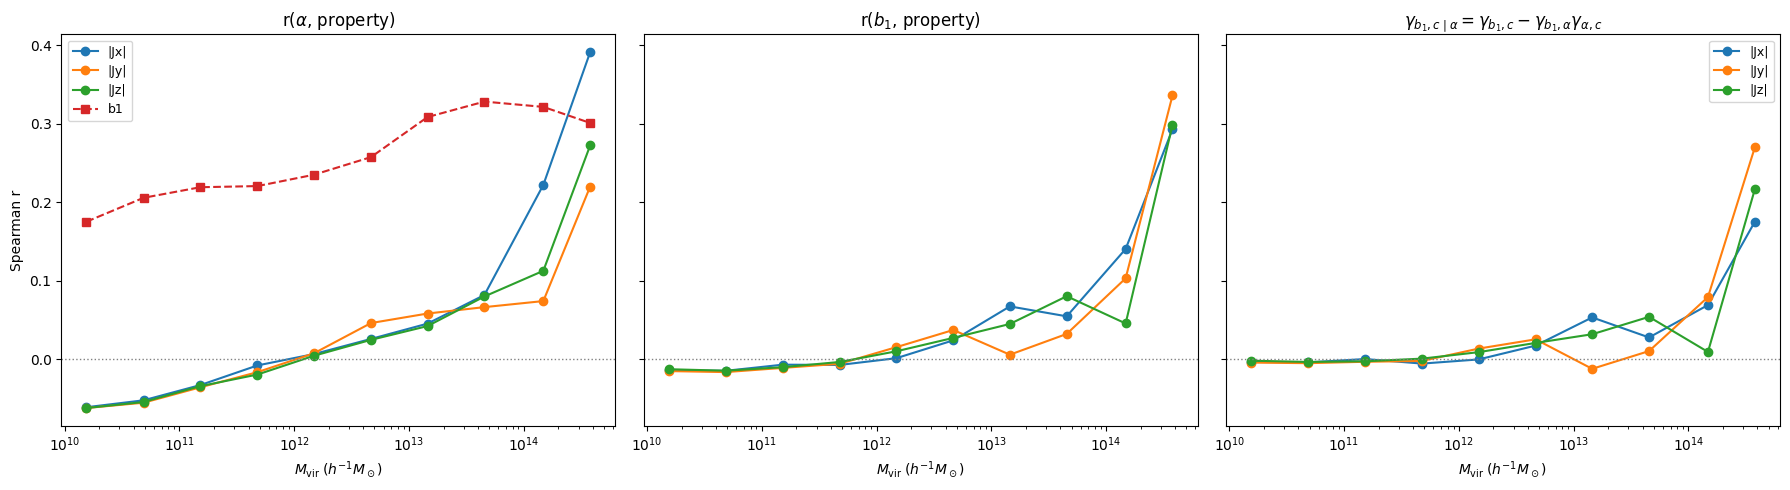

In [ ]:
from scipy.stats import spearmanr


def run_cell(min_n_for_stat=30, compute_normalized_partial=False):
    df1 = df.copy()

    if 'mbin' in df1.columns:
        df1 = df1.drop(columns=['mbin'])
    df1['Mvir'] = df1['Mvir'].astype(float)
    df1['logMvir'] = np.log10(df1['Mvir'])
    df1['trace'] = df1['lam1_R4R200b'].astype(float) + df1['lam2_R4R200b'].astype(float) + df1['lam3_R4R200b'].astype(float)
    df1['q2'] = 0.5 * (
        (df1['lam1_R4R200b'] - df1['lam2_R4R200b'])**2 +
        (df1['lam1_R4R200b'] - df1['lam3_R4R200b'])**2 +
        (df1['lam2_R4R200b'] - df1['lam3_R4R200b'])**2
    )
    df1['delta'] = df1['trace']
    df1['alpha'] = np.sqrt(df1['q2']) / (1 + df1['delta'])

    # Create absolute value columns for Jx, Jy, Jz
    for J in ['Jx', 'Jy', 'Jz']:
        df1[J] = df1[J].astype(float)
        df1[f'abs_{J}'] = np.abs(df1[J])

    mass_cut = 1e10
    df1 = df1[df1['Mvir'] > mass_cut].copy()

    if len(df1) == 0:
        raise RuntimeError("No halos left after mass cut Mvir > 1e10. Check your data or lower the cut.")

    logmin = df1['logMvir'].min()
    logmax = df1['logMvir'].max()
    edges = np.linspace(logmin, logmax, 11)
    df1['mbin'] = pd.cut(df1['logMvir'], bins=edges, labels=False, include_lowest=True)
    df1 = df1.dropna(subset=['mbin']).copy()
    df1['mbin'] = df1['mbin'].astype(int)

    wanted = [('|Jx|','abs_Jx'), ('|Jy|','abs_Jy'), ('|Jz|','abs_Jz')]
    props = [(lab, col) for lab, col in wanted if col in df1.columns]
    if not props:
        raise RuntimeError("No abs_Jx, abs_Jy, abs_Jz found in df1 after mass cut.")
    grouped = df1.groupby('mbin')
    m_mean_all = (10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all = grouped['b1'].count()
    b1_sem_all = (grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all = m_mean_all.sort_index()
    b1_mean_all = b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all = b1_sem_all.reindex(m_mean_all.index)
    bins = np.sort(df1['mbin'].dropna().unique())
    n_bins = len(bins)
    r_alpha_c = {lab: np.full(n_bins, np.nan) for lab, col in props}
    r_b1_c    = {lab: np.full(n_bins, np.nan) for lab, col in props}
    gamma_b1c_given_alpha = {lab: np.full(n_bins, np.nan) for lab, col in props}
    partial_normalized = {lab: np.full(n_bins, np.nan) for lab, col in props}
    r_alpha_b1 = np.full(n_bins, np.nan)
    bin_median_M = np.full(n_bins, np.nan)
    counts_per_prop_bin = {lab: np.full(n_bins, 0, dtype=int) for lab, col in props}
    bin_n_total = np.full(n_bins, 0, dtype=int)
    for i, mbin in enumerate(bins):
        bin_df = df1[df1['mbin'] == mbin]
        n_total = len(bin_df)
        bin_n_total[i] = n_total
        if n_total == 0:
            continue
        bin_median_M[i] = bin_df['Mvir'].median()
        mask_ab = (~np.isnan(bin_df['b1'].values)) & (~np.isnan(bin_df['alpha'].values))
        if mask_ab.sum() >= int(min_n_for_stat):
            r_alpha_b1[i] = spearmanr(bin_df['alpha'].values[mask_ab], bin_df['b1'].values[mask_ab]).correlation
        else:
            r_alpha_b1[i] = np.nan
        for lab, col in props:
            arr_b1 = bin_df['b1'].values
            arr_alpha = bin_df['alpha'].values
            arr_p = bin_df[col].values
            mask = (~np.isnan(arr_b1)) & (~np.isnan(arr_alpha)) & (~np.isnan(arr_p))
            nclean = int(mask.sum())
            counts_per_prop_bin[lab][i] = nclean
            if nclean < int(min_n_for_stat):
                r_alpha_c[lab][i] = np.nan
                r_b1_c[lab][i] = np.nan
                gamma_b1c_given_alpha[lab][i] = np.nan
                partial_normalized[lab][i] = np.nan
                continue

            bvals = arr_b1[mask]
            avals = arr_alpha[mask]
            pvals = arr_p[mask]

            r_b1_p = spearmanr(bvals, pvals).correlation
            r_alpha_p = spearmanr(avals, pvals).correlation
            r_b1_alpha_local = spearmanr(bvals, avals).correlation

            r_alpha_c[lab][i] = r_alpha_p
            r_b1_c[lab][i] = r_b1_p
            gamma_b1c_given_alpha[lab][i] = r_b1_p - (r_b1_alpha_local * r_alpha_p)
            if compute_normalized_partial:
                denom = np.sqrt((1 - r_b1_alpha_local**2) * (1 - r_alpha_p**2))
                if denom == 0:
                    partial_normalized[lab][i] = np.nan
                else:
                    partial_normalized[lab][i] = (r_b1_p - r_b1_alpha_local * r_alpha_p) / denom

    valid = ~np.isnan(bin_median_M)
    x = bin_median_M[valid]

    fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
    axL, axM, axR = axes
    for lab, col in props:
        axL.plot(x, r_alpha_c[lab][valid], marker='o', linestyle='-', label=lab)
    axL.plot(x, r_alpha_b1[valid], marker='s', linestyle='--', label='b1')
    axL.axhline(0, color='gray', linestyle=':', linewidth=1)
    for lab, col in props:
        axM.plot(x, r_b1_c[lab][valid], marker='o', linestyle='-', label=lab)
    axM.axhline(0, color='gray', linestyle=':', linewidth=1)

    for lab, col in props:
        axR.plot(x, gamma_b1c_given_alpha[lab][valid], marker='o', linestyle='-', label=lab)
    axR.axhline(0, color='gray', linestyle=':', linewidth=1)
    for ax in axes:
        ax.set_xscale('log')
        ax.set_xlabel(r'$M_{\rm vir}\; (h^{-1}M_\odot)$')
    axL.set_ylabel('Spearman r')
    axL.set_title(r'r($\alpha$, property)')
    axM.set_title(r'r($b_1$, property)')
    axR.set_title(r'$\gamma_{b_1,c \mid \alpha} = \gamma_{b_1,c} - \gamma_{b_1,\alpha}\gamma_{\alpha,c}$')
    axL.legend(fontsize=9)
    axR.legend(fontsize=9)
    plt.tight_layout()
    plt.show()
    if compute_normalized_partial:
        fig2, ax2 = plt.subplots(1,1,figsize=(6,4))
        for lab, col in props:
            ax2.plot(x, partial_normalized[lab][valid], marker='o', linestyle='-', label=lab)
        ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
        ax2.set_xscale('log')
        ax2.set_xlabel(r'$M_{\rm vir}\; (h^{-1}M_\odot)$')
        ax2.set_ylabel('normalized partial Spearman r')
        ax2.set_title('normalized partial correlation r(b1, prop | alpha)')
        ax2.legend(fontsize=9)
        plt.tight_layout()
        plt.show()
    del df1
    gc.collect()

output = run_cell()


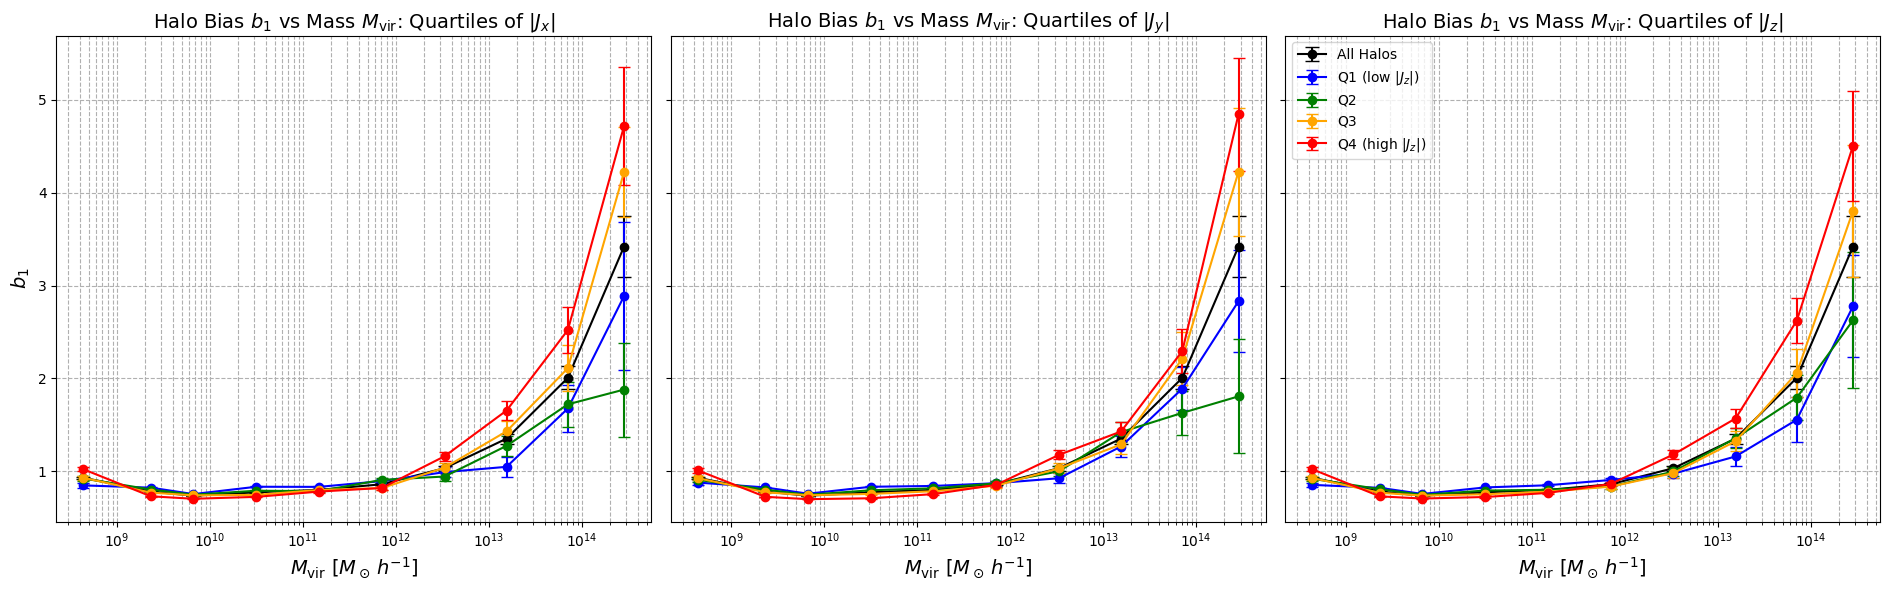


=== $|J_x|$ Quartiles ===
 bin 0: total=89962 halos; quartiles -> Q1=22491, Q2=22491, Q3=22490, Q4=22490
   Q1: abs_Jx_min = 0, abs_Jx_max = 2.247e+06
   Q2: abs_Jx_min = 2.247e+06, abs_Jx_max = 6.579e+06
   Q3: abs_Jx_min = 6.579e+06, abs_Jx_max = 1.458e+07
   Q4: abs_Jx_min = 1.459e+07, abs_Jx_max = 1.993e+08
 bin 1: total=4706881 halos; quartiles -> Q1=1176721, Q2=1176720, Q3=1176720, Q4=1176720
   Q1: abs_Jx_min = 0.3209, abs_Jx_max = 1.611e+07
   Q2: abs_Jx_min = 1.611e+07, abs_Jx_max = 3.559e+07
   Q3: abs_Jx_min = 3.559e+07, abs_Jx_max = 6.593e+07
   Q4: abs_Jx_min = 6.593e+07, abs_Jx_max = 1.982e+09
 bin 2: total=4271456 halos; quartiles -> Q1=1067864, Q2=1067864, Q3=1067864, Q4=1067864
   Q1: abs_Jx_min = 84.63, abs_Jx_max = 6.082e+07
   Q2: abs_Jx_min = 6.082e+07, abs_Jx_max = 1.404e+08
   Q3: abs_Jx_min = 1.404e+08, abs_Jx_max = 2.995e+08
   Q4: abs_Jx_min = 2.995e+08, abs_Jx_max = 1.589e+10
 bin 3: total=1108967 halos; quartiles -> Q1=277242, Q2=277242, Q3=277242, Q4=27724

In [ ]:
def run_cell():
    df1 = df.copy()
    # Compute absolute values for angular momentum components
    for J in ['Jx', 'Jy', 'Jz']:
        df1[f'abs_{J}'] = np.abs(df1[J])

    grouped = df1.groupby('mbin')
    m_mean_all = (10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all = grouped['b1'].count()
    b1_sem_all = (grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all = m_mean_all.sort_index()
    b1_mean_all = b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all = b1_sem_all.reindex(m_mean_all.index)
    mbin_list_for_plot = sorted(df1['mbin'].unique())
    quartile_names = ['Q1', 'Q2', 'Q3', 'Q4']
    Jcols = ['abs_Jx', 'abs_Jy', 'abs_Jz']
    comp_labels = {'abs_Jx':r'$|J_x|$','abs_Jy':r'$|J_y|$','abs_Jz':r'$|J_z|$'}
    colors = {'Q1': 'blue','Q2': 'green','Q3': 'orange','Q4': 'red'}
    labels = {'Q1': 'Q1 (low)','Q2': 'Q2','Q3': 'Q3','Q4': 'Q4 (high)'}

    # Store everything by component (|Jx|/|Jy|/|Jz|)
    m_mean_q = {J: {q: [] for q in quartile_names} for J in Jcols}
    b1_mean_q = {J: {q: [] for q in quartile_names} for J in Jcols}
    b1_sem_q = {J: {q: [] for q in quartile_names} for J in Jcols}
    counts_per_bin = {J: {} for J in Jcols}
    J_range_per_bin = {J: {} for J in Jcols}
    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    # Calculate quartiles for each abs(J) component
    for J in Jcols:
        for mbin in mbin_list_for_plot:
            bin_df = df1[df1['mbin'] == mbin]
            if len(bin_df) == 0:
                counts_per_bin[J][mbin] = {q: 0 for q in quartile_names}
                J_range_per_bin[J][mbin] = {q: (np.nan, np.nan) for q in quartile_names}
                for q in quartile_names:
                    m_mean_q[J][q].append(np.nan)
                    b1_mean_q[J][q].append(np.nan)
                    b1_sem_q[J][q].append(np.nan)
                continue

            clean = bin_df[[J, 'logMvir', 'b1']].replace([np.inf, -np.inf], np.nan).dropna(subset=[J]).copy()
            n_clean = len(clean)
            if n_clean == 0:
                counts_per_bin[J][mbin] = {q: 0 for q in quartile_names}
                J_range_per_bin[J][mbin] = {q: (np.nan, np.nan) for q in quartile_names}
                for q in quartile_names:
                    m_mean_q[J][q].append(np.nan)
                    b1_mean_q[J][q].append(np.nan)
                    b1_sem_q[J][q].append(np.nan)
                continue

            order = np.argsort(clean[J].values, kind='stable')
            sorted_idx = clean.index.values[order]
            base = n_clean // 4
            rem = n_clean % 4
            sizes = [base + (1 if i < rem else 0) for i in range(4)]
            edges = np.cumsum([0] + sizes)
            q_masks = {}
            for i, qname in enumerate(quartile_names):
                lo, hi = edges[i], edges[i+1]
                sel_idx = sorted_idx[lo:hi]
                q_masks[qname] = clean.index.isin(sel_idx)
            counts_per_bin[J][mbin] = {q: int(q_masks[q].sum()) for q in quartile_names}
            J_range_per_bin[J][mbin] = {}
            for qname in quartile_names:
                qdf = clean[q_masks[qname]]
                if len(qdf) == 0:
                    j_min, j_max = np.nan, np.nan
                else:
                    jvals = qdf[J].replace([np.inf, -np.inf], np.nan).dropna()
                    j_min = jvals.min() if len(jvals) else np.nan
                    j_max = jvals.max() if len(jvals) else np.nan
                J_range_per_bin[J][mbin][qname] = (j_min, j_max)
            for qname in quartile_names:
                qdf = clean[q_masks[qname]]
                if len(qdf) == 0:
                    m_mean_q[J][qname].append(np.nan)
                    b1_mean_q[J][qname].append(np.nan)
                    b1_sem_q[J][qname].append(np.nan)
                else:
                    m_mean_q[J][qname].append(10 ** qdf['logMvir'].mean())
                    b1_mean_q[J][qname].append(qdf['b1'].mean())
                    b1_sem_q[J][qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(19, 6), sharey=True)
    for iplt, J in enumerate(Jcols):
        ax = axes[iplt]
        ax.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')
        for q in quartile_names:
            xm, ym, em = [], [], []
            for i, mbin in enumerate(mbin_list_for_plot):
                mval = x_all[i]
                bval = b1_mean_q[J][q][i]
                err = b1_sem_q[J][q][i]
                if not np.isnan(bval) and not np.isnan(mval):
                    xm.append(mval)
                    ym.append(bval)
                    em.append(err)
            ax.errorbar(xm, ym, yerr=em, fmt='o-', capsize=4,
                        label=labels[q].replace('(low',
                                               '(low '+comp_labels[J]).replace('(high',
                                                                               '(high '+comp_labels[J]),
                        color=colors[q])
        ax.set_xscale('log')
        ax.set_xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
        if iplt == 0:
            ax.set_ylabel(r'$b_1$', fontsize=14)
        ax.set_title(f"Halo Bias $b_1$ vs Mass $M_{{\\rm vir}}$: Quartiles of {comp_labels[J]}", fontsize=14)
        ax.grid(True, which="both", ls="--")
        if iplt == 2:
            ax.legend()
    plt.tight_layout()
    plt.show()

    # Print summary for all |J| components
    for J in Jcols:
        print(f"\n=== {comp_labels[J]} Quartiles ===")
        for mbin in mbin_list_for_plot:
            n = len(df1[df1['mbin'] == mbin])
            qcounts = counts_per_bin[J].get(mbin, {q: 0 for q in quartile_names})
            print(f" bin {mbin}: total={n:4d} halos; quartiles -> " +
                  ", ".join([f"{q}={qcounts[q]:3d}" for q in quartile_names]))
            for q in quartile_names:
                smin, smax = J_range_per_bin[J].get(mbin, {}).get(q, (np.nan, np.nan))
                print(f"   {q}: {J}_min = {np.nan if np.isnan(smin) else format(smin, '.6g')}, "
                      f"{J}_max = {np.nan if np.isnan(smax) else format(smax, '.6g')}")
    del df1
    gc.collect()

output = run_cell()


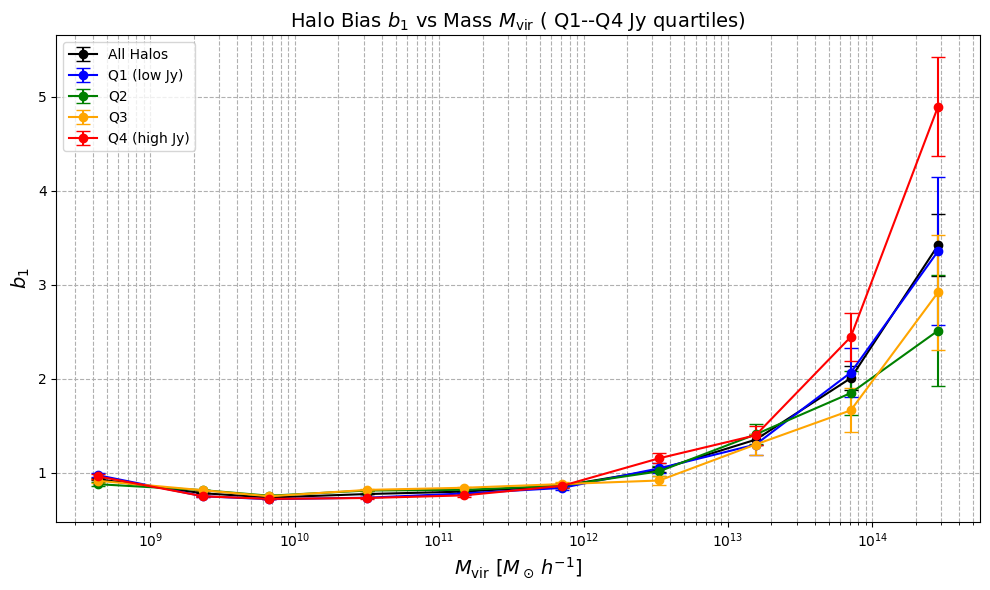

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

 bin 0: total=89962 halos; quartiles -> Q1=22491, Q2=24954, Q3=20027, Q4=22490
   Q1: Jy_min = -1.825e+08, Jy_max = -6.624e+06
   Q2: Jy_min = -6.623e+06, Jy_max = 0
   Q3: Jy_min = 121.5, Jy_max = 6.494e+06
   Q4: Jy_min = 6.496e+06, Jy_max = 1.887e+08

 bin 1: total=4706881 halos; quartiles -> Q1=1176728, Q2=1176713, Q3=1176917, Q4=1176523
   Q1: Jy_min = -1.229e+09, Jy_max = -3.558e+07
   Q2: Jy_min = -3.557e+07, Jy_max = -6675
   Q3: Jy_min = -6624, Jy_max = 3.562e+07
   Q4: Jy_min = 3.563e+07, Jy_max = 1.53e+09

 bin 2: total=4271456 halos; quartiles -> Q1=1067969, Q2=1067759, Q3=1068150, Q4=1067578
   Q1: Jy_min = -1.585e+10, Jy_max = -1.404e+08
   Q2: Jy_min = -1.403e+08, Jy_max = -159000
   Q3: Jy_min = -158800, Jy_max = 1.399e+08
   Q4: Jy_min = 1.4e+08, Jy_max = 1.826e+10

 bin 3: total=1108967 halos; quartiles -> Q1=277321, Q2=27

In [ ]:
def run_cell():
    df1=df.copy()
    grouped=df1.groupby('mbin')

    m_mean_all=(10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all=grouped['b1'].count()
    b1_sem_all =(grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all = m_mean_all.sort_index()
    b1_mean_all=b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all=b1_sem_all.reindex(m_mean_all.index)
    quartile_names=['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q={q: [] for q in quartile_names}
    b1_mean_q={q: [] for q in quartile_names}
    b1_sem_q ={q: [] for q in quartile_names}
    mbin_list_for_plot = []
    counts_per_bin ={}
    jy_range_per_bin= {}

    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin']==mbin]
        if len(bin_df)==0:
            counts_per_bin[mbin]={q: 0 for q in quartile_names}
            jy_range_per_bin[mbin]={q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        q1, q2, q3=np.quantile(bin_df['Jy'].values, [0.25, 0.5, 0.75])
        masks = {
            'Q1': bin_df['Jy'] <= q1,
            'Q2': (bin_df['Jy'] > q1) & (bin_df['Jy'] <= q2),
            'Q3': (bin_df['Jy'] > q2) & (bin_df['Jy'] <= q3),
            'Q4': bin_df['Jy'] > q3
        }
        counts_per_bin[mbin]={q: int(masks[q].sum()) for q in quartile_names}
        jy_range_per_bin[mbin]={}
        for qname in quartile_names:
            qdf = bin_df[masks[qname]]
            if len(qdf)==0:
                jy_min=np.nan
                jy_max=np.nan
            else:
                s_clean=qdf['Jy'].replace([np.inf, -np.inf], np.nan).dropna()
                if len(s_clean)==0:
                    jy_min=np.nan
                    jy_max = np.nan
                else:
                    jy_min=s_clean.min()
                    jy_max=s_clean.max()
            jy_range_per_bin[mbin][qname] = (jy_min, jy_max)

        for qname in quartile_names:
            qdf=bin_df[masks[qname]]
            if len(qdf) == 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    plot_data = {}
    for q in quartile_names:
        xm, ym, em = [], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval = m_mean_q[q][i]
            bval = b1_mean_q[q][i]
            err = b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(x_all[i])
                ym.append(bval)
                em.append(err)
        plot_data[q]=(np.array(xm), np.array(ym), np.array(em))

    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    colors={'Q1':'blue','Q2':'green','Q3':'orange','Q4':'red'}
    labels={'Q1':'Q1 (low Jy)', 'Q2':'Q2', 'Q3':'Q3', 'Q4':'Q4 (high Jy)'}
    for q in quartile_names:
        xm, ym, em = plot_data[q]
        if len(xm) > 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])
    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ ( Q1--Q4 Jy quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n=len(df1[df1['mbin']==mbin])
        qcounts = counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\n bin {mbin}: total={n:4d} halos; quartiles -> " +
              ", ".join([f"{q}={qcounts[q]:3d}" for q in quartile_names]))
        for q in quartile_names:
            smin, smax = jy_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: Jy_min = {np.nan if np.isnan(smin) else format(smin, '.6g')}, "
                  f"Jy_max = {np.nan if np.isnan(smax) else format(smax, '.6g')}")
    del df1
    gc.collect()

output = run_cell()

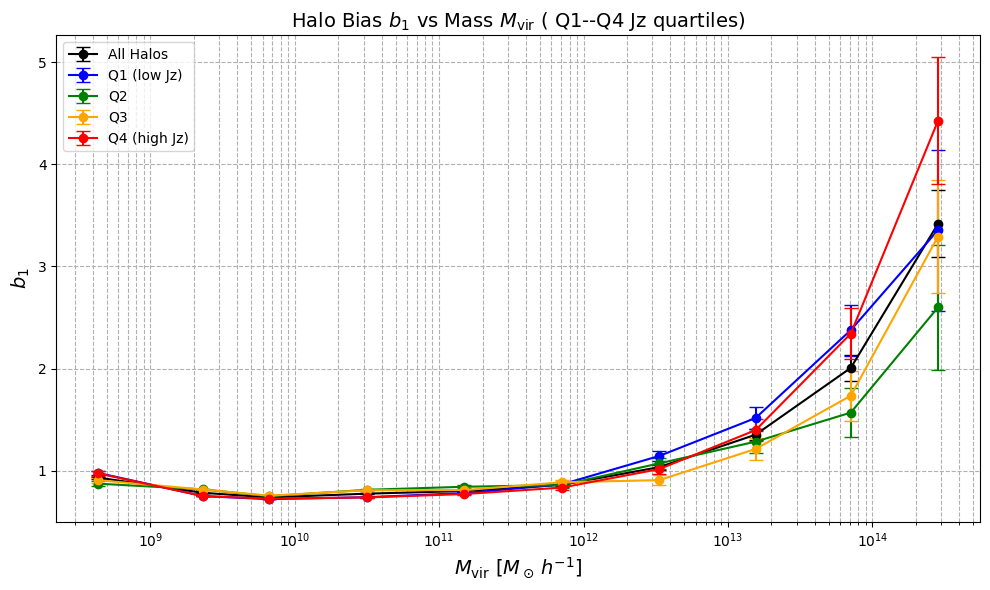

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

 bin 0: total=89962 halos; quartiles -> Q1=22491, Q2=24559, Q3=20423, Q4=22489
   Q1: Jz_min = -2.034e+08, Jz_max = -6.511e+06
   Q2: Jz_min = -6.51e+06, Jz_max = 0
   Q3: Jz_min = 224.6, Jz_max = 6.487e+06
   Q4: Jz_min = 6.488e+06, Jz_max = 2.072e+08

 bin 1: total=4706881 halos; quartiles -> Q1=1176934, Q2=1176507, Q3=1176780, Q4=1176660
   Q1: Jz_min = -1.972e+09, Jz_max = -3.555e+07
   Q2: Jz_min = -3.554e+07, Jz_max = 38380
   Q3: Jz_min = 38420, Jz_max = 3.561e+07
   Q4: Jz_min = 3.562e+07, Jz_max = 1.282e+09

 bin 2: total=4271456 halos; quartiles -> Q1=1067897, Q2=1067832, Q3=1068125, Q4=1067602
   Q1: Jz_min = -1.52e+10, Jz_max = -1.4e+08
   Q2: Jz_min = -1.399e+08, Jz_max = 234700
   Q3: Jz_min = 234800, Jz_max = 1.405e+08
   Q4: Jz_min = 1.406e+08, Jz_max = 1.586e+10

 bin 3: total=1108967 halos; quartiles -> Q1=277287, Q2=27719

In [ ]:
def run_cell():
    df1=df.copy()
    grouped=df1.groupby('mbin')

    m_mean_all=(10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all=grouped['b1'].count()
    b1_sem_all =(grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all = m_mean_all.sort_index()
    b1_mean_all=b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all=b1_sem_all.reindex(m_mean_all.index)
    quartile_names=['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q={q: [] for q in quartile_names}
    b1_mean_q={q: [] for q in quartile_names}
    b1_sem_q ={q: [] for q in quartile_names}
    mbin_list_for_plot = []
    counts_per_bin ={}
    jz_range_per_bin= {}

    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin']==mbin]
        if len(bin_df)==0:
            counts_per_bin[mbin]={q: 0 for q in quartile_names}
            jz_range_per_bin[mbin]={q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        q1, q2, q3=np.quantile(bin_df['Jz'].values, [0.25, 0.5, 0.75])
        masks = {
            'Q1': bin_df['Jz'] <= q1,
            'Q2': (bin_df['Jz'] > q1) & (bin_df['Jz'] <= q2),
            'Q3': (bin_df['Jz'] > q2) & (bin_df['Jz'] <= q3),
            'Q4': bin_df['Jz'] > q3
        }
        counts_per_bin[mbin]={q: int(masks[q].sum()) for q in quartile_names}
        jz_range_per_bin[mbin]={}
        for qname in quartile_names:
            qdf = bin_df[masks[qname]]
            if len(qdf)==0:
                jz_min=np.nan
                jz_max=np.nan
            else:
                s_clean=qdf['Jz'].replace([np.inf, -np.inf], np.nan).dropna()
                if len(s_clean)==0:
                    jz_min=np.nan
                    jz_max = np.nan
                else:
                    jz_min=s_clean.min()
                    jz_max=s_clean.max()
            jz_range_per_bin[mbin][qname] = (jz_min, jz_max)

        for qname in quartile_names:
            qdf=bin_df[masks[qname]]
            if len(qdf) == 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    plot_data = {}
    for q in quartile_names:
        xm, ym, em = [], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval = m_mean_q[q][i]
            bval = b1_mean_q[q][i]
            err = b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(x_all[i])
                ym.append(bval)
                em.append(err)
        plot_data[q]=(np.array(xm), np.array(ym), np.array(em))

    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    colors={'Q1':'blue','Q2':'green','Q3':'orange','Q4':'red'}
    labels={'Q1':'Q1 (low Jz)', 'Q2':'Q2', 'Q3':'Q3', 'Q4':'Q4 (high Jz)'}
    for q in quartile_names:
        xm, ym, em = plot_data[q]
        if len(xm) > 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])
    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ ( Q1--Q4 Jz quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n=len(df1[df1['mbin']==mbin])
        qcounts = counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\n bin {mbin}: total={n:4d} halos; quartiles -> " +
              ", ".join([f"{q}={qcounts[q]:3d}" for q in quartile_names]))
        for q in quartile_names:
            smin, smax = jz_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: Jz_min = {np.nan if np.isnan(smin) else format(smin, '.6g')}, "
                  f"Jz_max = {np.nan if np.isnan(smax) else format(smax, '.6g')}")
    del df1
    gc.collect()

output = run_cell()

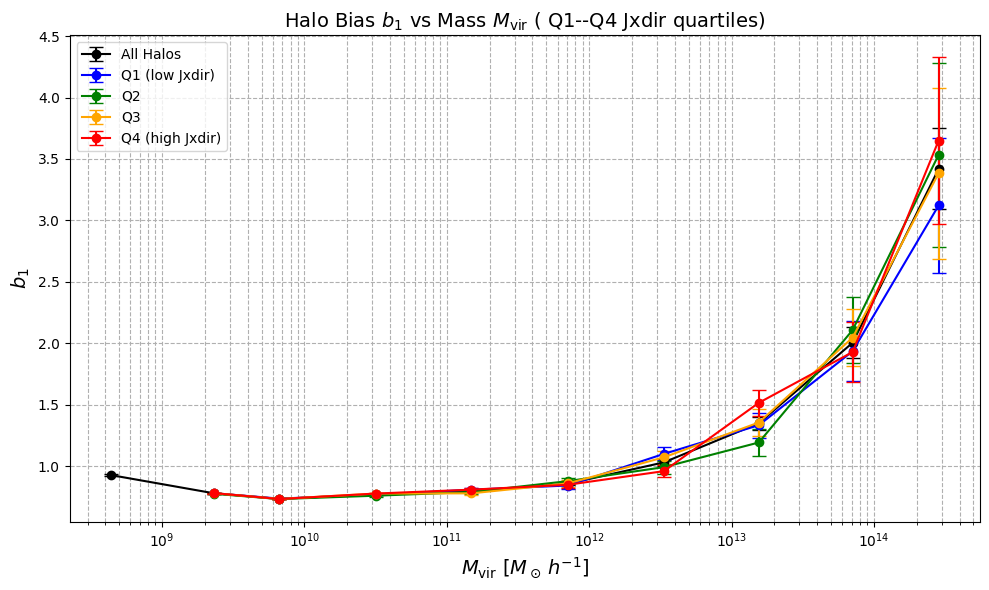

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

 bin 0: total=89962 halos; quartiles -> Q1=  0, Q2=  0, Q3=  0, Q4=  0
   Q1: Jxdir_min = nan, Jxdir_max = nan
   Q2: Jxdir_min = nan, Jxdir_max = nan
   Q3: Jxdir_min = nan, Jxdir_max = nan
   Q4: Jxdir_min = nan, Jxdir_max = nan

 bin 1: total=4706881 halos; quartiles -> Q1=1176721, Q2=1176720, Q3=1176720, Q4=1176720
   Q1: Jxdir_min = -1, Jxdir_max = -0.500106
   Q2: Jxdir_min = -0.500106, Jxdir_max = -0.000590572
   Q3: Jxdir_min = -0.000590121, Jxdir_max = 0.499677
   Q4: Jxdir_min = 0.499678, Jxdir_max = 1

 bin 2: total=4271456 halos; quartiles -> Q1=1067864, Q2=1067864, Q3=1067864, Q4=1067864
   Q1: Jxdir_min = -1, Jxdir_max = -0.500276
   Q2: Jxdir_min = -0.500276, Jxdir_max = 0.000402889
   Q3: Jxdir_min = 0.000403616, Jxdir_max = 0.500818
   Q4: Jxdir_min = 0.500818, Jxdir_max = 1

 bin 3: total=1108967 halos; quartiles -> Q1=277

In [ ]:
def run_cell():
    df1=df.copy()
    df1['Jxdir']=df1['Jx']/(np.sqrt((df1['Jx'])**2+(df1['Jy'])**2+(df1['Jz'])**2))
    grouped=df1.groupby('mbin')

    m_mean_all=(10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all=grouped['b1'].count()
    b1_sem_all =(grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all = m_mean_all.sort_index()
    b1_mean_all=b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all=b1_sem_all.reindex(m_mean_all.index)
    quartile_names=['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q={q: [] for q in quartile_names}
    b1_mean_q={q: [] for q in quartile_names}
    b1_sem_q ={q: [] for q in quartile_names}
    mbin_list_for_plot = []
    counts_per_bin ={}
    jxdir_range_per_bin= {}

    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin']==mbin]
        if len(bin_df)==0:
            counts_per_bin[mbin]={q: 0 for q in quartile_names}
            jxdir_range_per_bin[mbin]={q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        q1, q2, q3=np.quantile(bin_df['Jxdir'].values, [0.25, 0.5, 0.75])
        masks = {
            'Q1': bin_df['Jxdir'] <= q1,
            'Q2': (bin_df['Jxdir'] > q1) & (bin_df['Jxdir'] <= q2),
            'Q3': (bin_df['Jxdir'] > q2) & (bin_df['Jxdir'] <= q3),
            'Q4': bin_df['Jxdir'] > q3
        }
        counts_per_bin[mbin]={q: int(masks[q].sum()) for q in quartile_names}
        jxdir_range_per_bin[mbin]={}
        for qname in quartile_names:
            qdf = bin_df[masks[qname]]
            if len(qdf)==0:
                jxdir_min=np.nan
                jxdir_max=np.nan
            else:
                s_clean=qdf['Jxdir'].replace([np.inf, -np.inf], np.nan).dropna()
                if len(s_clean)==0:
                    jxdir_min=np.nan
                    jxdir_max = np.nan
                else:
                    jxdir_min=s_clean.min()
                    jxdir_max=s_clean.max()
            jxdir_range_per_bin[mbin][qname] = (jxdir_min, jxdir_max)

        for qname in quartile_names:
            qdf=bin_df[masks[qname]]
            if len(qdf) == 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    plot_data = {}
    for q in quartile_names:
        xm, ym, em = [], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval = m_mean_q[q][i]
            bval = b1_mean_q[q][i]
            err = b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(x_all[i])
                ym.append(bval)
                em.append(err)
        plot_data[q]=(np.array(xm), np.array(ym), np.array(em))

    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    colors={'Q1':'blue','Q2':'green','Q3':'orange','Q4':'red'}
    labels={'Q1':'Q1 (low Jxdir)', 'Q2':'Q2', 'Q3':'Q3', 'Q4':'Q4 (high Jxdir)'}
    for q in quartile_names:
        xm, ym, em = plot_data[q]
        if len(xm) > 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])
    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ ( Q1--Q4 Jxdir quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n=len(df1[df1['mbin']==mbin])
        qcounts = counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\n bin {mbin}: total={n:4d} halos; quartiles -> " +
              ", ".join([f"{q}={qcounts[q]:3d}" for q in quartile_names]))
        for q in quartile_names:
            smin, smax = jxdir_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: Jxdir_min = {np.nan if np.isnan(smin) else format(smin, '.6g')}, "
                  f"Jxdir_max = {np.nan if np.isnan(smax) else format(smax, '.6g')}")
    del df1
    gc.collect()

output = run_cell()

# Tensor components

In [ ]:
import pandas as pd
df = pd.read_csv(tens_csv)
df.head()


haloID  tens11_R2R200b  tens22_R2R200b  tens33_R2R200b  tens12_R2R200b  \
0  1310204287       22.588755       24.712390       26.190708        1.472705   
1  1310192416       26.074646       24.090954       23.649970       -1.457651   
2  1310193415       38.192340       38.458650       37.587760       -2.747847   
3  1310219719       25.661608       20.197418       27.905455        2.320805   
4  1310214330       20.664510       31.358217       30.808950       -3.155077   

   tens13_R2R200b  tens23_R2R200b  tens11_R4R200b  tens22_R4R200b  \
0       -0.711671       -0.658416        4.037320        4.347406   
1        3.827179        3.354186        4.858286        3.983162   
2        5.537793        4.045743        7.097950        6.378204   
3       -0.281207        3.811656        5.662816        2.168943   
4       -2.050895        0.364366        4.332454        6.707446   

   tens33_R4R200b  ...  tens33_R3Mpch  tens12_R3Mpch  tens13_R3Mpch  \
0        5.270482  ...       5.862743       0.297768      -0.096029   
1        4.838659  ...       6.047350       0.150311       0.859410   
2        6.973472  ...       6.016496       0.079179       0.853994   
3        6.690062  ...       4.449541       0.413449       0.207564   
4        5.691021  ...       3.120729      -0.336744      -0.408809   

   tens23_R3Mpch  tens11_R5Mpch  tens22_R5Mpch  tens33_R5Mpch  tens12_R5Mpch  \
0       0.238171       1.305067       1.671276       2.056815      -0.017790   
1       0.903614       1.812720       1.346676       1.983516       0.301686   
2       0.798602       1.762871       1.373035       1.829761       0.259834   
3       1.593780       1.518101       0.515951       2.087122       0.262239   
4       0.204638       0.657083       1.253079       0.790005      -0.112828   

   tens13_R5Mpch  tens23_R5Mpch  
0      -0.008664       0.305775  
1       0.300966       0.434748  
2       0.344171       0.428750  
3       0.082833       0.703812  
4      -0.175708       0.132652  

[5 rows x 43 columns]

In [ ]:
print(df.columns)

Index(['haloID', 'tens11_R2R200b', 'tens22_R2R200b', 'tens33_R2R200b',
       'tens12_R2R200b', 'tens13_R2R200b', 'tens23_R2R200b', 'tens11_R4R200b',
       'tens22_R4R200b', 'tens33_R4R200b', 'tens12_R4R200b', 'tens13_R4R200b',
       'tens23_R4R200b', 'tens11_R6R200b', 'tens22_R6R200b', 'tens33_R6R200b',
       'tens12_R6R200b', 'tens13_R6R200b', 'tens23_R6R200b', 'tens11_R8R200b',
       'tens22_R8R200b', 'tens33_R8R200b', 'tens12_R8R200b', 'tens13_R8R200b',
       'tens23_R8R200b', 'tens11_R2Mpch', 'tens22_R2Mpch', 'tens33_R2Mpch',
       'tens12_R2Mpch', 'tens13_R2Mpch', 'tens23_R2Mpch', 'tens11_R3Mpch',
       'tens22_R3Mpch', 'tens33_R3Mpch', 'tens12_R3Mpch', 'tens13_R3Mpch',
       'tens23_R3Mpch', 'tens11_R5Mpch', 'tens22_R5Mpch', 'tens33_R5Mpch',
       'tens12_R5Mpch', 'tens13_R5Mpch', 'tens23_R5Mpch'],
      dtype='object')


In [ ]:
import duckdb
import pandas as pd
import gc

basic_csv = '/content/basic.csv'
ext_csv   = '/content/extended.csv'
tens_csv  = '/content/tens.csv'

def load_spin_and_tensors(basic_path, ext_path, tens_path, verbose=True):
    con = duckdb.connect(database=':memory:')
    try:
        if verbose:
            print(f"Peeking at {tens_path} to identify tensor columns...")
        tens_columns_info = con.execute(f"DESCRIBE SELECT * FROM read_csv_auto('{tens_path}')").fetchall()
        all_tens_file_cols = [col[0] for col in tens_columns_info]

        tens_keep = [c for c in all_tens_file_cols if c.startswith('tens')]

        if verbose:
            print(f"Found {len(tens_keep)} tensor components.")

        basic_keep = ['id', 'Mvir']
        ext_keep   = ['Jx', 'Jy', 'Jz']

        def q(name):
            return '"' + name.replace('"','""') + '"'

        basic_cols_cte = ", ".join([q(c) for c in basic_keep])
        ext_cols_cte   = ", ".join([q(c) for c in ext_keep])
        tens_cols_cte  = ", ".join([q(c) for c in tens_keep])

        basic_cols_outer = ", ".join([f"b.{q(c)}" for c in basic_keep])
        ext_cols_outer   = ", ".join([f"e.{q(c)}" for c in ext_keep])
        tens_cols_outer  = ", ".join([f"t.{q(c)}" for c in tens_keep])

        sql = f"""
        WITH
          basic AS (
             SELECT {basic_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{basic_path}')
          ),
          ext AS (
             SELECT {ext_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{ext_path}')
          ),
          tens AS (
             SELECT {tens_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{tens_path}')
          )
        SELECT
          {basic_cols_outer},
          {ext_cols_outer},
          {tens_cols_outer}
        FROM basic b
        LEFT JOIN ext  e ON b.rn = e.rn
        LEFT JOIN tens t ON b.rn = t.rn
        ;
        """

        if verbose:
            print("Running DuckDB query to join Spin and Tensor data...")

        df = con.execute(sql).df()

        if verbose:
            print("Done!")
            print("Loaded shape:", df.shape)
            print("First few columns:", df.columns.tolist()[:7])

        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    finally:
        try:
            con.close()
        except:
            pass
        gc.collect()

df = load_spin_and_tensors(basic_csv, ext_csv, tens_csv)

Peeking at /content/tens.csv to identify tensor columns...
Found 42 tensor components.
Running DuckDB query to join Spin and Tensor data...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done!
Loaded shape: (10549241, 47)
First few columns: ['id', 'Mvir', 'Jx', 'Jy', 'Jz', 'tens11_R2R200b', 'tens22_R2R200b']


In [ ]:
print(df.columns)

Index(['id', 'Mvir', 'Jx', 'Jy', 'Jz', 'tens11_R2R200b', 'tens22_R2R200b',
       'tens33_R2R200b', 'tens12_R2R200b', 'tens13_R2R200b', 'tens23_R2R200b',
       'tens11_R4R200b', 'tens22_R4R200b', 'tens33_R4R200b', 'tens12_R4R200b',
       'tens13_R4R200b', 'tens23_R4R200b', 'tens11_R6R200b', 'tens22_R6R200b',
       'tens33_R6R200b', 'tens12_R6R200b', 'tens13_R6R200b', 'tens23_R6R200b',
       'tens11_R8R200b', 'tens22_R8R200b', 'tens33_R8R200b', 'tens12_R8R200b',
       'tens13_R8R200b', 'tens23_R8R200b', 'tens11_R2Mpch', 'tens22_R2Mpch',
       'tens33_R2Mpch', 'tens12_R2Mpch', 'tens13_R2Mpch', 'tens23_R2Mpch',
       'tens11_R3Mpch', 'tens22_R3Mpch', 'tens33_R3Mpch', 'tens12_R3Mpch',
       'tens13_R3Mpch', 'tens23_R3Mpch', 'tens11_R5Mpch', 'tens22_R5Mpch',
       'tens33_R5Mpch', 'tens12_R5Mpch', 'tens13_R5Mpch', 'tens23_R5Mpch'],
      dtype='object')


In [ ]:
df=df[['id', 'Mvir', 'Jx', 'Jy', 'Jz','tens11_R4R200b', 'tens22_R4R200b', 'tens33_R4R200b', 'tens12_R4R200b',
       'tens13_R4R200b', 'tens23_R4R200b']]

In [ ]:
print(df.columns)

Index(['id', 'Mvir', 'Jx', 'Jy', 'Jz', 'tens11_R4R200b', 'tens22_R4R200b',
       'tens33_R4R200b', 'tens12_R4R200b', 'tens13_R4R200b', 'tens23_R4R200b'],
      dtype='object')


In [ ]:
J_mag = np.sqrt(df['Jx']**2 + df['Jy']**2 + df['Jz']**2)

df['jx_u'] = df['Jx'] / J_mag
df['jy_u'] = df['Jy'] / J_mag
df['jz_u'] = df['Jz'] / J_mag
df = df.drop(columns=['Jx', 'Jy', 'Jz'])

print("Data prepared. First 5 rows of unit vectors:")
print(df[['jx_u', 'jy_u', 'jz_u']].head())

Data prepared. First 5 rows of unit vectors:
       jx_u      jy_u      jz_u
0 -0.054113 -0.415448  0.908006
1 -0.215386  0.963410 -0.159531
2  0.070729  0.701854  0.708800
3  0.041595  0.913092 -0.405627
4 -0.459925  0.359373  0.811985


In [ ]:
print(df.columns)

Index(['id', 'Mvir', 'tens11_R2R200b', 'tens22_R2R200b', 'tens33_R2R200b',
       'tens12_R2R200b', 'tens13_R2R200b', 'tens23_R2R200b', 'tens11_R4R200b',
       'tens22_R4R200b', 'tens33_R4R200b', 'tens12_R4R200b', 'tens13_R4R200b',
       'tens23_R4R200b', 'tens11_R6R200b', 'tens22_R6R200b', 'tens33_R6R200b',
       'tens12_R6R200b', 'tens13_R6R200b', 'tens23_R6R200b', 'tens11_R8R200b',
       'tens22_R8R200b', 'tens33_R8R200b', 'tens12_R8R200b', 'tens13_R8R200b',
       'tens23_R8R200b', 'tens11_R2Mpch', 'tens22_R2Mpch', 'tens33_R2Mpch',
       'tens12_R2Mpch', 'tens13_R2Mpch', 'tens23_R2Mpch', 'tens11_R3Mpch',
       'tens22_R3Mpch', 'tens33_R3Mpch', 'tens12_R3Mpch', 'tens13_R3Mpch',
       'tens23_R3Mpch', 'tens11_R5Mpch', 'tens22_R5Mpch', 'tens33_R5Mpch',
       'tens12_R5Mpch', 'tens13_R5Mpch', 'tens23_R5Mpch', 'jx_u', 'jy_u',
       'jz_u'],
      dtype='object')



Correlation Matrix (Spin Direction vs Tidal Component):
      tens11_R4R200b  tens22_R4R200b  tens33_R4R200b
jx_u        0.000544        0.000699        0.000651
jy_u        0.000266        0.000060        0.000021
jz_u        0.000256        0.000718        0.000807


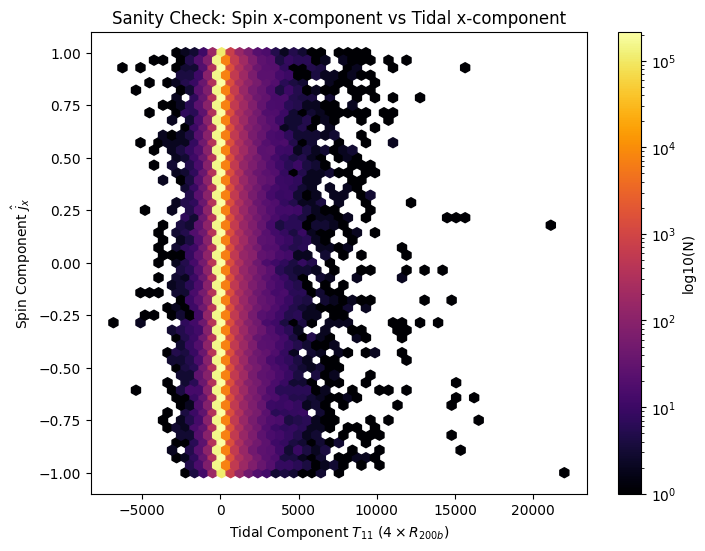

In [ ]:
check_cols = ['jx_u', 'jy_u', 'jz_u',
              'tens11_R4R200b', 'tens22_R4R200b', 'tens33_R4R200b']

corr_matrix = df[check_cols].corr()

spin_vs_tensor = corr_matrix.loc[['jx_u', 'jy_u', 'jz_u'],
                                 ['tens11_R4R200b', 'tens22_R4R200b', 'tens33_R4R200b']]

print("\nCorrelation Matrix (Spin Direction vs Tidal Component):")
print(spin_vs_tensor)

plt.figure(figsize=(8, 6))

plt.hexbin(df['tens11_R4R200b'], df['jx_u'], gridsize=50, cmap='inferno', bins='log', mincnt=1)
plt.xlabel(r'Tidal Component $T_{11}$ ($4 \times R_{200b}$)')
plt.ylabel(r'Spin Component $\hat{j}_x$')
plt.title('Sanity Check: Spin x-component vs Tidal x-component')
plt.colorbar(label='log10(N)')
plt.show()

Correlation Matrix: All Spin Components vs All Tidal Tensor Components
      tens11_R4R200b  tens22_R4R200b  tens33_R4R200b  tens12_R4R200b  \
jx_u        0.000544        0.000699        0.000651        0.000562   
jy_u        0.000266        0.000060        0.000021       -0.000191   
jz_u        0.000256        0.000718        0.000807       -0.000202   

      tens13_R4R200b  tens23_R4R200b  
jx_u       -0.000073        0.000365  
jy_u       -0.000285        0.000650  
jz_u        0.000025        0.000673  


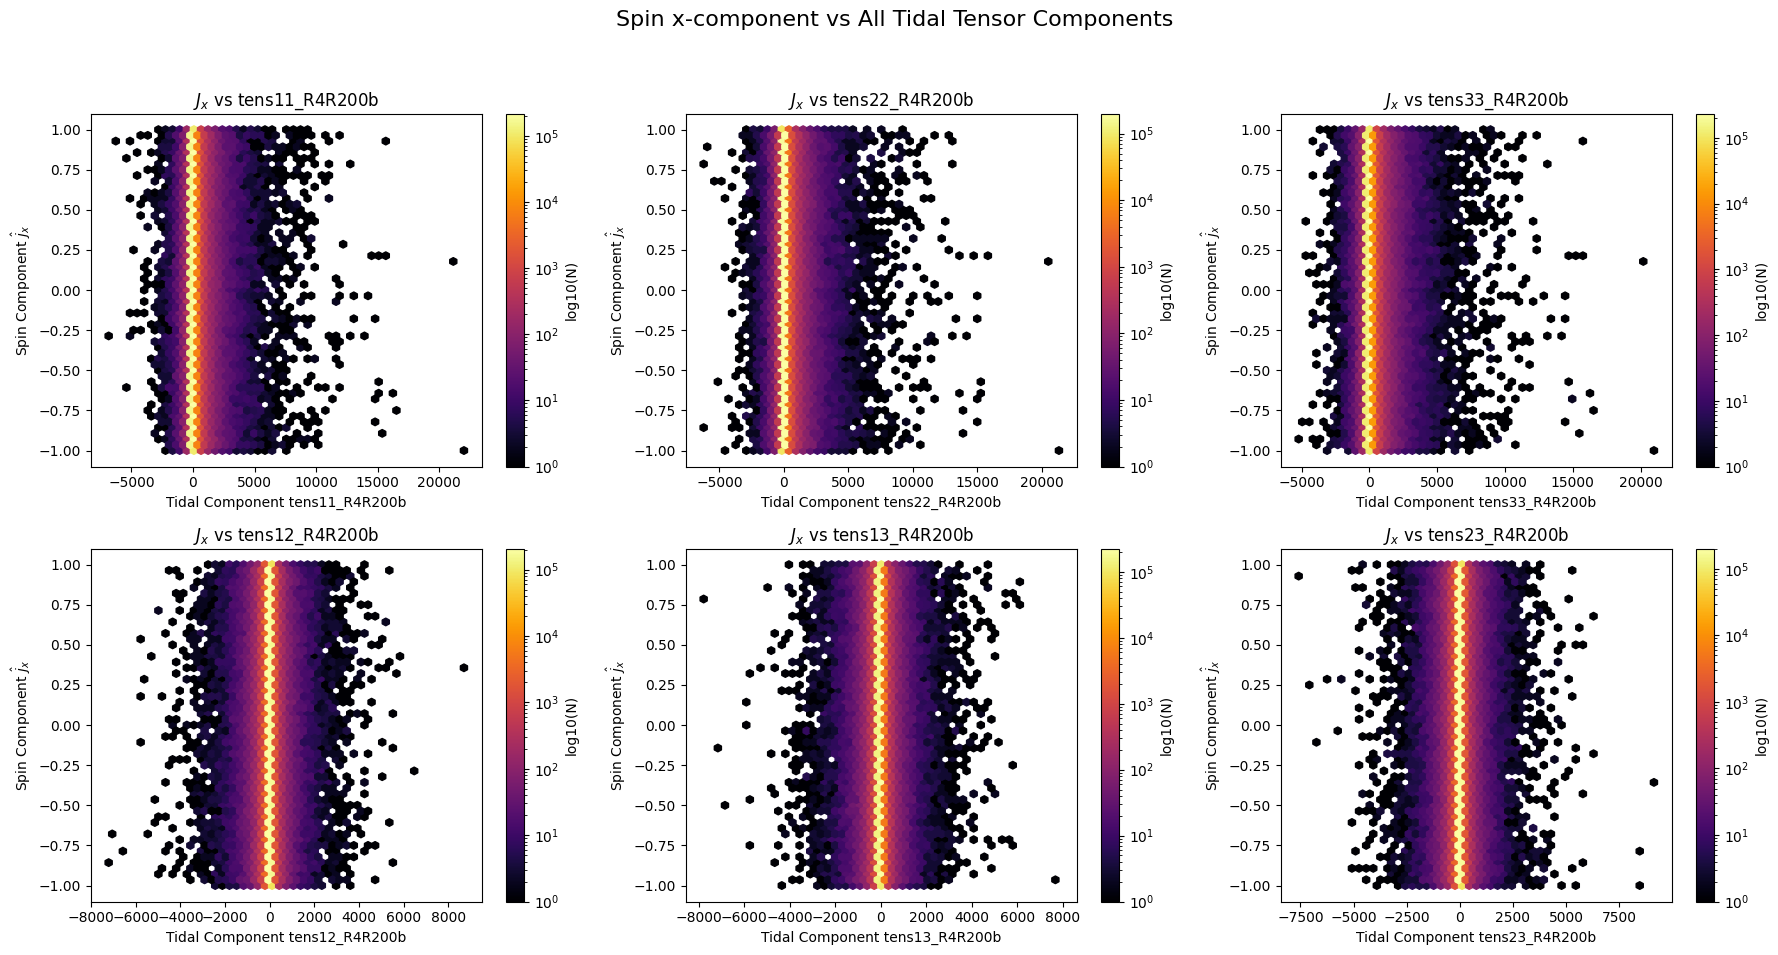

In [ ]:
spin_cols = ['jx_u', 'jy_u', 'jz_u']

tensor_cols = ['tens11_R4R200b', 'tens22_R4R200b', 'tens33_R4R200b',
               'tens12_R4R200b', 'tens13_R4R200b', 'tens23_R4R200b']

check_cols = spin_cols + tensor_cols
corr_matrix_full = df[check_cols].corr()

spin_tensor_corr = corr_matrix_full.loc[spin_cols, tensor_cols]

print("Correlation Matrix: All Spin Components vs All Tidal Tensor Components")
print(spin_tensor_corr)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, t_col in enumerate(tensor_cols):
    ax = axes[i]

    hb = ax.hexbin(df[t_col], df['jx_u'], gridsize=50, cmap='inferno', bins='log', mincnt=1)

    ax.set_xlabel(f'Tidal Component {t_col}')
    ax.set_ylabel(r'Spin Component $\hat{j}_x$')
    ax.set_title(f'$J_x$ vs {t_col}')

    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('log10(N)')

plt.suptitle('Spin x-component vs All Tidal Tensor Components', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Analyzing 10 mass bins...
(1513454, 13)
(556347, 13)
(201638, 13)
(72241, 13)
(25965, 13)
(9214, 13)
(3124, 13)
(925, 13)
(210, 13)
(32, 13)


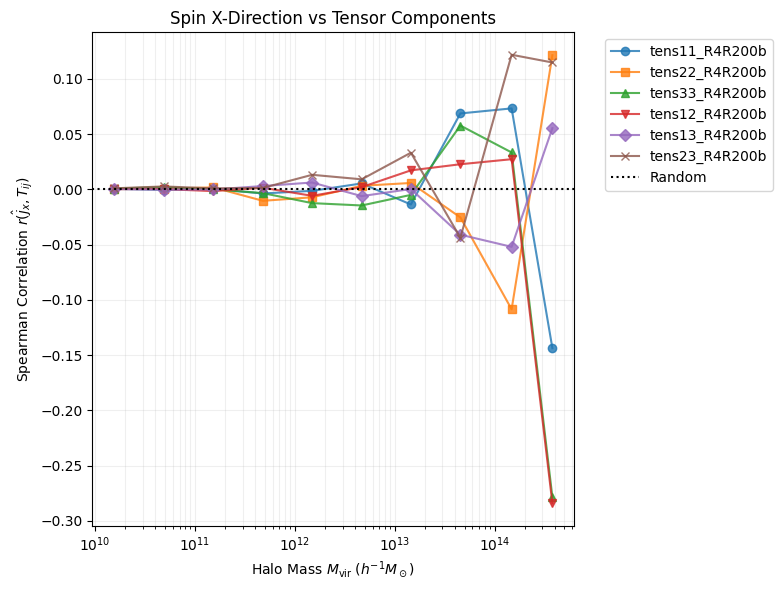

In [ ]:
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

def run_jx_tensor_correlations(df, min_n_for_stat=30):
    df1 = df.copy()
    tensor_cols = ['tens11_R4R200b', 'tens22_R4R200b', 'tens33_R4R200b',
                   'tens12_R4R200b', 'tens13_R4R200b', 'tens23_R4R200b']
    props = [c for c in tensor_cols if c in df1.columns]
    if not props:
        raise RuntimeError(f"None of the tensor columns {tensor_cols} found in dataframe.")

    df1['Mvir'] = df1['Mvir'].astype(float)
    df1['logMvir'] = np.log10(df1['Mvir'])

    mass_cut = 1e10
    df1 = df1[df1['Mvir'] > mass_cut].copy()
    logmin = df1['logMvir'].min()
    logmax = df1['logMvir'].max()
    edges = np.linspace(logmin, logmax, 11)
    df1['mbin'] = pd.cut(df1['logMvir'], bins=edges, labels=False, include_lowest=True)
    df1 = df1.dropna(subset=['mbin', 'jx_u']).copy()
    df1['mbin'] = df1['mbin'].astype(int)

    bins = np.sort(df1['mbin'].unique())
    n_bins = len(bins)

    r_results = {col: np.full(n_bins, np.nan) for col in props}
    bin_median_M = np.full(n_bins, np.nan)

    print(f"Analyzing {n_bins} mass bins...")

    for i, mbin in enumerate(bins):
        bin_df = df1[df1['mbin'] == mbin]
        print(bin_df.shape)
        bin_median_M[i] = bin_df['Mvir'].median()

        for col in props:
            mask = (~np.isnan(bin_df['jx_u'])) & (~np.isnan(bin_df[col]))
            if mask.sum() >= min_n_for_stat:
                r, _ = spearmanr(bin_df['jx_u'][mask], bin_df[col][mask])
                r_results[col][i] = r
            else:
                r_results[col][i] = np.nan

    valid = ~np.isnan(bin_median_M)
    x = bin_median_M[valid]

    fig, ax = plt.subplots(figsize=(8, 6))

    markers = ['o', 's', '^', 'v', 'D', 'x']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

    for idx, col in enumerate(props):
        y = r_results[col][valid]
        ax.plot(x, y, marker=markers[idx % len(markers)],
                color=colors[idx % len(colors)],
                linestyle='-', label=col, alpha=0.8)
    ax.axhline(0, color='black', linestyle=':', linewidth=1.5, label='Random')

    ax.set_xscale('log')
    ax.set_xlabel(r'Halo Mass $M_{\rm vir}\; (h^{-1}M_\odot)$')
    ax.set_ylabel(r'Spearman Correlation $r(\hat{j}_x, T_{ij})$')
    ax.set_title('Spin X-Direction vs Tensor Components')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, which="both", ls="-", alpha=0.2)

    plt.tight_layout()
    plt.show()


    del df1
    gc.collect()

run_jx_tensor_correlations(df)

# In eigen-frame

In [ ]:
import numpy as np
import pandas as pd
import gc

def calculate_and_append_alignments(df):
    print("--- Starting Alignment Calculation ---")

    t11 = df['tens11_R4R200b'].values
    t22 = df['tens22_R4R200b'].values
    t33 = df['tens33_R4R200b'].values
    t12 = df['tens12_R4R200b'].values
    t13 = df['tens13_R4R200b'].values
    t23 = df['tens23_R4R200b'].values

    spin_vectors = df[['jx_u', 'jy_u', 'jz_u']].values

    N = len(df)
    print(f"Constructing matrices for {N} halos...")

    T_matrices = np.empty((N, 3, 3))

    T_matrices[:, 0, 0] = t11
    T_matrices[:, 1, 1] = t22
    T_matrices[:, 2, 2] = t33
    T_matrices[:, 0, 1] = t12; T_matrices[:, 1, 0] = t12
    T_matrices[:, 0, 2] = t13; T_matrices[:, 2, 0] = t13
    T_matrices[:, 1, 2] = t23; T_matrices[:, 2, 1] = t23

    print("Diagonalizing matrices...")
    # np.linalg.eigh is for symmetric matrices.
    # Returns eigenvalues sorted ascending (lambda1 <= lambda2 <= lambda3).
    # evecs[:, :, i] corresponds to the i-th eigenvalue.
    evals, evecs = np.linalg.eigh(T_matrices)

    # evecs[:, :, 0] -> e1 (Filament Axis / Slowest Collapse)
    # evecs[:, :, 2] -> e3 (Collapse Axis / Fastest Collapse)

    # 4. Compute Alignments (Dot Products)
    print("Calculating alignment angles...")


    mu_1 = np.abs(np.einsum('ij,ij->i', spin_vectors, evecs[:, :, 0]))
    mu_2 = np.abs(np.einsum('ij,ij->i', spin_vectors, evecs[:, :, 1]))
    mu_3 = np.abs(np.einsum('ij,ij->i', spin_vectors, evecs[:, :, 2]))

    # 5. Append to DataFrame
    df['mu_1'] = mu_1
    df['mu_2'] = mu_2
    df['mu_3'] = mu_3

    print("Success! Added columns 'mu_1', 'mu_2', 'mu_3'.")
    print(df[['mu_1', 'mu_2', 'mu_3']].head())

    # Clean up memory
    del T_matrices, evals, evecs, t11, t22, t33, t12, t13, t23, spin_vectors
    gc.collect()

    return df

# --- Execute ---
df = calculate_and_append_alignments(df)

--- Starting Alignment Calculation ---
Constructing matrices for 10549241 halos...
Diagonalizing matrices...
Calculating alignment angles...
Success! Added columns 'mu_1', 'mu_2', 'mu_3'.
       mu_1      mu_2      mu_3
0  0.302348  0.554849  0.775067
1  0.836629  0.536083  0.112552
2  0.026044  0.615947  0.787357
3  0.985655  0.164592  0.037318
4  0.106908  0.696849  0.709205


In [ ]:
print(df.columns)

Index(['id', 'Mvir', 'tens11_R4R200b', 'tens22_R4R200b', 'tens33_R4R200b',
       'tens12_R4R200b', 'tens13_R4R200b', 'tens23_R4R200b', 'jx_u', 'jy_u',
       'jz_u', 'mu_1', 'mu_2', 'mu_3'],
      dtype='object')


In [ ]:
df[['mu_1','mu_2','mu_3']].describe()


mu_1          mu_2          mu_3
count  1.054497e+07  1.054497e+07  1.054497e+07
mean   5.037416e-01  4.994296e-01  4.958576e-01
std    2.898299e-01  2.890530e-01  2.887677e-01
min    1.005877e-08  4.259573e-08  1.038845e-08
25%    2.524199e-01  2.488829e-01  2.453485e-01
50%    5.052743e-01  4.988653e-01  4.933615e-01
75%    7.560683e-01  7.498665e-01  7.455298e-01
max    9.999999e-01  9.999998e-01  1.000000e+00

# All haloes

/tmp/ipython-input-499749386.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proc['mbin'] = pd.cut(df_proc['logMvir'], bins=edges, labels=False, include_lowest=True)
/tmp/ipython-input-499749386.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proc['temp_mu1'] = mu1
/tmp/ipython-input-499749386.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

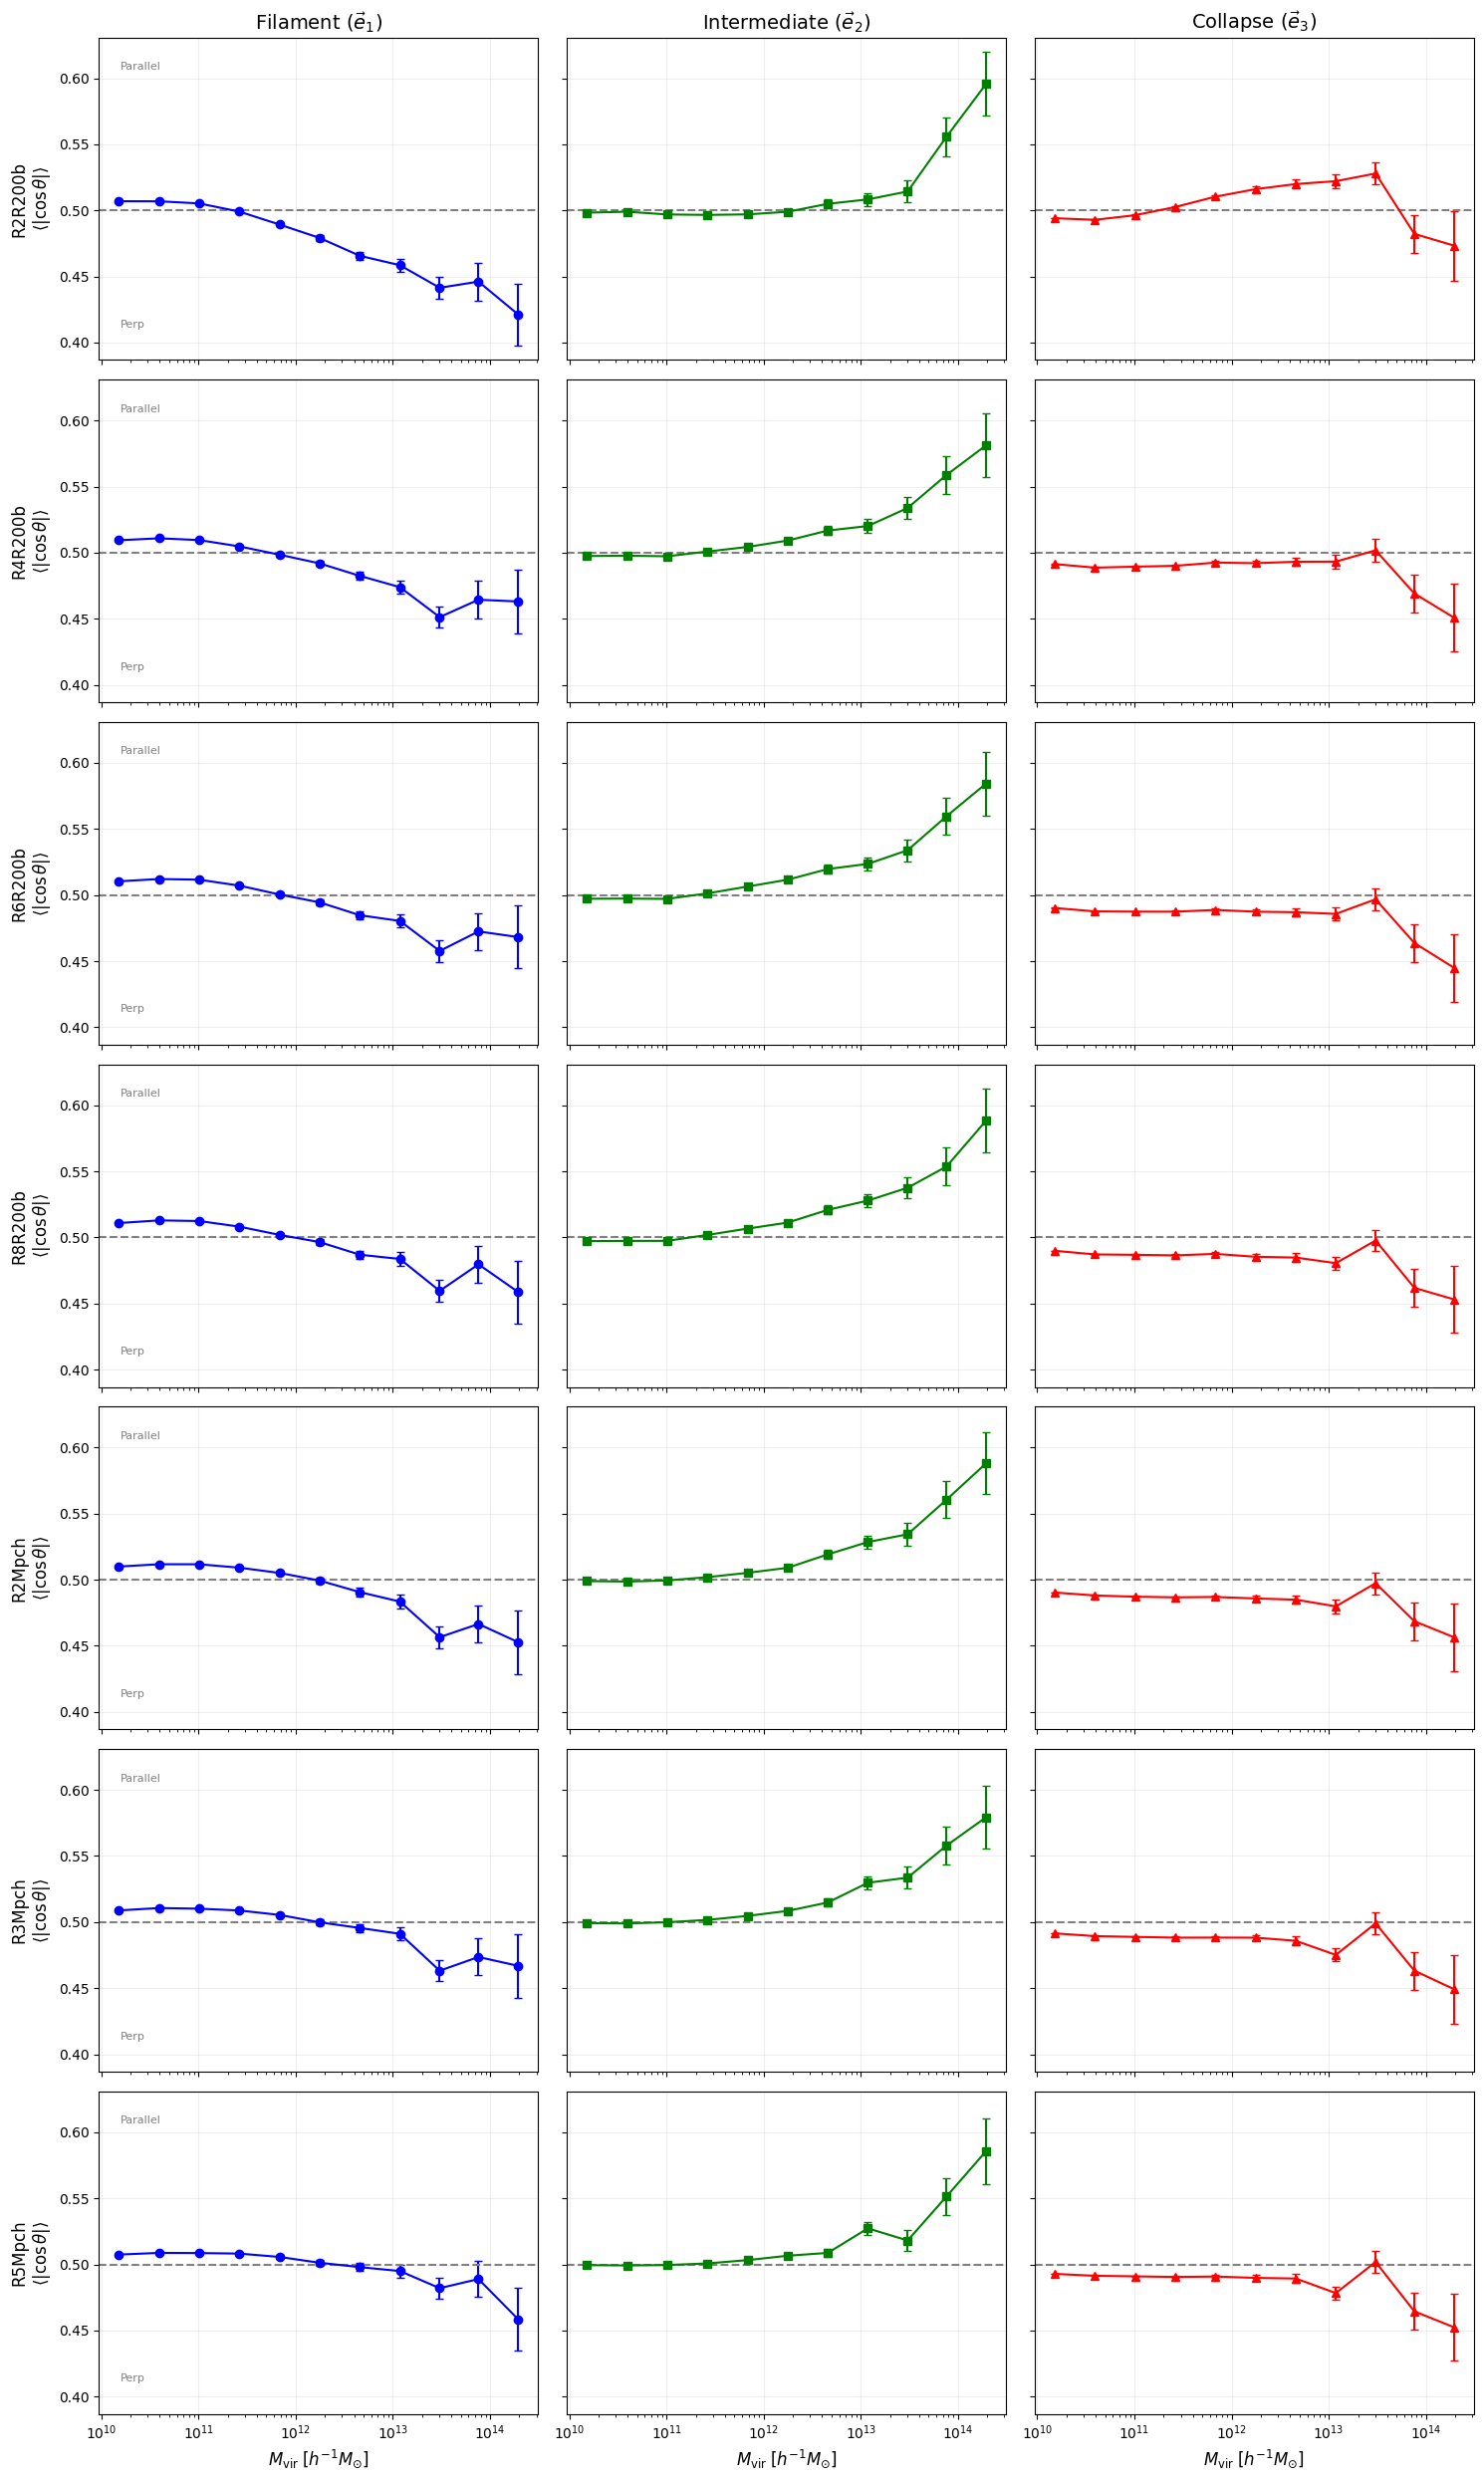

In [ ]:
def calculate_alignment_for_scale(df, suffix):
    if f'tens11{suffix}' not in df.columns:
        return None, None, None

    t11 = df[f'tens11{suffix}'].values
    t22 = df[f'tens22{suffix}'].values
    t33 = df[f'tens33{suffix}'].values
    t12 = df[f'tens12{suffix}'].values
    t13 = df[f'tens13{suffix}'].values
    t23 = df[f'tens23{suffix}'].values

    spin_vectors = df[['jx_u', 'jy_u', 'jz_u']].values

    N = len(df)
    T_matrices = np.empty((N, 3, 3))
    T_matrices[:, 0, 0] = t11; T_matrices[:, 1, 1] = t22; T_matrices[:, 2, 2] = t33
    T_matrices[:, 0, 1] = t12; T_matrices[:, 1, 0] = t12
    T_matrices[:, 0, 2] = t13; T_matrices[:, 2, 0] = t13
    T_matrices[:, 1, 2] = t23; T_matrices[:, 2, 1] = t23

    evals, evecs = np.linalg.eigh(T_matrices)

    mu_1 = np.abs(np.einsum('ij,ij->i', spin_vectors, evecs[:, :, 0]))
    mu_2 = np.abs(np.einsum('ij,ij->i', spin_vectors, evecs[:, :, 1]))
    mu_3 = np.abs(np.einsum('ij,ij->i', spin_vectors, evecs[:, :, 2]))

    return mu_1, mu_2, mu_3

def plot_21_subplots(df, min_n=30):
    scales = ['_R2R200b', '_R4R200b', '_R6R200b', '_R8R200b',
              '_R2Mpch', '_R3Mpch', '_R5Mpch']

    df_proc = df
    df_proc['Mvir'] = df_proc['Mvir'].astype(float)
    df_proc['logMvir'] = np.log10(df_proc['Mvir'])
    df_proc = df_proc[df_proc['Mvir'] > 1e10]

    log_min = df_proc['logMvir'].min()
    log_max = df_proc['logMvir'].max()
    edges = np.linspace(log_min, log_max, 13)
    df_proc['mbin'] = pd.cut(df_proc['logMvir'], bins=edges, labels=False, include_lowest=True)

    sem = lambda x: x.std() / np.sqrt(x.count())

    fig, axes = plt.subplots(7, 3, figsize=(15, 25), sharex=True, sharey=True)

    for i, scale in enumerate(scales):
        mu1, mu2, mu3 = calculate_alignment_for_scale(df_proc, scale)

        if mu1 is None:
            continue

        df_proc['temp_mu1'] = mu1
        df_proc['temp_mu2'] = mu2
        df_proc['temp_mu3'] = mu3

        grouped = df_proc.groupby('mbin')
        stats = grouped.agg({
            'logMvir': 'mean',
            'temp_mu1': ['mean', sem, 'count'],
            'temp_mu2': ['mean', sem],
            'temp_mu3': ['mean', sem]
        })

        stats.columns = ['logM_mean', 'mu1_mean', 'mu1_err', 'count',
                         'mu2_mean', 'mu2_err', 'mu3_mean', 'mu3_err']
        stats['mass'] = 10 ** stats['logM_mean']
        stats = stats[stats['count'] >= min_n]

        # Plot e1 (Filament)
        ax1 = axes[i, 0]
        ax1.errorbar(stats['mass'], stats['mu1_mean'], yerr=stats['mu1_err'],
                     fmt='-o', color='blue', capsize=3)
        ax1.axhline(0.5, color='gray', linestyle='--')
        ax1.set_ylabel(f'{scale.strip("_")}\n' + r'$\langle |\cos \theta| \rangle$', fontsize=12)
        if i == 0: ax1.set_title(r'Filament ($\vec{e}_1$)', fontsize=14)
        ax1.text(0.05, 0.9, 'Parallel', transform=ax1.transAxes, fontsize=8, color='gray')
        ax1.text(0.05, 0.1, 'Perp', transform=ax1.transAxes, fontsize=8, color='gray')

        # Plot e2 (Intermediate)
        ax2 = axes[i, 1]
        ax2.errorbar(stats['mass'], stats['mu2_mean'], yerr=stats['mu2_err'],
                     fmt='-s', color='green', capsize=3)
        ax2.axhline(0.5, color='gray', linestyle='--')
        if i == 0: ax2.set_title(r'Intermediate ($\vec{e}_2$)', fontsize=14)

        # Plot e3 (Collapse)
        ax3 = axes[i, 2]
        ax3.errorbar(stats['mass'], stats['mu3_mean'], yerr=stats['mu3_err'],
                     fmt='-^', color='red', capsize=3)
        ax3.axhline(0.5, color='gray', linestyle='--')
        if i == 0: ax3.set_title(r'Collapse ($\vec{e}_3$)', fontsize=14)

    for ax in axes.flatten():
        ax.set_xscale('log')
        ax.grid(True, alpha=0.2)

    for ax in axes[-1, :]:
        ax.set_xlabel(r'$M_{\rm vir} \; [h^{-1} M_{\odot}]$', fontsize=12)

    plt.tight_layout()
    plt.show()

    del df_proc
    gc.collect()

plot_21_subplots(df)

# Filaments

--- Pre-processing ---
Halos with M > 1e10: 2383150
Gathering statistics across all scales...
Global Count Range: 83 - 1244849
Setting Plot Limits to: [58.099999999999994, 1867273.5]


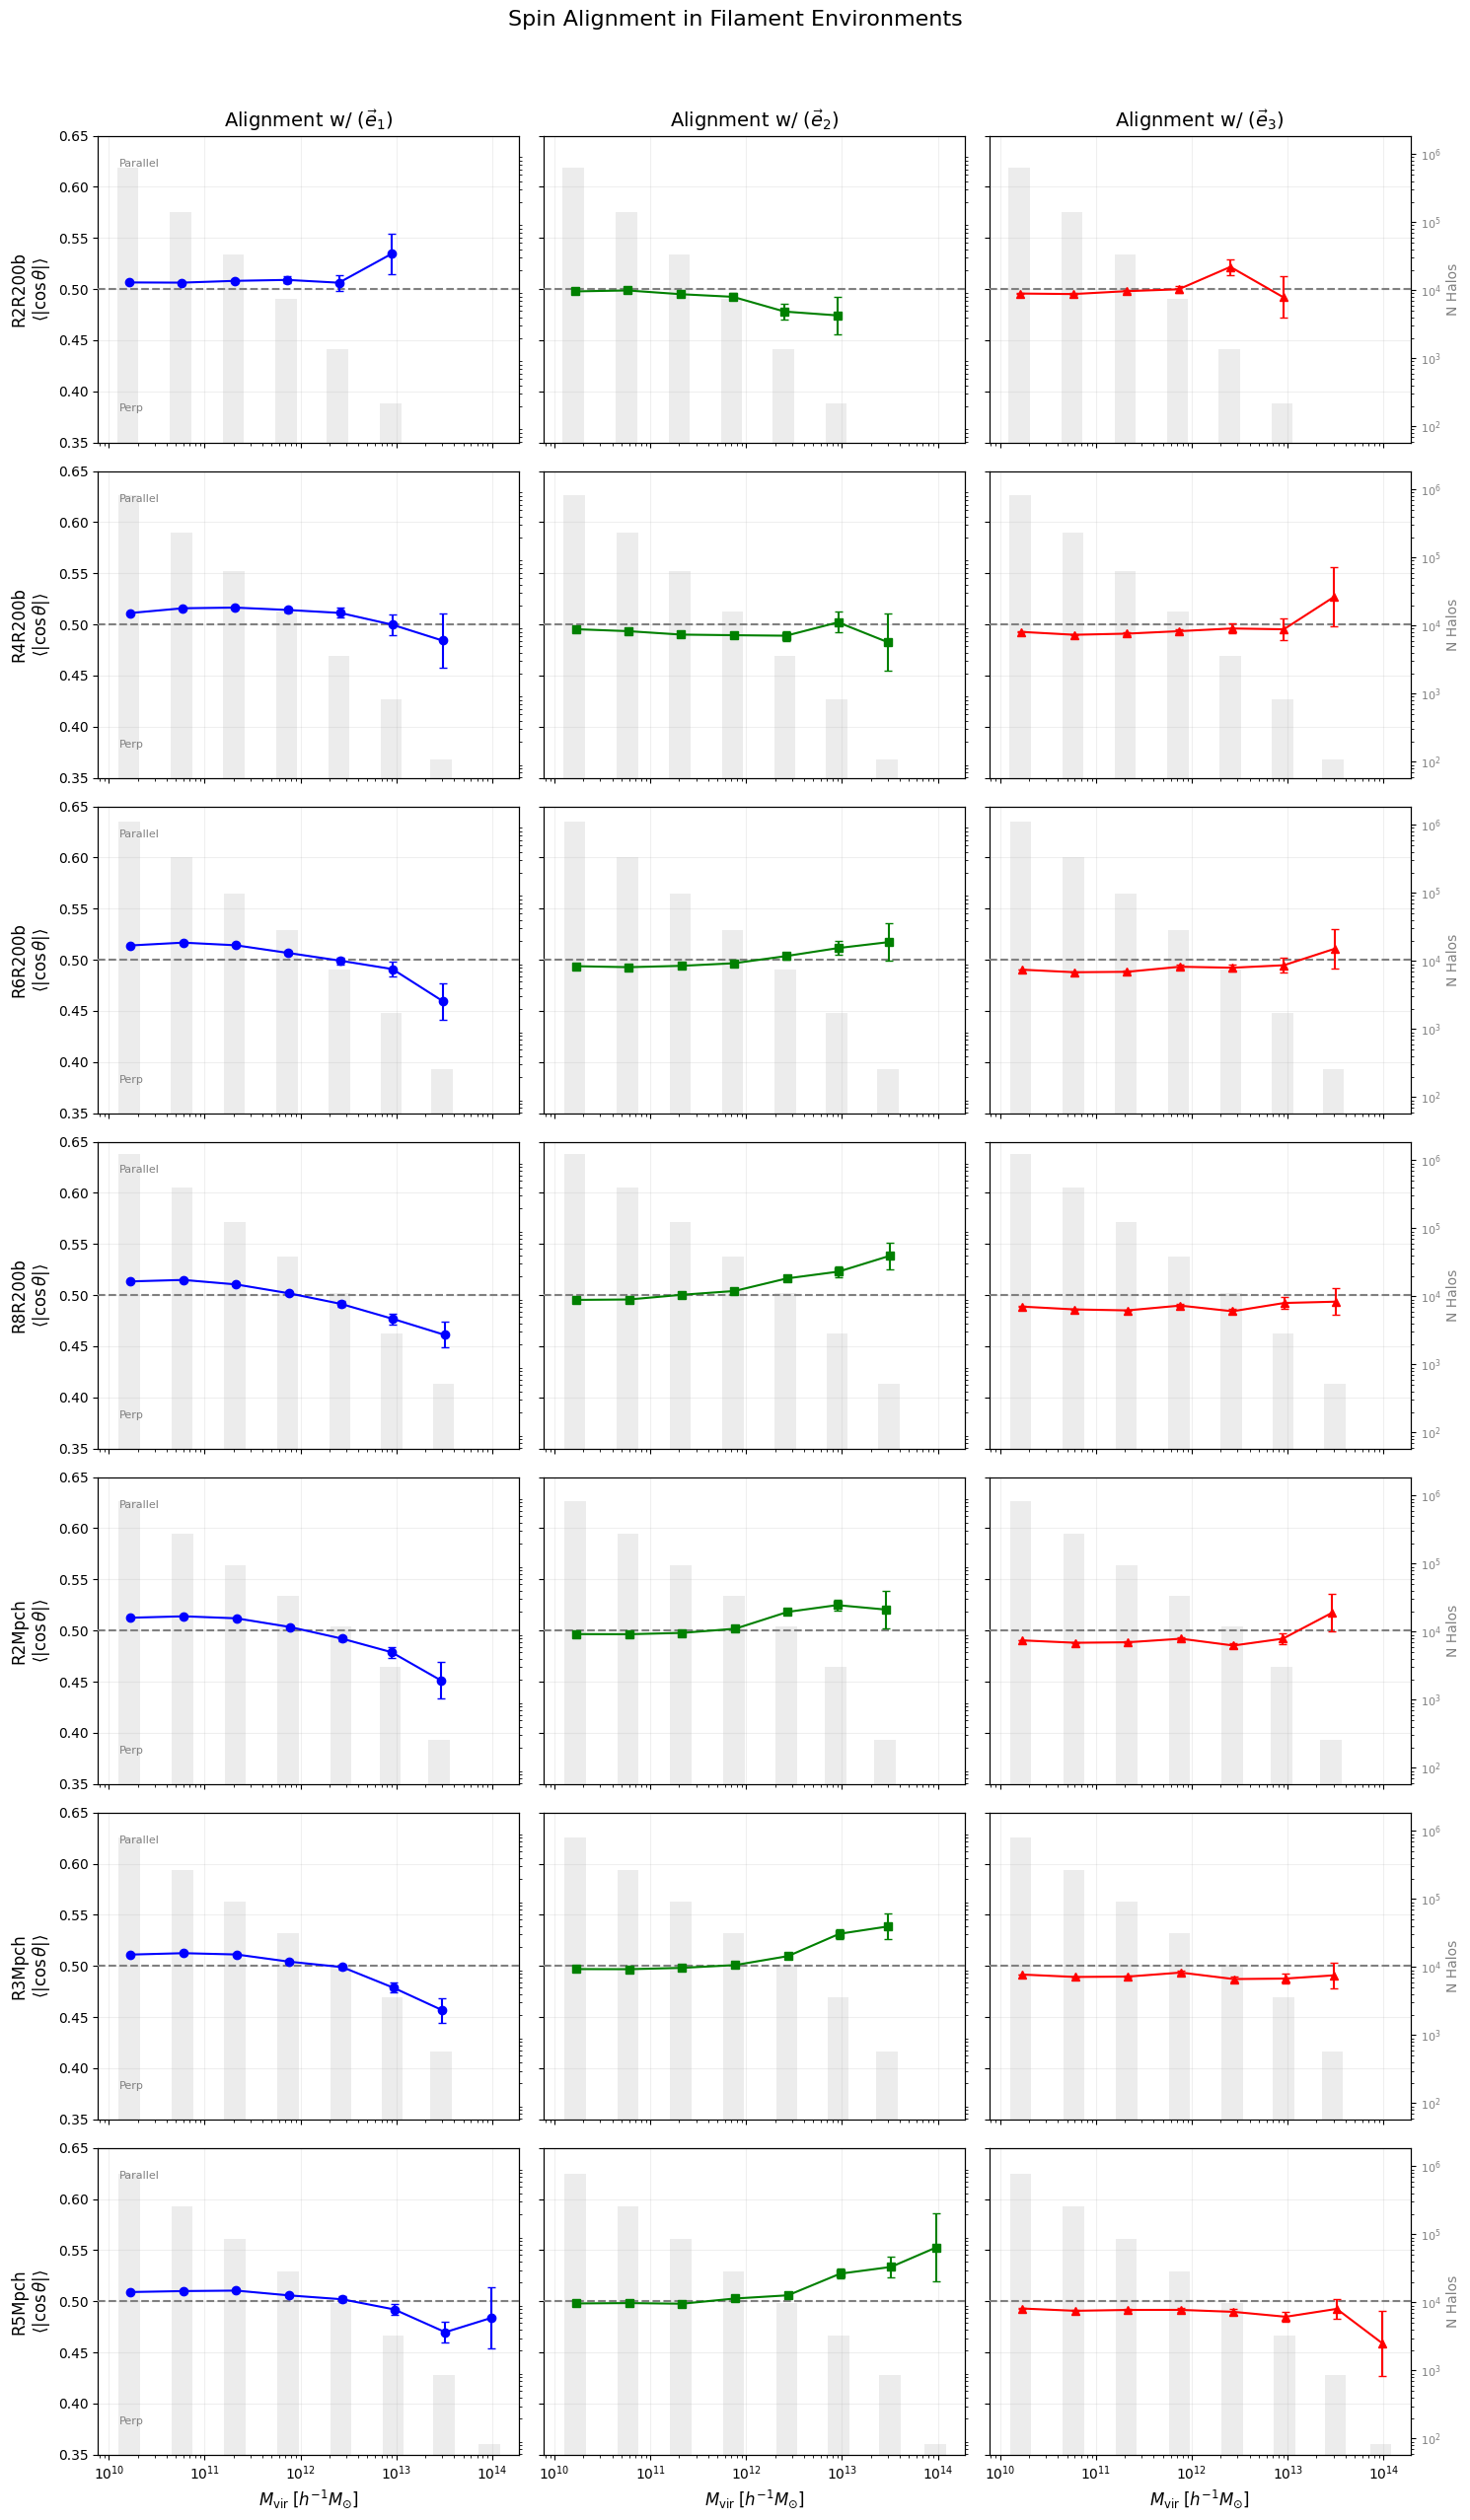

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

def get_filament_stats_no_copy(df, suffix, mass_mask, mbin_array, threshold=0):
    col_check = f'tens11{suffix}'
    if col_check not in df.columns:
        return None
    t11 = df.loc[mass_mask, f'tens11{suffix}'].values
    t22 = df.loc[mass_mask, f'tens22{suffix}'].values
    t33 = df.loc[mass_mask, f'tens33{suffix}'].values
    t12 = df.loc[mass_mask, f'tens12{suffix}'].values
    t13 = df.loc[mass_mask, f'tens13{suffix}'].values
    t23 = df.loc[mass_mask, f'tens23{suffix}'].values

    N = len(t11)
    T_matrices = np.empty((N, 3, 3))
    T_matrices[:, 0, 0] = t11; T_matrices[:, 1, 1] = t22; T_matrices[:, 2, 2] = t33
    T_matrices[:, 0, 1] = t12; T_matrices[:, 1, 0] = t12
    T_matrices[:, 0, 2] = t13; T_matrices[:, 2, 0] = t13
    T_matrices[:, 1, 2] = t23; T_matrices[:, 2, 1] = t23

    # 2. Diagonalize
    evals, evecs = np.linalg.eigh(T_matrices)

    # 3. Filter for Filaments (lambda1 <= 0, lambda2 > 0)
    is_filament = (evals[:, 1] > threshold) & (evals[:, 0] <= threshold)

    n_fil = np.sum(is_filament)
    if n_fil == 0:
        return None
    spin_subset = df.loc[mass_mask, ['jx_u', 'jy_u', 'jz_u']].values
    spin_final = spin_subset[is_filament]
    evecs_final = evecs[is_filament]

    mu_1 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 0]))
    mu_2 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 1]))
    mu_3 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 2]))

    mbin_final = mbin_array[is_filament]
    mass_final = df.loc[mass_mask, 'Mvir'].values[is_filament].astype(float)
    logM_final = np.log10(mass_final)

    stats_df = pd.DataFrame({
        'logMvir': logM_final,
        'mbin': mbin_final,
        'mu_1': mu_1,
        'mu_2': mu_2,
        'mu_3': mu_3
    })

    return stats_df, n_fil

def plot_filament_only_fixed_scales(df, min_n=50):
    scales = ['_R2R200b', '_R4R200b', '_R6R200b', '_R8R200b',
              '_R2Mpch', '_R3Mpch', '_R5Mpch']

    print("--- Pre-processing ---")
    mass_mask = (df['Mvir'].astype(float) > 1e10).values
    print(f"Halos with M > 1e10: {np.sum(mass_mask)}")

    valid_mass = df.loc[mass_mask, 'Mvir'].astype(float).values
    logM = np.log10(valid_mass)

    edges = np.linspace(logM.min(), logM.max(), 10)
    mbin_array = pd.cut(logM, bins=edges, labels=False, include_lowest=True)

    sem = lambda x: x.std() / np.sqrt(x.count())

    all_stats = []
    global_min_count = 1e9
    global_max_count = 0

    print("Gathering statistics across all scales...")
    for scale in scales:
        result = get_filament_stats_no_copy(df, scale, mass_mask, mbin_array)
        if result is None:
            all_stats.append(None)
            continue

        df_fil, n_fil = result

        grouped = df_fil.groupby('mbin')
        stats = grouped.agg({
            'logMvir': 'mean',
            'mu_1': ['mean', sem, 'count'],
            'mu_2': ['mean', sem],
            'mu_3': ['mean', sem]
        })
        stats.columns = ['logM_mean', 'mu1_mean', 'mu1_err', 'count',
                         'mu2_mean', 'mu2_err', 'mu3_mean', 'mu3_err']
        stats['mass'] = 10 ** stats['logM_mean']

        stats = stats[stats['count'] >= min_n]

        all_stats.append(stats)
        if not stats.empty:
            current_min = stats['count'].min()
            current_max = stats['count'].max()
            if current_min < global_min_count: global_min_count = current_min
            if current_max > global_max_count: global_max_count = current_max

    count_ylim = [global_min_count * 0.7, global_max_count * 1.5]
    print(f"Global Count Range: {global_min_count} - {global_max_count}")
    print(f"Setting Plot Limits to: {count_ylim}")

    # --- STEP 2: PLOTTING ---
    fig, axes = plt.subplots(7, 3, figsize=(15, 25), sharex=True, sharey=True)

    for i, scale in enumerate(scales):
        stats = all_stats[i]

        if stats is None or stats.empty:
            continue

        # --- Define Axes ---
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]
        ax3 = axes[i, 2]

        # --- Plot Background Counts (FIXED Y-LIM) ---
        for ax_curr in [ax1, ax2, ax3]:
            ax_cnt = ax_curr.twinx()

            # Bars
            ax_cnt.bar(stats['mass'], stats['count'], width=stats['mass']*0.5,
                       color='gray', alpha=0.15, zorder=0)

            ax_cnt.set_yscale('log')
            ax_cnt.set_ylim(count_ylim)  # <--- CRITICAL: FIXED LIMITS
            ax_cnt.grid(False)

            # Only show ticks on far right
            if ax_curr == ax3:
                ax_cnt.set_ylabel('N Halos', color='gray', fontsize=10)
                ax_cnt.tick_params(axis='y', labelcolor='gray', labelsize=8)
            else:
                ax_cnt.set_yticks([])

        # --- Plot Alignment Signal ---
        # Col 1: Filament
        ax1.errorbar(stats['mass'], stats['mu1_mean'], yerr=stats['mu1_err'],
                     fmt='-o', color='blue', capsize=3, zorder=10)
        ax1.axhline(0.5, color='gray', linestyle='--', zorder=5)
        ax1.set_ylabel(f'{scale.strip("_")}\n' + r'$\langle |\cos \theta| \rangle$', fontsize=12)

        # Col 2: Intermediate
        ax2.errorbar(stats['mass'], stats['mu2_mean'], yerr=stats['mu2_err'],
                     fmt='-s', color='green', capsize=3, zorder=10)
        ax2.axhline(0.5, color='gray', linestyle='--', zorder=5)

        # Col 3: Collapse
        ax3.errorbar(stats['mass'], stats['mu3_mean'], yerr=stats['mu3_err'],
                     fmt='-^', color='red', capsize=3, zorder=10)
        ax3.axhline(0.5, color='gray', linestyle='--', zorder=5)

        # Set consistent Alignment Limits for easy comparison
        ax1.set_ylim(0.35, 0.65) # Adjust this if your data goes outside

        # Titles
        if i == 0:
            ax1.set_title(r'Alignment w/ ($\vec{e}_1$)', fontsize=14)
            ax2.set_title(r'Alignment w/ ($\vec{e}_2$)', fontsize=14)
            ax3.set_title(r'Alignment w/ ($\vec{e}_3$)', fontsize=14)

        ax1.text(0.05, 0.9, 'Parallel', transform=ax1.transAxes, fontsize=8, color='gray')
        ax1.text(0.05, 0.1, 'Perp', transform=ax1.transAxes, fontsize=8, color='gray')

    # Formatting
    for ax in axes.flatten():
        ax.set_xscale('log')
        ax.grid(True, alpha=0.2)
        ax.set_zorder(1)
        ax.patch.set_visible(False)

    for ax in axes[-1, :]:
        ax.set_xlabel(r'$M_{\rm vir} \; [h^{-1} M_{\odot}]$', fontsize=12)

    plt.suptitle('Spin Alignment in Filament Environments', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    del valid_mass, logM, mbin_array, mass_mask
    gc.collect()

# --- Run ---
plot_filament_only_fixed_scales(df, min_n=50)

# Voids

--- Pre-processing for VOIDS ---
Halos with M > 1e10: 2383150
Gathering statistics across all scales...
Global Count Range: 53 - 61538
Setting Plot Limits to: [37.099999999999994, 92307.0]


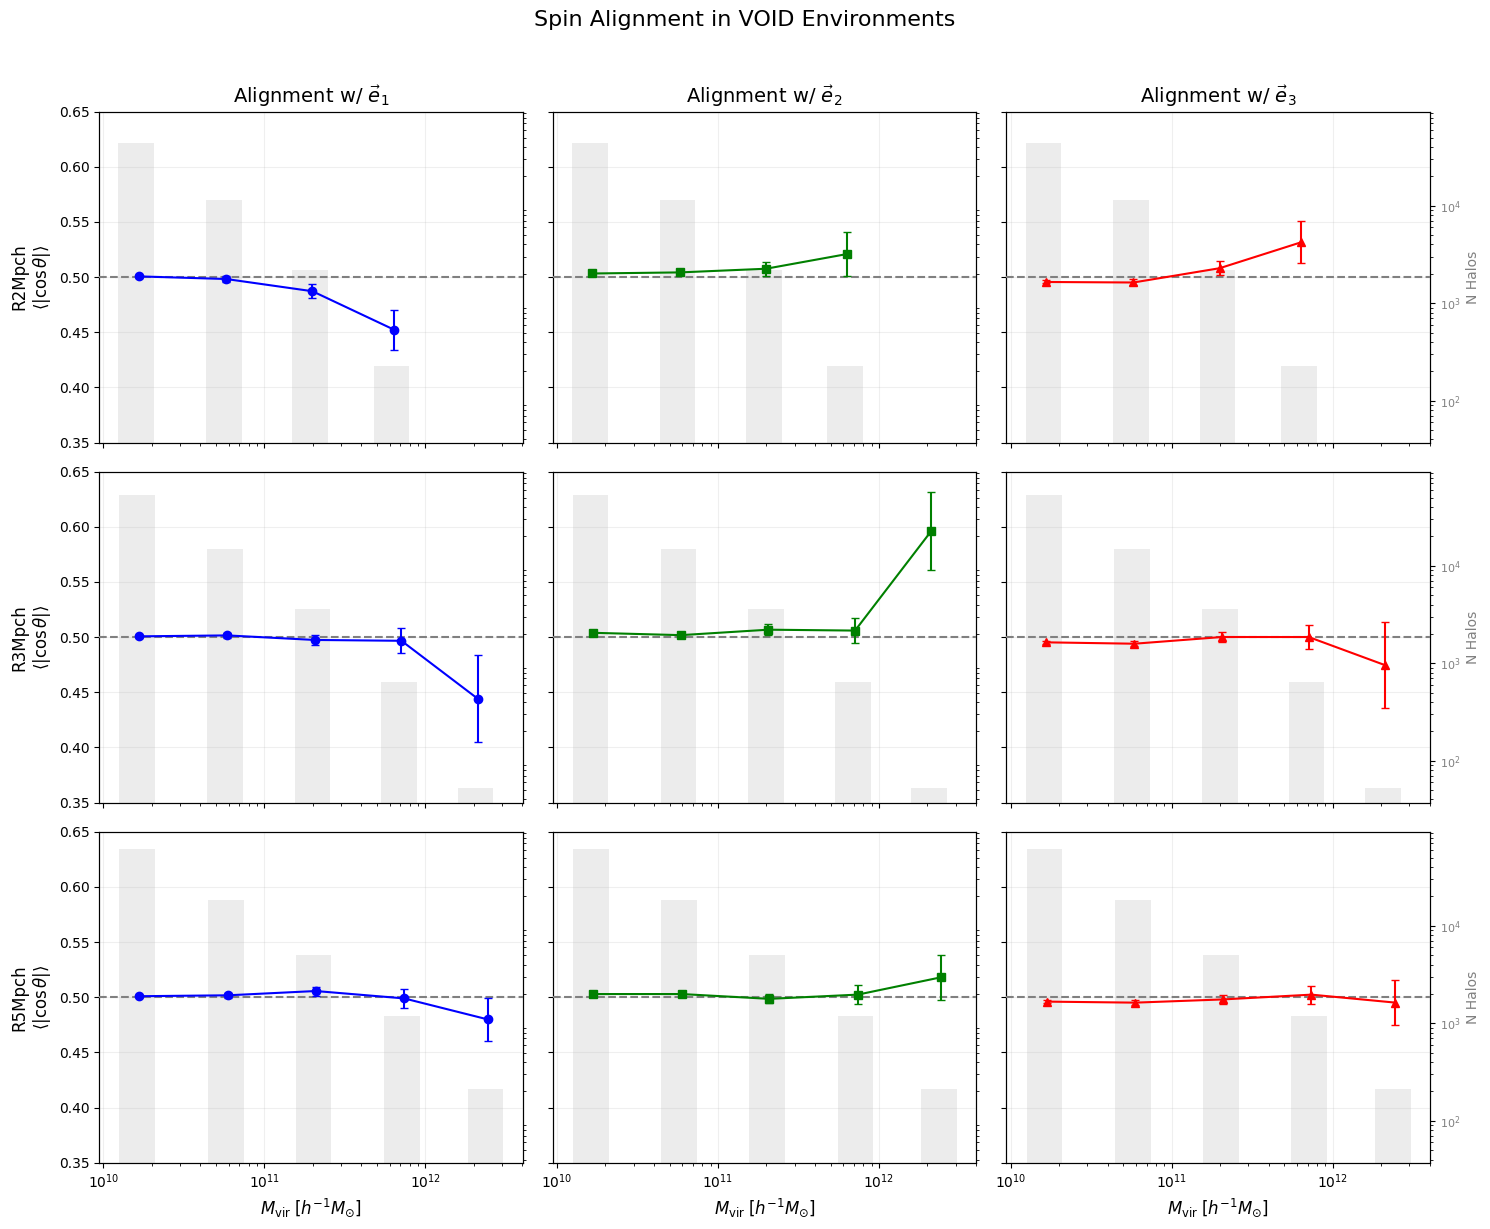

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

def get_void_stats_no_copy(df, suffix, mass_mask, mbin_array, threshold=0):
    """
    Calculates alignment statistics for VOIDS using the original dataframe
    and boolean masks to avoid data duplication.
    """
    col_check = f'tens11{suffix}'
    if col_check not in df.columns:
        return None

    # 1. Extract Tensor Components (Only for the mass-masked rows)
    t11 = df.loc[mass_mask, f'tens11{suffix}'].values
    t22 = df.loc[mass_mask, f'tens22{suffix}'].values
    t33 = df.loc[mass_mask, f'tens33{suffix}'].values
    t12 = df.loc[mass_mask, f'tens12{suffix}'].values
    t13 = df.loc[mass_mask, f'tens13{suffix}'].values
    t23 = df.loc[mass_mask, f'tens23{suffix}'].values

    N = len(t11)
    T_matrices = np.empty((N, 3, 3))
    T_matrices[:, 0, 0] = t11; T_matrices[:, 1, 1] = t22; T_matrices[:, 2, 2] = t33
    T_matrices[:, 0, 1] = t12; T_matrices[:, 1, 0] = t12
    T_matrices[:, 0, 2] = t13; T_matrices[:, 2, 0] = t13
    T_matrices[:, 1, 2] = t23; T_matrices[:, 2, 1] = t23

    # 2. Diagonalize
    evals, evecs = np.linalg.eigh(T_matrices)

    # 3. Filter for VOIDS
    # Void Definition: All 3 eigenvalues are <= threshold (Expansion in all directions)
    is_void = (evals[:, 2] <= threshold)

    n_void = np.sum(is_void)
    if n_void == 0:
        return None

    # 4. Extract Spin and Mass for Void Halos Only
    spin_subset = df.loc[mass_mask, ['jx_u', 'jy_u', 'jz_u']].values
    spin_final = spin_subset[is_void]
    evecs_final = evecs[is_void]

    # 5. Calculate Alignments
    mu_1 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 0]))
    mu_2 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 1]))
    mu_3 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 2]))

    # 6. Retrieve Mass and Bin info
    mbin_final = mbin_array[is_void]
    mass_final = df.loc[mass_mask, 'Mvir'].values[is_void].astype(float)
    logM_final = np.log10(mass_final)

    stats_df = pd.DataFrame({
        'logMvir': logM_final,
        'mbin': mbin_final,
        'mu_1': mu_1,
        'mu_2': mu_2,
        'mu_3': mu_3
    })

    return stats_df, n_void

def plot_void_only_fixed_scales(df, min_n=50):
    scales = ['_R2Mpch', '_R3Mpch', '_R5Mpch']

    print("--- Pre-processing for VOIDS ---")
    mass_mask = (df['Mvir'].astype(float) > 1e10).values
    print(f"Halos with M > 1e10: {np.sum(mass_mask)}")

    valid_mass = df.loc[mass_mask, 'Mvir'].astype(float).values
    logM = np.log10(valid_mass)

    # Define Bins
    edges = np.linspace(logM.min(), logM.max(), 10)
    mbin_array = pd.cut(logM, bins=edges, labels=False, include_lowest=True)

    sem = lambda x: x.std() / np.sqrt(x.count())

    # --- STEP 1: PRE-CALCULATE STATS TO FIND GLOBAL MAX/MIN COUNTS ---
    all_stats = []
    global_min_count = 1e9
    global_max_count = 0

    print("Gathering statistics across all scales...")
    for scale in scales:
        result = get_void_stats_no_copy(df, scale, mass_mask, mbin_array)

        if result is None:
            all_stats.append(None)
            continue

        df_void, n_void = result

        grouped = df_void.groupby('mbin')
        stats = grouped.agg({
            'logMvir': 'mean',
            'mu_1': ['mean', sem, 'count'],
            'mu_2': ['mean', sem],
            'mu_3': ['mean', sem]
        })

        stats.columns = ['logM_mean', 'mu1_mean', 'mu1_err', 'count',
                         'mu2_mean', 'mu2_err', 'mu3_mean', 'mu3_err']
        stats['mass'] = 10 ** stats['logM_mean']

        # Filter low counts
        stats = stats[stats['count'] >= min_n]

        all_stats.append(stats)

        # Update global limits
        if not stats.empty:
            current_min = stats['count'].min()
            current_max = stats['count'].max()
            if current_min < global_min_count: global_min_count = current_min
            if current_max > global_max_count: global_max_count = current_max

    # Pad limits for log plot
    count_ylim = [global_min_count * 0.7, global_max_count * 1.5]
    print(f"Global Count Range: {global_min_count} - {global_max_count}")
    print(f"Setting Plot Limits to: {count_ylim}")

    # --- STEP 2: PLOTTING ---
    fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

    for i, scale in enumerate(scales):
        stats = all_stats[i]

        if stats is None or stats.empty:
            continue

        # --- Define Axes ---
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]
        ax3 = axes[i, 2]

        # --- Plot Background Counts (FIXED Y-LIM) ---
        for ax_curr in [ax1, ax2, ax3]:
            ax_cnt = ax_curr.twinx()

            # Bars
            ax_cnt.bar(stats['mass'], stats['count'], width=stats['mass']*0.5,
                       color='gray', alpha=0.15, zorder=0)

            ax_cnt.set_yscale('log')
            ax_cnt.set_ylim(count_ylim)  # Fixed Scale
            ax_cnt.grid(False)

            if ax_curr == ax3:
                ax_cnt.set_ylabel('N Halos', color='gray', fontsize=10)
                ax_cnt.tick_params(axis='y', labelcolor='gray', labelsize=8)
            else:
                ax_cnt.set_yticks([])

        # --- Plot Alignment Signal ---
        # Col 1: e1 (Slowest Expansion)
        ax1.errorbar(stats['mass'], stats['mu1_mean'], yerr=stats['mu1_err'],
                     fmt='-o', color='blue', capsize=3, zorder=10)
        ax1.axhline(0.5, color='gray', linestyle='--', zorder=5)
        ax1.set_ylabel(f'{scale.strip("_")}\n' + r'$\langle |\cos \theta| \rangle$', fontsize=12)

        # Col 2: e2
        ax2.errorbar(stats['mass'], stats['mu2_mean'], yerr=stats['mu2_err'],
                     fmt='-s', color='green', capsize=3, zorder=10)
        ax2.axhline(0.5, color='gray', linestyle='--', zorder=5)

        # Col 3: e3 (Fastest Expansion)
        ax3.errorbar(stats['mass'], stats['mu3_mean'], yerr=stats['mu3_err'],
                     fmt='-^', color='red', capsize=3, zorder=10)
        ax3.axhline(0.5, color='gray', linestyle='--', zorder=5)

        # Set consistent Alignment Limits
        ax1.set_ylim(0.35, 0.65)

        # Titles
        if i == 0:
            ax1.set_title(r'Alignment w/ $\vec{e}_1$', fontsize=14)
            ax2.set_title(r'Alignment w/ $\vec{e}_2$', fontsize=14)
            ax3.set_title(r'Alignment w/ $\vec{e}_3$', fontsize=14)

    # Formatting
    for ax in axes.flatten():
        ax.set_xscale('log')
        ax.grid(True, alpha=0.2)
        ax.set_zorder(1)
        ax.patch.set_visible(False)

    for ax in axes[-1, :]:
        ax.set_xlabel(r'$M_{\rm vir} \; [h^{-1} M_{\odot}]$', fontsize=12)

    plt.suptitle('Spin Alignment in VOID Environments', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    del valid_mass, logM, mbin_array, mass_mask
    gc.collect()

# --- Run ---
plot_void_only_fixed_scales(df, min_n=50)

# Sheets

--- Pre-processing for SHEETS ---
Halos with M > 1e10: 2383150
Gathering statistics across all scales...
Global Count Range: 60 - 510024
Setting Plot Limits to: [42.0, 765036.0]


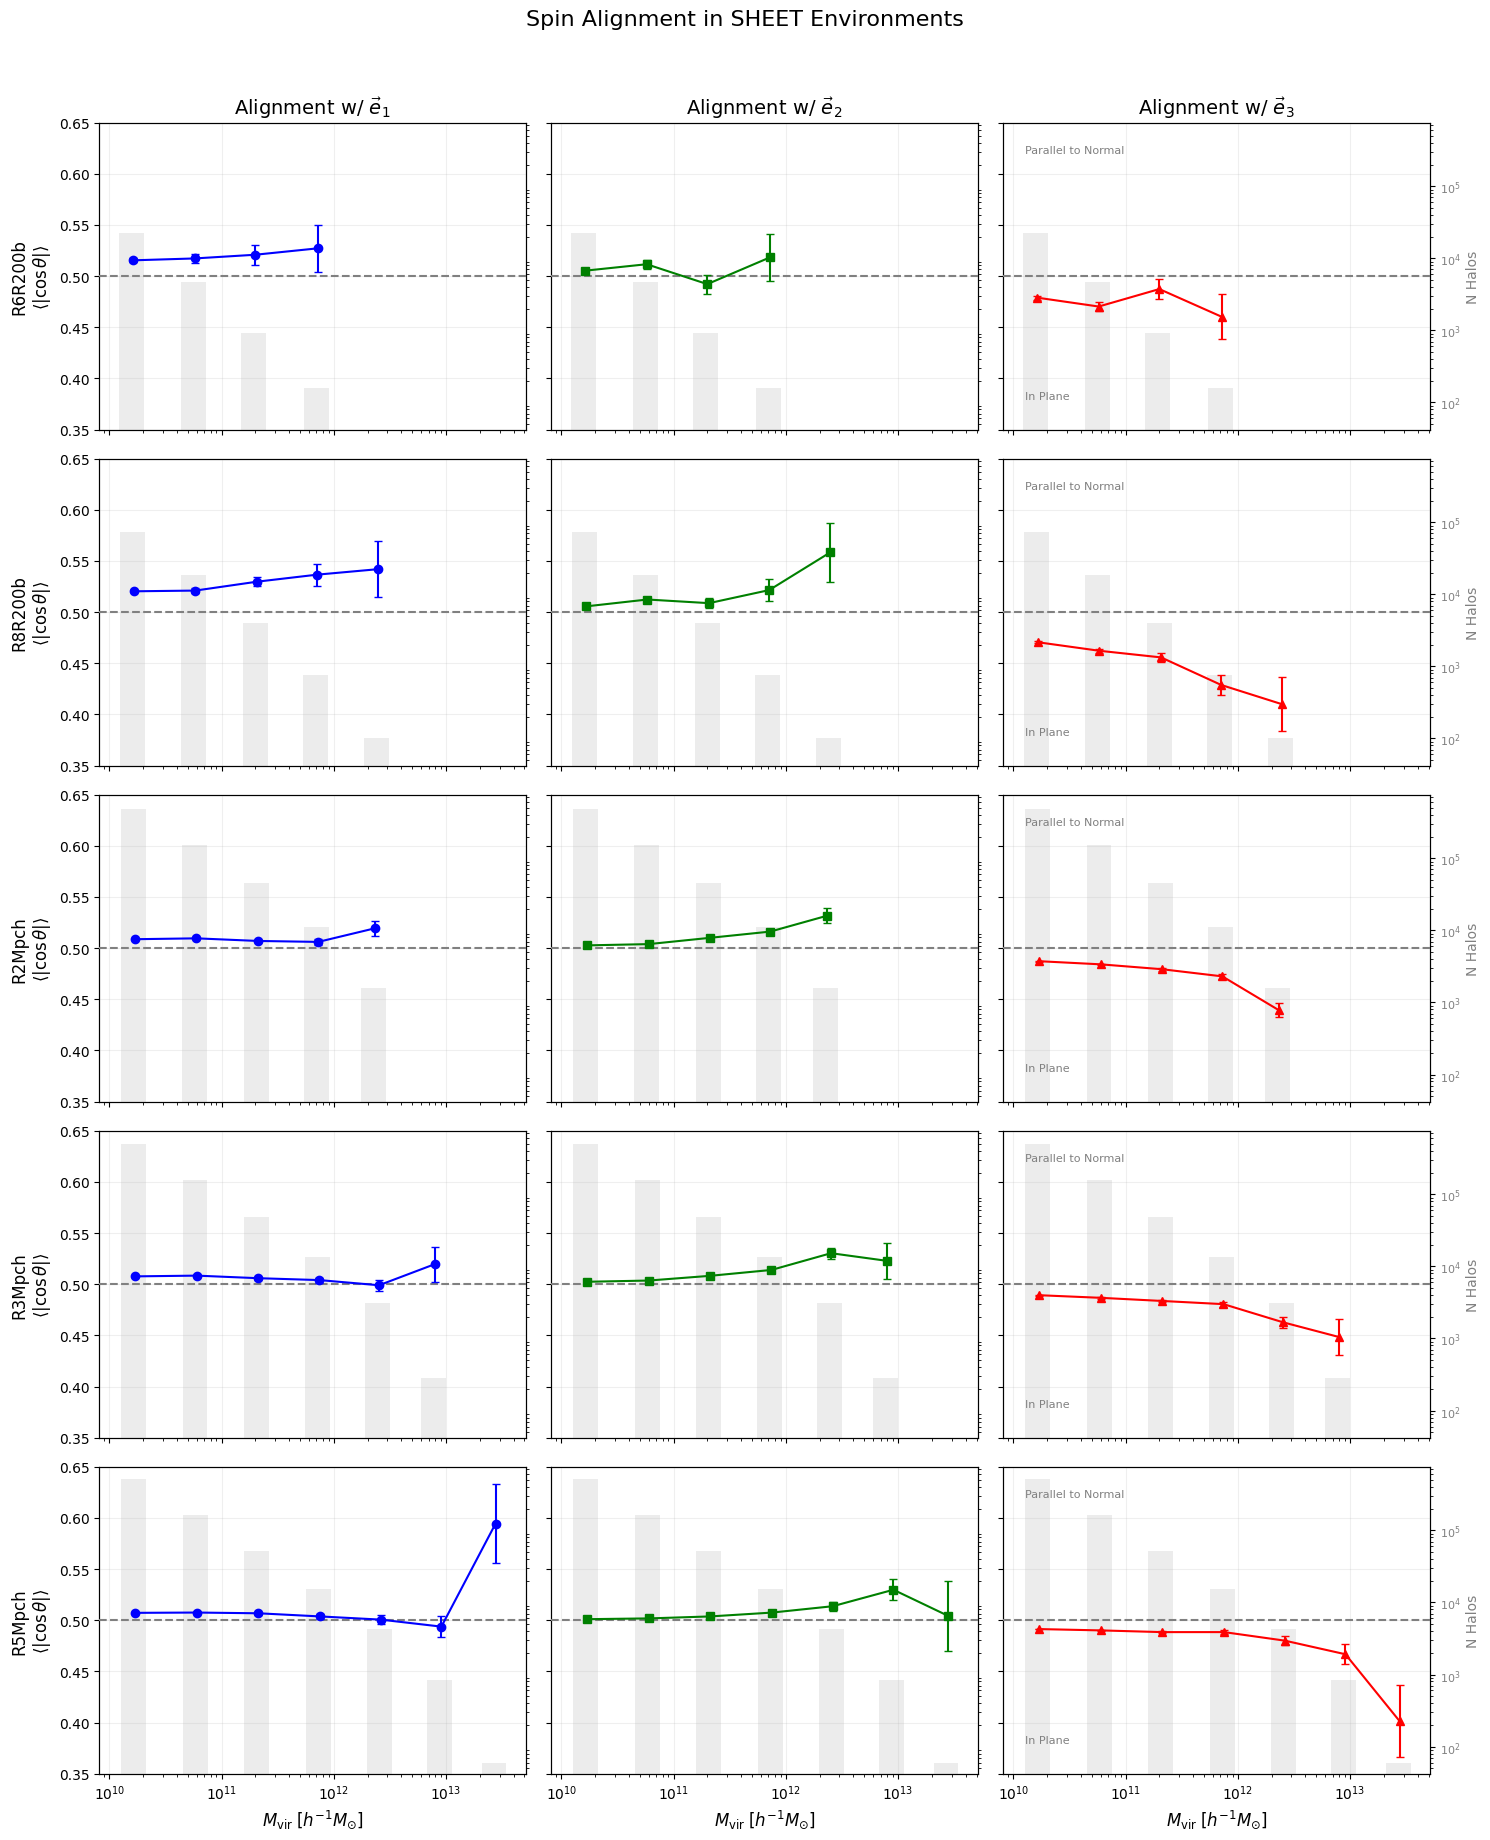

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

def get_sheet_stats_no_copy(df, suffix, mass_mask, mbin_array, threshold=0):
    """
    Calculates alignment statistics for SHEETS using the original dataframe.
    Sheet Definition: lambda3 > 0 (Collapse), lambda2 <= 0 (Expansion).
    """
    col_check = f'tens11{suffix}'
    if col_check not in df.columns:
        return None

    # 1. Extract Tensor Components (Only for valid mass rows)
    t11 = df.loc[mass_mask, f'tens11{suffix}'].values
    t22 = df.loc[mass_mask, f'tens22{suffix}'].values
    t33 = df.loc[mass_mask, f'tens33{suffix}'].values
    t12 = df.loc[mass_mask, f'tens12{suffix}'].values
    t13 = df.loc[mass_mask, f'tens13{suffix}'].values
    t23 = df.loc[mass_mask, f'tens23{suffix}'].values

    N = len(t11)
    T_matrices = np.empty((N, 3, 3))
    T_matrices[:, 0, 0] = t11; T_matrices[:, 1, 1] = t22; T_matrices[:, 2, 2] = t33
    T_matrices[:, 0, 1] = t12; T_matrices[:, 1, 0] = t12
    T_matrices[:, 0, 2] = t13; T_matrices[:, 2, 0] = t13
    T_matrices[:, 1, 2] = t23; T_matrices[:, 2, 1] = t23

    # 2. Diagonalize
    evals, evecs = np.linalg.eigh(T_matrices)

    # 3. Filter for SHEETS
    # Condition: 1 positive (collapse), 2 negative (expansion)
    # Sorted evals: lambda1 < lambda2 < lambda3
    # Therefore: lambda3 > threshold AND lambda2 <= threshold
    is_sheet = (evals[:, 2] > threshold) & (evals[:, 1] <= threshold)

    n_sheet = np.sum(is_sheet)
    if n_sheet == 0:
        return None

    # 4. Extract Spin and Mass
    spin_subset = df.loc[mass_mask, ['jx_u', 'jy_u', 'jz_u']].values
    spin_final = spin_subset[is_sheet]
    evecs_final = evecs[is_sheet]

    # 5. Calculate Alignments
    mu_1 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 0]))
    mu_2 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 1]))
    mu_3 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 2]))

    # 6. Retrieve Bin info
    mbin_final = mbin_array[is_sheet]
    mass_final = df.loc[mass_mask, 'Mvir'].values[is_sheet].astype(float)
    logM_final = np.log10(mass_final)

    stats_df = pd.DataFrame({
        'logMvir': logM_final,
        'mbin': mbin_final,
        'mu_1': mu_1,
        'mu_2': mu_2,
        'mu_3': mu_3
    })

    return stats_df, n_sheet

def plot_sheet_only_fixed_scales(df, min_n=50):
    scales = ['_R6R200b', '_R8R200b',
              '_R2Mpch', '_R3Mpch', '_R5Mpch']

    print("--- Pre-processing for SHEETS ---")
    mass_mask = (df['Mvir'].astype(float) > 1e10).values
    print(f"Halos with M > 1e10: {np.sum(mass_mask)}")

    valid_mass = df.loc[mass_mask, 'Mvir'].astype(float).values
    logM = np.log10(valid_mass)

    # Define Bins
    edges = np.linspace(logM.min(), logM.max(), 10)
    mbin_array = pd.cut(logM, bins=edges, labels=False, include_lowest=True)

    sem = lambda x: x.std() / np.sqrt(x.count())

    # --- STEP 1: PRE-CALCULATE STATS TO FIND GLOBAL MAX/MIN COUNTS ---
    all_stats = []
    global_min_count = 1e9
    global_max_count = 0

    print("Gathering statistics across all scales...")
    for scale in scales:
        result = get_sheet_stats_no_copy(df, scale, mass_mask, mbin_array)

        if result is None:
            all_stats.append(None)
            continue

        df_sheet, n_sheet = result

        grouped = df_sheet.groupby('mbin')
        stats = grouped.agg({
            'logMvir': 'mean',
            'mu_1': ['mean', sem, 'count'],
            'mu_2': ['mean', sem],
            'mu_3': ['mean', sem]
        })

        stats.columns = ['logM_mean', 'mu1_mean', 'mu1_err', 'count',
                         'mu2_mean', 'mu2_err', 'mu3_mean', 'mu3_err']
        stats['mass'] = 10 ** stats['logM_mean']

        # Filter low counts
        stats = stats[stats['count'] >= min_n]

        all_stats.append(stats)

        # Update global limits
        if not stats.empty:
            current_min = stats['count'].min()
            current_max = stats['count'].max()
            if current_min < global_min_count: global_min_count = current_min
            if current_max > global_max_count: global_max_count = current_max

    # Pad limits for log plot
    count_ylim = [global_min_count * 0.7, global_max_count * 1.5]
    print(f"Global Count Range: {global_min_count} - {global_max_count}")
    print(f"Setting Plot Limits to: {count_ylim}")

    # --- STEP 2: PLOTTING ---
    fig, axes = plt.subplots(5, 3, figsize=(15, 18), sharex=True, sharey=True)

    for i, scale in enumerate(scales):
        stats = all_stats[i]

        if stats is None or stats.empty:
            continue

        # --- Define Axes ---
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]
        ax3 = axes[i, 2]

        # --- Plot Background Counts (FIXED Y-LIM) ---
        for ax_curr in [ax1, ax2, ax3]:
            ax_cnt = ax_curr.twinx()

            # Bars
            ax_cnt.bar(stats['mass'], stats['count'], width=stats['mass']*0.5,
                       color='gray', alpha=0.15, zorder=0)

            ax_cnt.set_yscale('log')
            ax_cnt.set_ylim(count_ylim)  # Fixed Scale
            ax_cnt.grid(False)

            if ax_curr == ax3:
                ax_cnt.set_ylabel('N Halos', color='gray', fontsize=10)
                ax_cnt.tick_params(axis='y', labelcolor='gray', labelsize=8)
            else:
                ax_cnt.set_yticks([])

        # --- Plot Alignment Signal ---
        # Col 1: e1 (Expansion 1)
        ax1.errorbar(stats['mass'], stats['mu1_mean'], yerr=stats['mu1_err'],
                     fmt='-o', color='blue', capsize=3, zorder=10)
        ax1.axhline(0.5, color='gray', linestyle='--', zorder=5)
        ax1.set_ylabel(f'{scale.strip("_")}\n' + r'$\langle |\cos \theta| \rangle$', fontsize=12)

        # Col 2: e2 (Expansion 2)
        ax2.errorbar(stats['mass'], stats['mu2_mean'], yerr=stats['mu2_err'],
                     fmt='-s', color='green', capsize=3, zorder=10)
        ax2.axhline(0.5, color='gray', linestyle='--', zorder=5)

        # Col 3: e3 (Normal/Collapse)
        ax3.errorbar(stats['mass'], stats['mu3_mean'], yerr=stats['mu3_err'],
                     fmt='-^', color='red', capsize=3, zorder=10)
        ax3.axhline(0.5, color='gray', linestyle='--', zorder=5)

        # Set consistent Alignment Limits
        ax1.set_ylim(0.35, 0.65)

        # Titles
        if i == 0:
            ax1.set_title(r'Alignment w/ $\vec{e}_1$', fontsize=14)
            ax2.set_title(r'Alignment w/ $\vec{e}_2$', fontsize=14)
            ax3.set_title(r'Alignment w/ $\vec{e}_3$', fontsize=14)

        # Labels for Normal vector
        ax3.text(0.05, 0.9, 'Parallel to Normal', transform=ax3.transAxes, fontsize=8, color='gray')
        ax3.text(0.05, 0.1, 'In Plane', transform=ax3.transAxes, fontsize=8, color='gray')

    # Formatting
    for ax in axes.flatten():
        ax.set_xscale('log')
        ax.grid(True, alpha=0.2)
        ax.set_zorder(1)
        ax.patch.set_visible(False)

    for ax in axes[-1, :]:
        ax.set_xlabel(r'$M_{\rm vir} \; [h^{-1} M_{\odot}]$', fontsize=12)

    plt.suptitle('Spin Alignment in SHEET Environments', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    del valid_mass, logM, mbin_array, mass_mask
    gc.collect()

# --- Run ---
plot_sheet_only_fixed_scales(df, min_n=50)

# Knots

--- Pre-processing for KNOTS ---
Halos with M > 1e10: 2383150
Gathering statistics across all scales...
Global Count Range: 251 - 930674
Setting Plot Limits to: [175.7, 1396011.0]


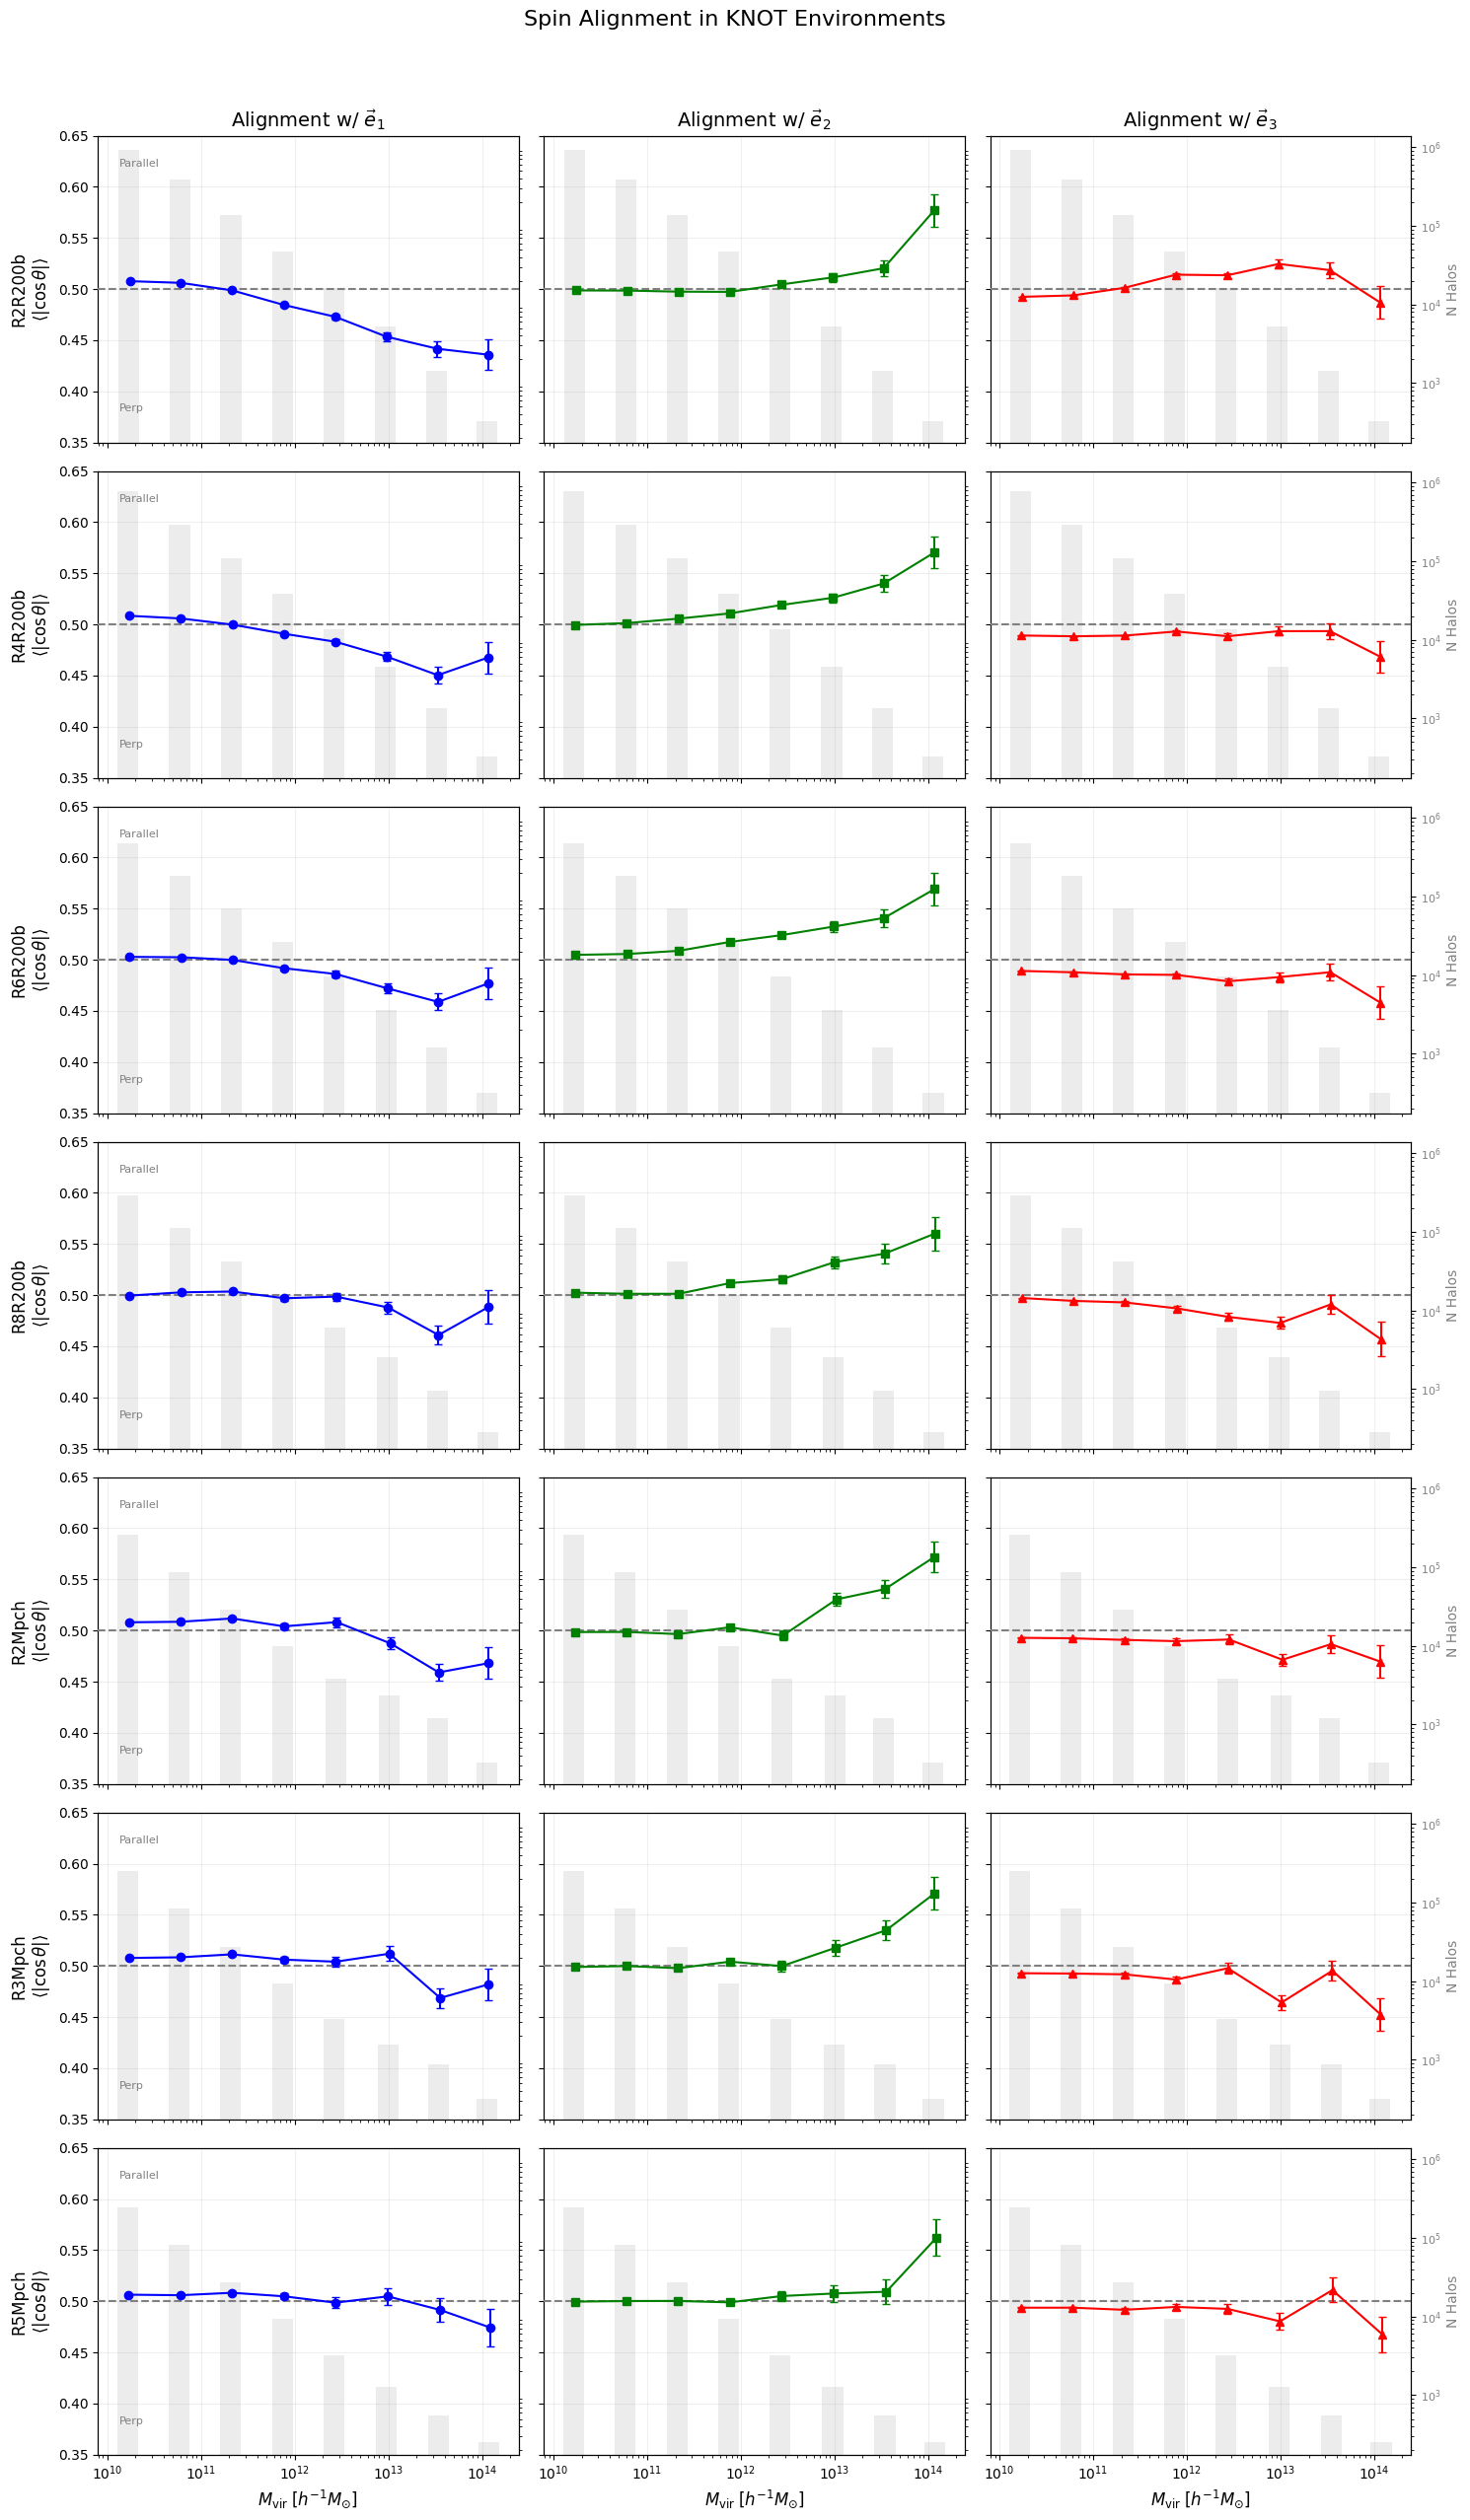

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

def get_knot_stats_no_copy(df, suffix, mass_mask, mbin_array, threshold=0):
    """
    Calculates alignment statistics for KNOTS using the original dataframe.
    Knot Definition: lambda1 > 0 (Collapse in all 3 directions).
    """
    col_check = f'tens11{suffix}'
    if col_check not in df.columns:
        return None

    # 1. Extract Tensor Components
    t11 = df.loc[mass_mask, f'tens11{suffix}'].values
    t22 = df.loc[mass_mask, f'tens22{suffix}'].values
    t33 = df.loc[mass_mask, f'tens33{suffix}'].values
    t12 = df.loc[mass_mask, f'tens12{suffix}'].values
    t13 = df.loc[mass_mask, f'tens13{suffix}'].values
    t23 = df.loc[mass_mask, f'tens23{suffix}'].values

    N = len(t11)
    T_matrices = np.empty((N, 3, 3))
    T_matrices[:, 0, 0] = t11; T_matrices[:, 1, 1] = t22; T_matrices[:, 2, 2] = t33
    T_matrices[:, 0, 1] = t12; T_matrices[:, 1, 0] = t12
    T_matrices[:, 0, 2] = t13; T_matrices[:, 2, 0] = t13
    T_matrices[:, 1, 2] = t23; T_matrices[:, 2, 1] = t23

    # 2. Diagonalize
    evals, evecs = np.linalg.eigh(T_matrices)

    # 3. Filter for KNOTS
    # Condition: All 3 positive.
    # Sorted evals: lambda1 < lambda2 < lambda3
    # If lambda1 > threshold, then ALL are > threshold.
    is_knot = (evals[:, 0] > threshold)

    n_knot = np.sum(is_knot)
    if n_knot == 0:
        return None

    # 4. Extract Spin and Mass
    spin_subset = df.loc[mass_mask, ['jx_u', 'jy_u', 'jz_u']].values
    spin_final = spin_subset[is_knot]
    evecs_final = evecs[is_knot]

    # 5. Calculate Alignments
    mu_1 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 0]))
    mu_2 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 1]))
    mu_3 = np.abs(np.einsum('ij,ij->i', spin_final, evecs_final[:, :, 2]))

    # 6. Retrieve Bin info
    mbin_final = mbin_array[is_knot]
    mass_final = df.loc[mass_mask, 'Mvir'].values[is_knot].astype(float)
    logM_final = np.log10(mass_final)

    stats_df = pd.DataFrame({
        'logMvir': logM_final,
        'mbin': mbin_final,
        'mu_1': mu_1,
        'mu_2': mu_2,
        'mu_3': mu_3
    })

    return stats_df, n_knot

def plot_knot_only_fixed_scales(df, min_n=50):
    scales = ['_R2R200b', '_R4R200b', '_R6R200b', '_R8R200b',
              '_R2Mpch', '_R3Mpch', '_R5Mpch']

    print("--- Pre-processing for KNOTS ---")
    mass_mask = (df['Mvir'].astype(float) > 1e10).values
    print(f"Halos with M > 1e10: {np.sum(mass_mask)}")

    valid_mass = df.loc[mass_mask, 'Mvir'].astype(float).values
    logM = np.log10(valid_mass)

    # Define Bins
    edges = np.linspace(logM.min(), logM.max(), 10)
    mbin_array = pd.cut(logM, bins=edges, labels=False, include_lowest=True)

    sem = lambda x: x.std() / np.sqrt(x.count())

    # --- STEP 1: PRE-CALCULATE STATS TO FIND GLOBAL MAX/MIN COUNTS ---
    all_stats = []
    global_min_count = 1e9
    global_max_count = 0

    print("Gathering statistics across all scales...")
    for scale in scales:
        result = get_knot_stats_no_copy(df, scale, mass_mask, mbin_array)

        if result is None:
            all_stats.append(None)
            continue

        df_knot, n_knot = result

        grouped = df_knot.groupby('mbin')
        stats = grouped.agg({
            'logMvir': 'mean',
            'mu_1': ['mean', sem, 'count'],
            'mu_2': ['mean', sem],
            'mu_3': ['mean', sem]
        })

        stats.columns = ['logM_mean', 'mu1_mean', 'mu1_err', 'count',
                         'mu2_mean', 'mu2_err', 'mu3_mean', 'mu3_err']
        stats['mass'] = 10 ** stats['logM_mean']

        # Filter low counts
        stats = stats[stats['count'] >= min_n]

        all_stats.append(stats)

        # Update global limits
        if not stats.empty:
            current_min = stats['count'].min()
            current_max = stats['count'].max()
            if current_min < global_min_count: global_min_count = current_min
            if current_max > global_max_count: global_max_count = current_max

    # Pad limits for log plot
    count_ylim = [global_min_count * 0.7, global_max_count * 1.5]
    print(f"Global Count Range: {global_min_count} - {global_max_count}")
    print(f"Setting Plot Limits to: {count_ylim}")

    # --- STEP 2: PLOTTING ---
    fig, axes = plt.subplots(7, 3, figsize=(15, 25), sharex=True, sharey=True)

    for i, scale in enumerate(scales):
        stats = all_stats[i]

        if stats is None or stats.empty:
            continue

        # --- Define Axes ---
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]
        ax3 = axes[i, 2]

        # --- Plot Background Counts (FIXED Y-LIM) ---
        for ax_curr in [ax1, ax2, ax3]:
            ax_cnt = ax_curr.twinx()

            # Bars
            ax_cnt.bar(stats['mass'], stats['count'], width=stats['mass']*0.5,
                       color='gray', alpha=0.15, zorder=0)

            ax_cnt.set_yscale('log')
            ax_cnt.set_ylim(count_ylim)  # Fixed Scale
            ax_cnt.grid(False)

            if ax_curr == ax3:
                ax_cnt.set_ylabel('N Halos', color='gray', fontsize=10)
                ax_cnt.tick_params(axis='y', labelcolor='gray', labelsize=8)
            else:
                ax_cnt.set_yticks([])

        # --- Plot Alignment Signal ---
        # Col 1: e1 (Slowest Collapse)
        ax1.errorbar(stats['mass'], stats['mu1_mean'], yerr=stats['mu1_err'],
                     fmt='-o', color='blue', capsize=3, zorder=10)
        ax1.axhline(0.5, color='gray', linestyle='--', zorder=5)
        ax1.set_ylabel(f'{scale.strip("_")}\n' + r'$\langle |\cos \theta| \rangle$', fontsize=12)

        # Col 2: e2 (Intermediate Collapse)
        ax2.errorbar(stats['mass'], stats['mu2_mean'], yerr=stats['mu2_err'],
                     fmt='-s', color='green', capsize=3, zorder=10)
        ax2.axhline(0.5, color='gray', linestyle='--', zorder=5)

        # Col 3: e3 (Fastest Collapse)
        ax3.errorbar(stats['mass'], stats['mu3_mean'], yerr=stats['mu3_err'],
                     fmt='-^', color='red', capsize=3, zorder=10)
        ax3.axhline(0.5, color='gray', linestyle='--', zorder=5)

        # Set consistent Alignment Limits
        ax1.set_ylim(0.35, 0.65)

        # Titles
        if i == 0:
            ax1.set_title(r'Alignment w/ $\vec{e}_1$', fontsize=14)
            ax2.set_title(r'Alignment w/ $\vec{e}_2$', fontsize=14)
            ax3.set_title(r'Alignment w/ $\vec{e}_3$', fontsize=14)

        ax1.text(0.05, 0.9, 'Parallel', transform=ax1.transAxes, fontsize=8, color='gray')
        ax1.text(0.05, 0.1, 'Perp', transform=ax1.transAxes, fontsize=8, color='gray')

    # Formatting
    for ax in axes.flatten():
        ax.set_xscale('log')
        ax.grid(True, alpha=0.2)
        ax.set_zorder(1)
        ax.patch.set_visible(False)

    for ax in axes[-1, :]:
        ax.set_xlabel(r'$M_{\rm vir} \; [h^{-1} M_{\odot}]$', fontsize=12)

    plt.suptitle('Spin Alignment in KNOT Environments', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    del valid_mass, logM, mbin_array, mass_mask
    gc.collect()

# --- Run ---
plot_knot_only_fixed_scales(df, min_n=50)

--- RUNNING SHUFFLED CONTROL: KNOTS (Standard Style) ---
Scale _R2R200b: 1521315 Knots (Shuffled)
Scale _R4R200b: 1242590 Knots (Shuffled)
Scale _R6R200b: 765775 Knots (Shuffled)
Scale _R8R200b: 468231 Knots (Shuffled)
Scale _R2Mpch: 394449 Knots (Shuffled)
Scale _R3Mpch: 377173 Knots (Shuffled)
Scale _R5Mpch: 372178 Knots (Shuffled)


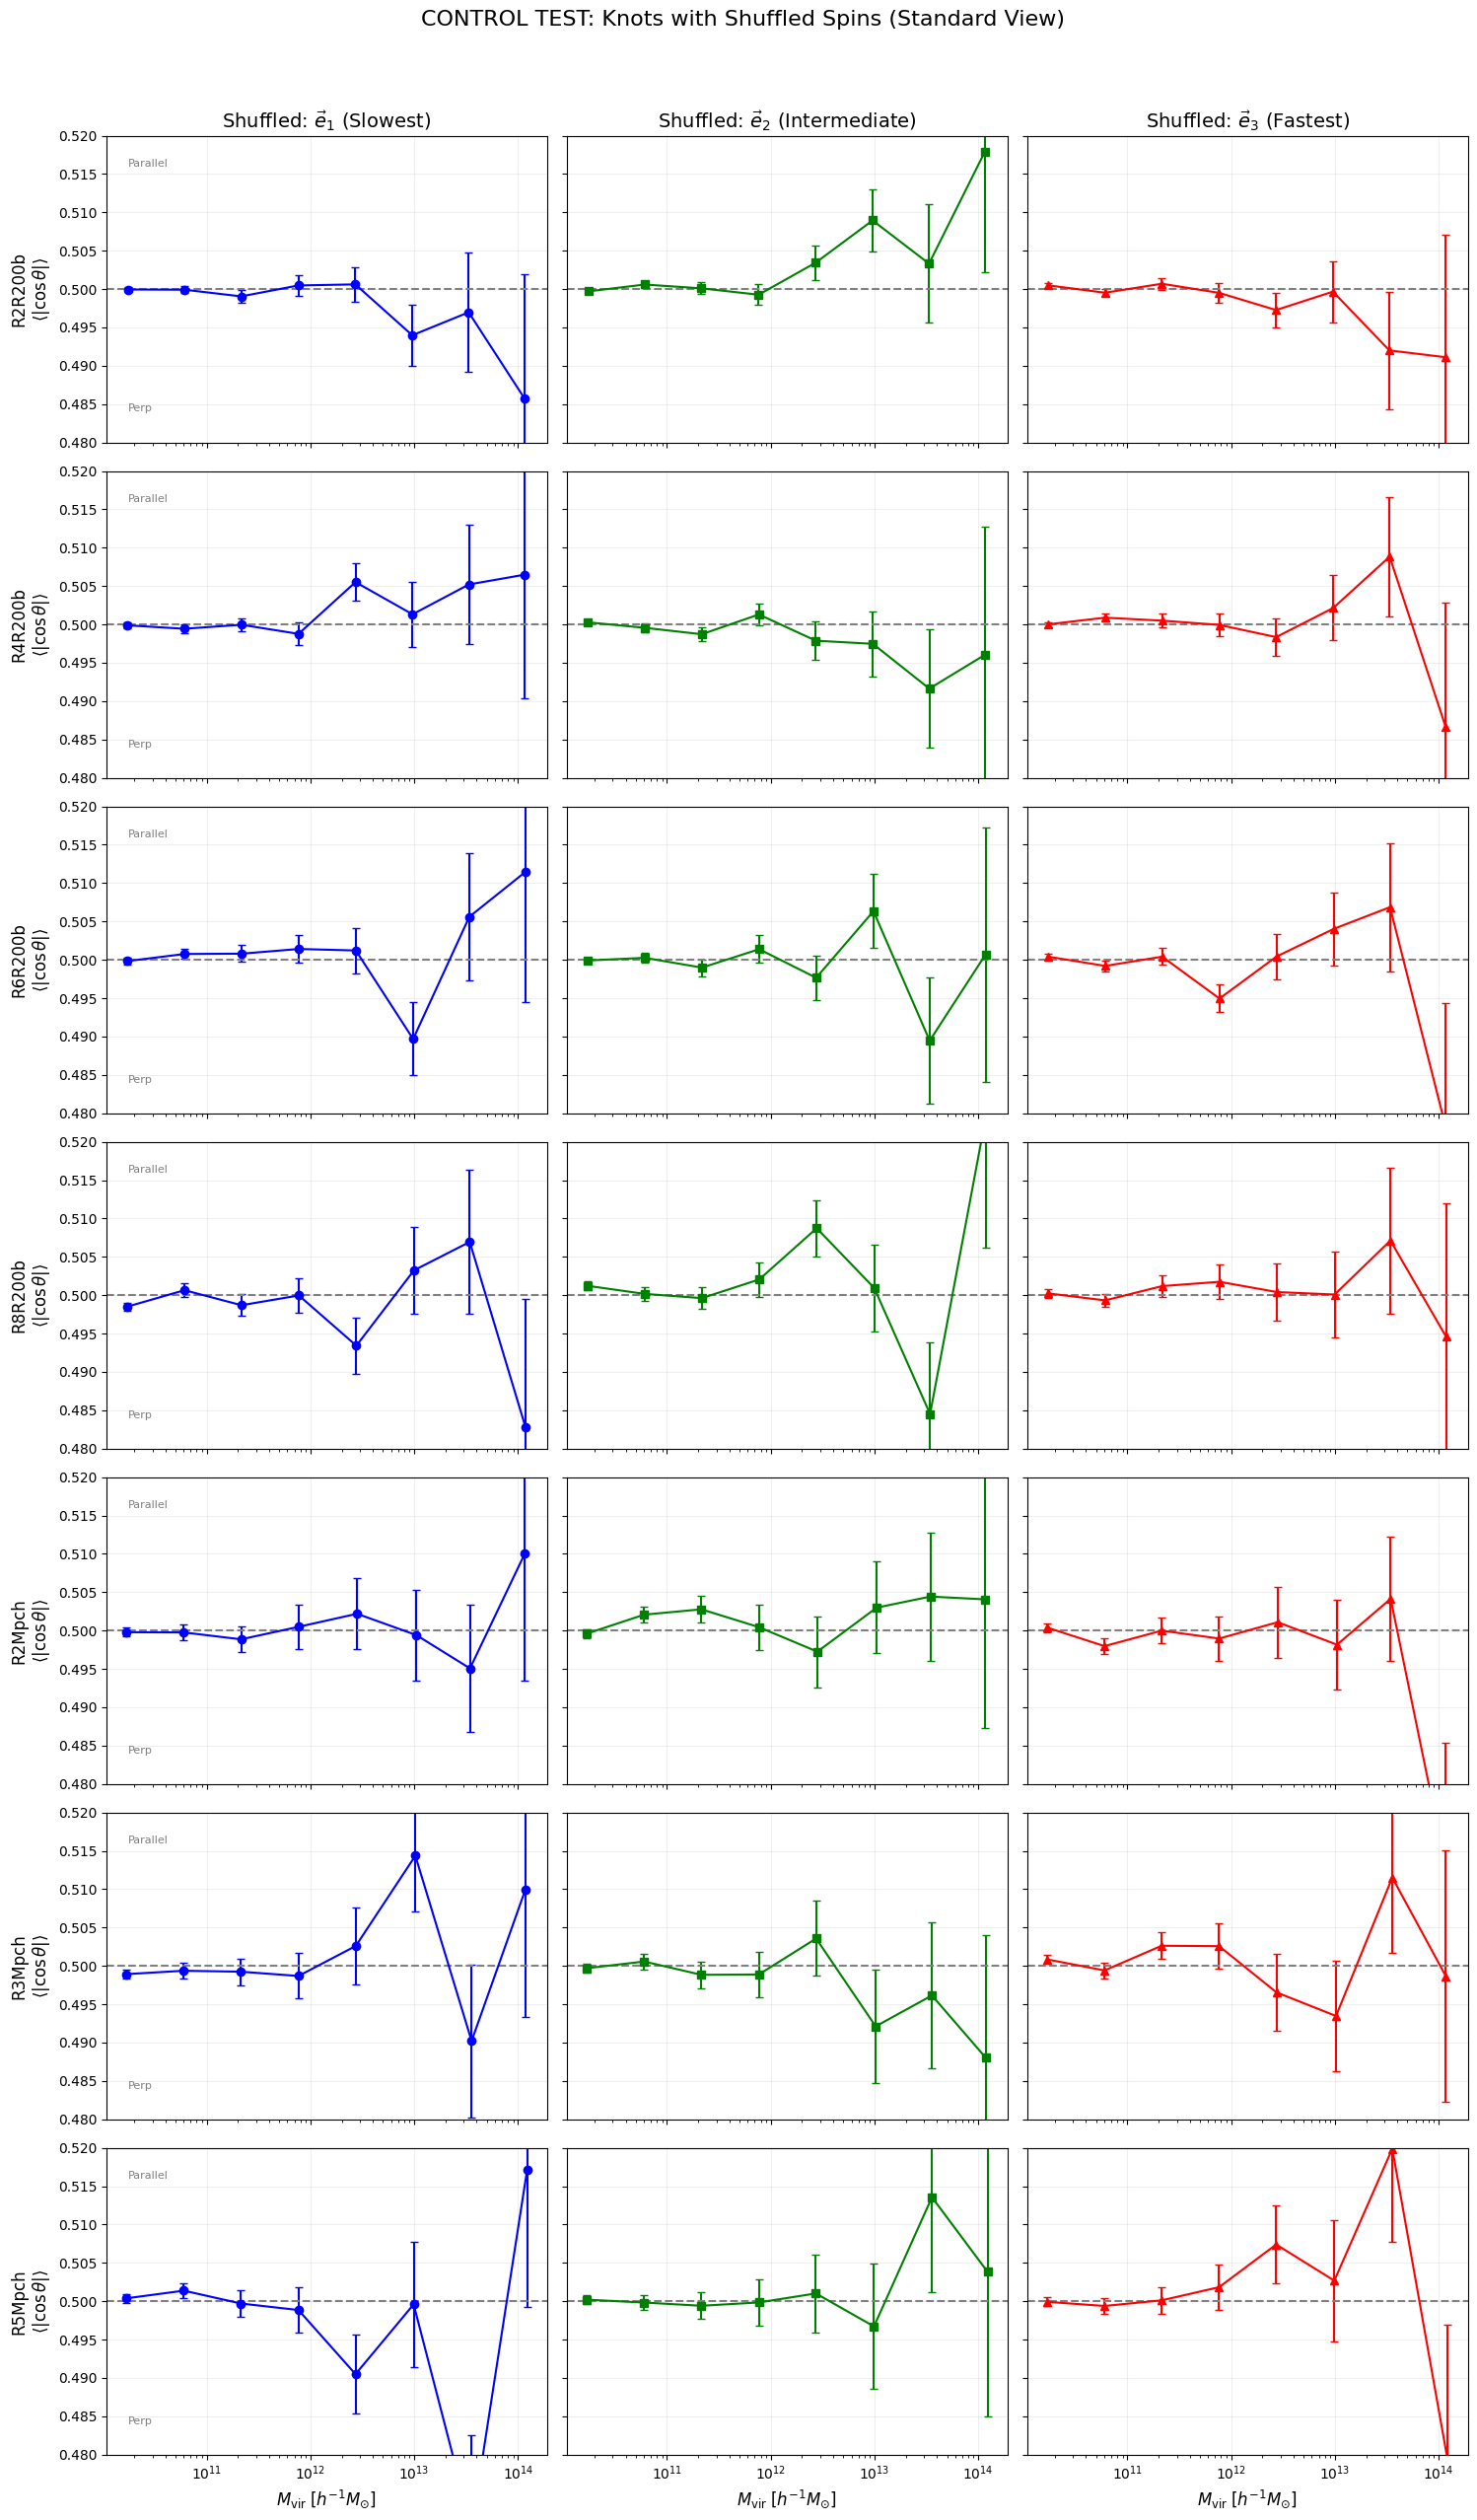

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

def get_knot_stats_shuffled(df, suffix, mass_mask, mbin_array, threshold=0):
    """
    Calculates alignment statistics for KNOTS using SHUFFLED SPINS.
    Logic:
      1. Filter for Knots.
      2. Extract Spins for those Knots.
      3. SHUFFLE the spins randomly among the Knots.
      4. Calculate alignment with original Eigenvectors.
    """
    col_check = f'tens11{suffix}'
    if col_check not in df.columns:
        return None

    # 1. Extract Tensor Components
    t11 = df.loc[mass_mask, f'tens11{suffix}'].values
    t22 = df.loc[mass_mask, f'tens22{suffix}'].values
    t33 = df.loc[mass_mask, f'tens33{suffix}'].values
    t12 = df.loc[mass_mask, f'tens12{suffix}'].values
    t13 = df.loc[mass_mask, f'tens13{suffix}'].values
    t23 = df.loc[mass_mask, f'tens23{suffix}'].values

    N = len(t11)
    T_matrices = np.empty((N, 3, 3))
    T_matrices[:, 0, 0] = t11; T_matrices[:, 1, 1] = t22; T_matrices[:, 2, 2] = t33
    T_matrices[:, 0, 1] = t12; T_matrices[:, 1, 0] = t12
    T_matrices[:, 0, 2] = t13; T_matrices[:, 2, 0] = t13
    T_matrices[:, 1, 2] = t23; T_matrices[:, 2, 1] = t23

    # 2. Diagonalize
    evals, evecs = np.linalg.eigh(T_matrices)

    # 3. Filter for KNOTS (lambda1 > 0 => All positive)
    is_knot = (evals[:, 0] > threshold)

    n_knot = np.sum(is_knot)
    if n_knot == 0:
        return None

    # 4. Extract Spin and Shuffle
    spin_subset = df.loc[mass_mask, ['jx_u', 'jy_u', 'jz_u']].values
    spin_knots = spin_subset[is_knot].copy() # Important: Copy before shuffling

    # --- SHUFFLE STEP ---
    np.random.shuffle(spin_knots)

    # Get Real Eigenvectors
    evecs_final = evecs[is_knot]

    # 5. Calculate Alignments (Shuffled Spins vs Real E-vectors)
    mu_1 = np.abs(np.einsum('ij,ij->i', spin_knots, evecs_final[:, :, 0]))
    mu_2 = np.abs(np.einsum('ij,ij->i', spin_knots, evecs_final[:, :, 1]))
    mu_3 = np.abs(np.einsum('ij,ij->i', spin_knots, evecs_final[:, :, 2]))

    # 6. Retrieve Bin info
    mbin_final = mbin_array[is_knot]
    mass_final = df.loc[mass_mask, 'Mvir'].values[is_knot].astype(float)
    logM_final = np.log10(mass_final)

    stats_df = pd.DataFrame({
        'logMvir': logM_final,
        'mbin': mbin_final,
        'mu_1': mu_1,
        'mu_2': mu_2,
        'mu_3': mu_3
    })

    return stats_df, n_knot

def plot_knot_shuffled_standard_style(df, min_n=50):
    scales = ['_R2R200b', '_R4R200b', '_R6R200b', '_R8R200b',
              '_R2Mpch', '_R3Mpch', '_R5Mpch']

    print("--- RUNNING SHUFFLED CONTROL: KNOTS (Standard Style) ---")

    # 1. Global Mass Mask
    mass_mask = (df['Mvir'].astype(float) > 1e10).values

    # 2. Equal Width Bins (9 Bins)
    valid_mass = df.loc[mass_mask, 'Mvir'].astype(float).values
    logM = np.log10(valid_mass)

    log_min = logM.min()
    log_max = logM.max()
    edges = np.linspace(log_min, log_max, 10) # 9 bins

    mbin_array = pd.cut(logM, bins=edges, labels=False, include_lowest=True)

    sem = lambda x: x.std() / np.sqrt(x.count())

    fig, axes = plt.subplots(7, 3, figsize=(15, 25), sharex=True, sharey=True)

    for i, scale in enumerate(scales):
        # Call the SHUFFLED function
        result = get_knot_stats_shuffled(df, scale, mass_mask, mbin_array)

        if result is None:
            print(f"Scale {scale}: No knots found.")
            continue

        df_knot, n_knot = result
        print(f"Scale {scale}: {n_knot} Knots (Shuffled)")

        grouped = df_knot.groupby('mbin')
        stats = grouped.agg({
            'logMvir': 'mean',
            'mu_1': ['mean', sem, 'count'],
            'mu_2': ['mean', sem],
            'mu_3': ['mean', sem]
        })

        stats.columns = ['logM_mean', 'mu1_mean', 'mu1_err', 'count',
                         'mu2_mean', 'mu2_err', 'mu3_mean', 'mu3_err']
        stats['mass'] = 10 ** stats['logM_mean']

        # Filter low counts
        stats = stats[stats['count'] >= min_n]

        # --- Plotting (Standard Blue/Green/Red Style) ---

        # Col 1: e1 (Slowest Collapse)
        ax1 = axes[i, 0]
        ax1.errorbar(stats['mass'], stats['mu1_mean'], yerr=stats['mu1_err'],
                     fmt='-o', color='blue', capsize=3, label='Shuffled')
        ax1.axhline(0.5, color='gray', linestyle='--')
        ax1.set_ylabel(f'{scale.strip("_")}\n' + r'$\langle |\cos \theta| \rangle$', fontsize=12)

        # Col 2: e2 (Intermediate Collapse)
        ax2 = axes[i, 1]
        ax2.errorbar(stats['mass'], stats['mu2_mean'], yerr=stats['mu2_err'],
                     fmt='-s', color='green', capsize=3, label='Shuffled')
        ax2.axhline(0.5, color='gray', linestyle='--')

        # Col 3: e3 (Fastest Collapse)
        ax3 = axes[i, 2]
        ax3.errorbar(stats['mass'], stats['mu3_mean'], yerr=stats['mu3_err'],
                     fmt='-^', color='red', capsize=3, label='Shuffled')
        ax3.axhline(0.5, color='gray', linestyle='--')

        # Titles (Only top row)
        if i == 0:
            ax1.set_title(r'Shuffled: $\vec{e}_1$ (Slowest)', fontsize=14)
            ax2.set_title(r'Shuffled: $\vec{e}_2$ (Intermediate)', fontsize=14)
            ax3.set_title(r'Shuffled: $\vec{e}_3$ (Fastest)', fontsize=14)

        # Text Guides
        ax1.text(0.05, 0.9, 'Parallel', transform=ax1.transAxes, fontsize=8, color='gray')
        ax1.text(0.05, 0.1, 'Perp', transform=ax1.transAxes, fontsize=8, color='gray')

    # Formatting
    for ax in axes.flatten():
        ax.set_xscale('log')
        ax.grid(True, alpha=0.2)
        # Force y-axis to be centered around 0.5 for clearer view of deviations
        ax.set_ylim(0.48, 0.52)

    for ax in axes[-1, :]:
        ax.set_xlabel(r'$M_{\rm vir} \; [h^{-1} M_{\odot}]$', fontsize=12)

    plt.suptitle('CONTROL TEST: Knots with Shuffled Spins (Standard View)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    del valid_mass, logM, mbin_array, mass_mask
    gc.collect()

# --- Run ---
plot_knot_shuffled_standard_style(df, min_n=50)

--- Probing Filament Physics (Robustness Test) for _R4R200b ---
Analyzing 107906 High-Mass Filament Halos


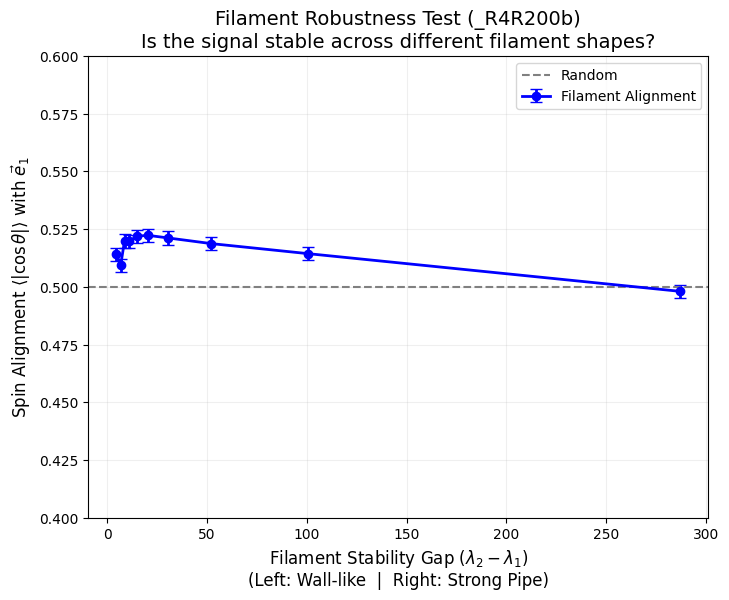

Slope (Last bin - First bin): -0.0160
CONCLUSION: The curve is Flat. The Filament signal is ROBUST.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

def plot_filament_robustness(df, suffix='_R4R200b', min_n=50):
    print(f"--- Probing Filament Physics (Robustness Test) for {suffix} ---")

    # 1. Setup Data & Tensor
    # We want to look at the "Flip" population, so we focus on Higher Mass
    # Let's define "High Mass" as the top 50% of the mass range to capture the flip
    mass_mask = (df['Mvir'].astype(float) > 1e11).values # Focus on galaxy/group scale

    # Extract Tensor
    t11 = df.loc[mass_mask, f'tens11{suffix}'].values
    t22 = df.loc[mass_mask, f'tens22{suffix}'].values
    t33 = df.loc[mass_mask, f'tens33{suffix}'].values
    t12 = df.loc[mass_mask, f'tens12{suffix}'].values
    t13 = df.loc[mass_mask, f'tens13{suffix}'].values
    t23 = df.loc[mass_mask, f'tens23{suffix}'].values

    N = len(t11)
    T = np.empty((N, 3, 3))
    T[:,0,0]=t11; T[:,1,1]=t22; T[:,2,2]=t33
    T[:,0,1]=t12; T[:,1,0]=t12; T[:,0,2]=t13; T[:,2,0]=t13; T[:,1,2]=t23; T[:,2,1]=t23

    evals, evecs = np.linalg.eigh(T)

    # 2. Filter for FILAMENTS
    # lambda1 <= 0, lambda2 > 0
    is_filament = (evals[:, 1] > 0) & (evals[:, 0] <= 0)
    n_fil = np.sum(is_filament)
    print(f"Analyzing {n_fil} High-Mass Filament Halos")

    if n_fil == 0: return

    # 3. Calculate "Stability Metric" (Anisotropy)
    # The Gap: How distinct is the flow axis (e1) from the collapse axis (e2)?
    # Large Gap = Very defined filament. Small Gap = "Wall-like" filament.
    eigen_gap = evals[is_filament, 1] - evals[is_filament, 0]

    # Extract Alignments
    spin_subset = df.loc[mass_mask, ['jx_u', 'jy_u', 'jz_u']].values
    spin_fil = spin_subset[is_filament]
    evecs_fil = evecs[is_filament]

    # Alignment with e1 (The Flow Axis)
    mu_1 = np.abs(np.einsum('ij,ij->i', spin_fil, evecs_fil[:, :, 0]))

    # 4. Binning by ANISOTROPY (Stability)
    # We use qcut to get equal number of halos in each stability bin
    n_bins = 10
    stability_bins = pd.qcut(eigen_gap, q=n_bins, labels=False)

    # Create DF for plotting
    df_plot = pd.DataFrame({
        'gap': eigen_gap,
        'bin': stability_bins,
        'mu_1': mu_1
    })

    # 5. Aggregate and Plot
    grouped = df_plot.groupby('bin')
    stats = grouped.agg({
        'gap': 'mean',
        'mu_1': ['mean', 'std', 'count'] # using std for error bars or SEM
    })

    # Calculate SEM manually for cleaner code
    stats.columns = ['gap_mean', 'mu1_mean', 'mu1_std', 'count']
    stats['mu1_err'] = stats['mu1_std'] / np.sqrt(stats['count'])

    # PLOTTING
    plt.figure(figsize=(8, 6))

    # The Signal:
    plt.errorbar(stats['gap_mean'], stats['mu1_mean'], yerr=stats['mu1_err'],
                 fmt='-o', color='blue', capsize=4, linewidth=2, label='Filament Alignment')

    plt.axhline(0.5, color='gray', linestyle='--', label='Random')

    plt.title(f'Filament Robustness Test ({suffix})\nIs the signal stable across different filament shapes?', fontsize=14)
    plt.xlabel(r'Filament Stability Gap $(\lambda_2 - \lambda_1)$' + '\n(Left: Wall-like  |  Right: Strong Pipe)', fontsize=12)
    plt.ylabel(r'Spin Alignment $\langle |\cos \theta| \rangle$ with $\vec{e}_1$', fontsize=12)
    plt.ylim(0.4, 0.6) # Focus on the deviation from 0.5
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

    # Insight print
    slope = stats['mu1_mean'].iloc[-1] - stats['mu1_mean'].iloc[0]
    print(f"Slope (Last bin - First bin): {slope:.4f}")
    if abs(slope) < 0.05:
        print("CONCLUSION: The curve is Flat. The Filament signal is ROBUST.")
    else:
        print("CONCLUSION: The curve shows dependency. The signal varies with shape.")

# Run
plot_filament_robustness(df, suffix='_R4R200b')

--- Probing Knot Physics (Scrambling Test) for _R4R200b ---
Analyzing 3691 High-Mass Knot Halos


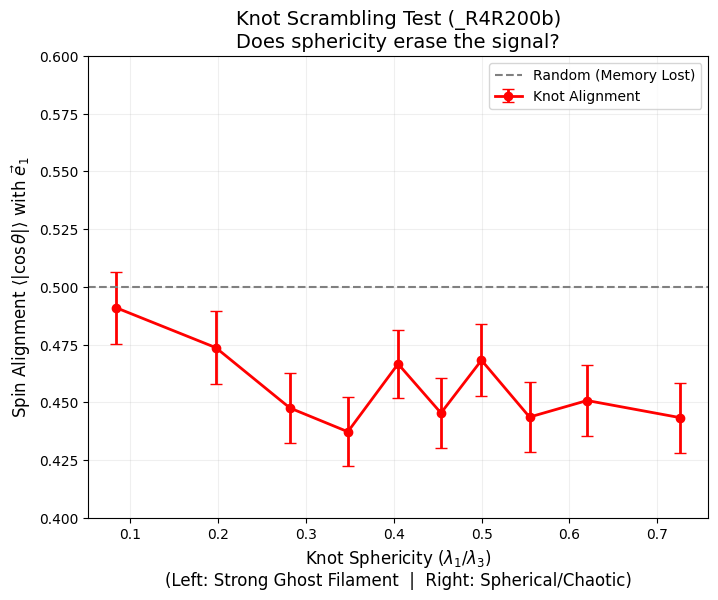

Signal Strength (Anisotropic): 0.0091
Signal Strength (Spherical):   0.0566
CONCLUSION: The signal persists. Physics is very robust.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

def plot_knot_scrambling(df, suffix='_R4R200b', min_n=50):
    print(f"--- Probing Knot Physics (Scrambling Test) for {suffix} ---")

    # 1. Setup Data
    # Focus on High Mass Halos where the "Flip" is strongest
    # We take halos > 10^12 (or whatever threshold shows the flip in your data)
    # Adjust this cut based on your previous plots to isolate the "perpendicular" population
    mass_mask = (df['Mvir'].astype(float) > 1e13).values

    # Extract Tensor
    t11 = df.loc[mass_mask, f'tens11{suffix}'].values
    t22 = df.loc[mass_mask, f'tens22{suffix}'].values
    t33 = df.loc[mass_mask, f'tens33{suffix}'].values
    t12 = df.loc[mass_mask, f'tens12{suffix}'].values
    t13 = df.loc[mass_mask, f'tens13{suffix}'].values
    t23 = df.loc[mass_mask, f'tens23{suffix}'].values

    N = len(t11)
    T = np.empty((N, 3, 3))
    T[:,0,0]=t11; T[:,1,1]=t22; T[:,2,2]=t33
    T[:,0,1]=t12; T[:,1,0]=t12; T[:,0,2]=t13; T[:,2,0]=t13; T[:,1,2]=t23; T[:,2,1]=t23

    evals, evecs = np.linalg.eigh(T)

    # 2. Filter for KNOTS
    # All eigenvalues > 0
    is_knot = (evals[:, 0] > 0)
    n_knot = np.sum(is_knot)
    print(f"Analyzing {n_knot} High-Mass Knot Halos")

    if n_knot < min_n: return

    # 3. Calculate "Sphericity" Metric
    # Ratio of Slowest Collapse (lambda1) to Fastest Collapse (lambda3)
    # Low Value (0.1) = Pancake/Cigar (Strong Anisotropy)
    # High Value (0.9) = Sphere (Isotropic Collapse)
    # Note: evals are sorted, so col 0 is lambda1, col 2 is lambda3
    lambda1 = evals[is_knot, 0]
    lambda3 = evals[is_knot, 2]

    # Avoid division by zero
    sphericity = lambda1 / (lambda3 + 1e-9)

    # Extract Alignments
    spin_subset = df.loc[mass_mask, ['jx_u', 'jy_u', 'jz_u']].values
    spin_knot = spin_subset[is_knot]
    evecs_knot = evecs[is_knot]

    # Alignment with e1 (The "Ghost Filament" Axis)
    mu_1 = np.abs(np.einsum('ij,ij->i', spin_knot, evecs_knot[:, :, 0]))

    # 4. Binning by SPHERICITY
    n_bins = 10
    # Use qcut to get equal counts per bin
    sphericity_bins = pd.qcut(sphericity, q=n_bins, labels=False)

    df_plot = pd.DataFrame({
        'sphericity': sphericity,
        'bin': sphericity_bins,
        'mu_1': mu_1
    })

    # 5. Aggregate and Plot
    grouped = df_plot.groupby('bin')
    stats = grouped.agg({
        'sphericity': 'mean',
        'mu_1': ['mean', 'std', 'count']
    })

    stats.columns = ['sphere_mean', 'mu1_mean', 'mu1_std', 'count']
    stats['mu1_err'] = stats['mu1_std'] / np.sqrt(stats['count'])

    # PLOTTING
    plt.figure(figsize=(8, 6))

    plt.errorbar(stats['sphere_mean'], stats['mu1_mean'], yerr=stats['mu1_err'],
                 fmt='-o', color='red', capsize=4, linewidth=2, label='Knot Alignment')

    plt.axhline(0.5, color='gray', linestyle='--', label='Random (Memory Lost)')

    plt.title(f'Knot Scrambling Test ({suffix})\nDoes sphericity erase the signal?', fontsize=14)
    plt.xlabel(r'Knot Sphericity $(\lambda_1 / \lambda_3)$' + '\n(Left: Strong Ghost Filament  |  Right: Spherical/Chaotic)', fontsize=12)
    plt.ylabel(r'Spin Alignment $\langle |\cos \theta| \rangle$ with $\vec{e}_1$', fontsize=12)
    plt.ylim(0.4, 0.6)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

    # Insight
    first_bin = stats['mu1_mean'].iloc[0]
    last_bin = stats['mu1_mean'].iloc[-1]
    print(f"Signal Strength (Anisotropic): {abs(0.5 - first_bin):.4f}")
    print(f"Signal Strength (Spherical):   {abs(0.5 - last_bin):.4f}")

    if abs(0.5 - last_bin) < abs(0.5 - first_bin):
        print("CONCLUSION: The curve moves toward 0.5. Sphericity ERASES the memory.")
    else:
        print("CONCLUSION: The signal persists. Physics is very robust.")

# Run
plot_knot_scrambling(df, suffix='_R4R200b')


   KNOT PHYSICS PROBE: Scrambling Test (_R4R200b)
Analyzing 30119 High-Mass Knot Halos

--- Bin Statistics (KNOTS) ---
Sphericity   Count    Mean Mass    Align(mu1)
---------------------------------------------
0.048       2490     4.31e+12   0.491
0.139       3180     4.57e+12   0.496
0.230       3920     5.09e+12   0.495
0.322       4691     5.70e+12   0.481
0.413       4962     6.86e+12   0.481
0.502       4579     7.91e+12   0.476
0.594       3329     9.88e+12   0.461
0.681       1907     9.71e+12   0.469
0.771       884      1.27e+13   0.460
0.854       177      4.90e+12   0.441
---------------------------------------------


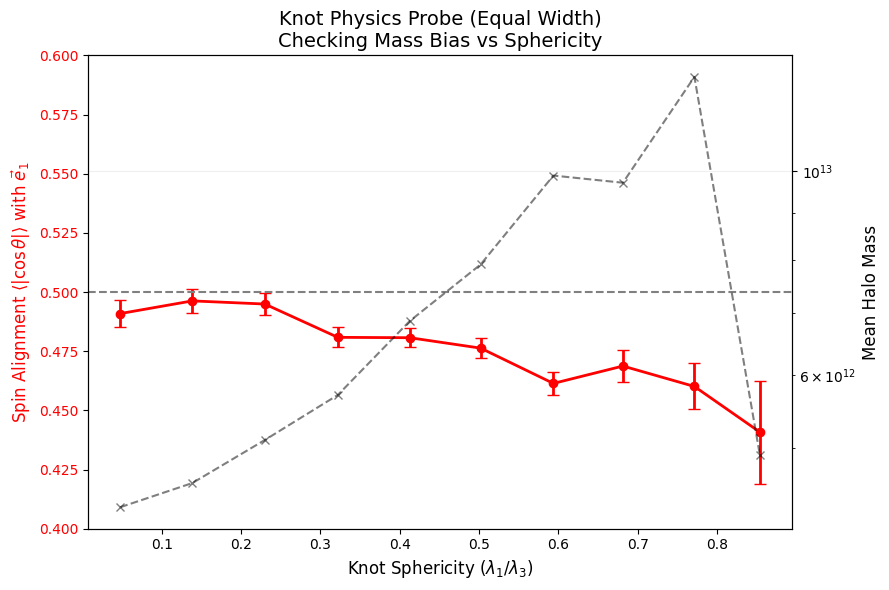

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

def plot_knot_scrambling_equal_width(df, suffix='_R4R200b', min_n=50):
    print(f"\n========================================================")
    print(f"   KNOT PHYSICS PROBE: Scrambling Test ({suffix})")
    print(f"========================================================")

    # 1. Setup Data (High Mass Only)
    mass_mask = (df['Mvir'].astype(float) > 1e12).values

    # Extract Tensor
    t11 = df.loc[mass_mask, f'tens11{suffix}'].values
    t22 = df.loc[mass_mask, f'tens22{suffix}'].values
    t33 = df.loc[mass_mask, f'tens33{suffix}'].values
    t12 = df.loc[mass_mask, f'tens12{suffix}'].values
    t13 = df.loc[mass_mask, f'tens13{suffix}'].values
    t23 = df.loc[mass_mask, f'tens23{suffix}'].values

    N = len(t11)
    T = np.empty((N, 3, 3))
    T[:,0,0]=t11; T[:,1,1]=t22; T[:,2,2]=t33
    T[:,0,1]=t12; T[:,1,0]=t12; T[:,0,2]=t13; T[:,2,0]=t13; T[:,1,2]=t23; T[:,2,1]=t23

    evals, evecs = np.linalg.eigh(T)

    # 2. Filter for KNOTS
    is_knot = (evals[:, 0] > 0)
    n_knot = np.sum(is_knot)
    print(f"Analyzing {n_knot} High-Mass Knot Halos")

    if n_knot < min_n: return

    # 3. Calculate Sphericity
    lambda1 = evals[is_knot, 0]
    lambda3 = evals[is_knot, 2]
    sphericity = lambda1 / (lambda3 + 1e-9)

    # Extract Data
    spin_subset = df.loc[mass_mask, ['jx_u', 'jy_u', 'jz_u']].values
    spin_knot = spin_subset[is_knot]
    evecs_knot = evecs[is_knot]
    mass_knot = df.loc[mass_mask, 'Mvir'].values[is_knot].astype(float)

    mu_1 = np.abs(np.einsum('ij,ij->i', spin_knot, evecs_knot[:, :, 0]))

    # 4. Binning (Equal Width)
    n_bins = 10
    sphericity_bins = pd.cut(sphericity, bins=n_bins, labels=False)

    df_plot = pd.DataFrame({
        'sphericity': sphericity,
        'bin': sphericity_bins,
        'mu_1': mu_1,
        'mass': mass_knot
    })

    # 5. Aggregate
    grouped = df_plot.groupby('bin')
    stats = grouped.agg({
        'sphericity': 'mean',
        'mass': 'mean',
        'mu_1': ['mean', 'std', 'count']
    })

    stats.columns = ['sphere_mean', 'mass_mean', 'mu1_mean', 'mu1_std', 'count']
    stats['mu1_err'] = stats['mu1_std'] / np.sqrt(stats['count'])
    stats = stats[stats['count'] > 10]

    # --- PRINT COUNTS TABLE ---
    print("\n--- Bin Statistics (KNOTS) ---")
    print(f"{'Sphericity':<12} {'Count':<8} {'Mean Mass':<12} {'Align(mu1)':<10}")
    print("-" * 45)
    for index, row in stats.iterrows():
        print(f"{row['sphere_mean']:.3f}       {int(row['count']):<8} {row['mass_mean']:.2e}   {row['mu1_mean']:.3f}")
    print("-" * 45)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(9, 6))

    ax1.errorbar(stats['sphere_mean'], stats['mu1_mean'], yerr=stats['mu1_err'],
                 fmt='-o', color='red', capsize=4, linewidth=2, label='Spin Alignment')
    ax1.axhline(0.5, color='gray', linestyle='--')
    ax1.set_xlabel(r'Knot Sphericity $(\lambda_1 / \lambda_3)$', fontsize=12)
    ax1.set_ylabel(r'Spin Alignment $\langle |\cos \theta| \rangle$ with $\vec{e}_1$', fontsize=12, color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_ylim(0.4, 0.6)

    ax2 = ax1.twinx()
    ax2.plot(stats['sphere_mean'], stats['mass_mean'], '--x', color='black', alpha=0.5, label='Mean Mass')
    ax2.set_ylabel('Mean Halo Mass', fontsize=12, color='black')
    ax2.set_yscale('log')

    plt.title(f'Knot Physics Probe (Equal Width)\nChecking Mass Bias vs Sphericity', fontsize=14)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# Run
plot_knot_scrambling_equal_width(df, suffix='_R4R200b')


   KNOT PHYSICS PROBE: Scrambling Test (_R4R200b)
   (Optimized: Bootstrap Errors + Distribution)
Analyzing 30119 High-Mass Knot Halos

--- Bin Statistics (KNOTS) ---
Sphericity   Count    Mean Mass    Align(mu1)
---------------------------------------------
0.050       2803     4.25e+12   0.490
0.150       3555     4.68e+12   0.499
0.250       4440     5.30e+12   0.492
0.350       5254     5.81e+12   0.480
0.450       5438     7.38e+12   0.478
0.550       4268     8.95e+12   0.469
0.650       2788     9.85e+12   0.470
0.750       1238     1.20e+13   0.452
0.850       323      7.59e+12   0.447
0.950       12       7.57e+12   0.458
---------------------------------------------


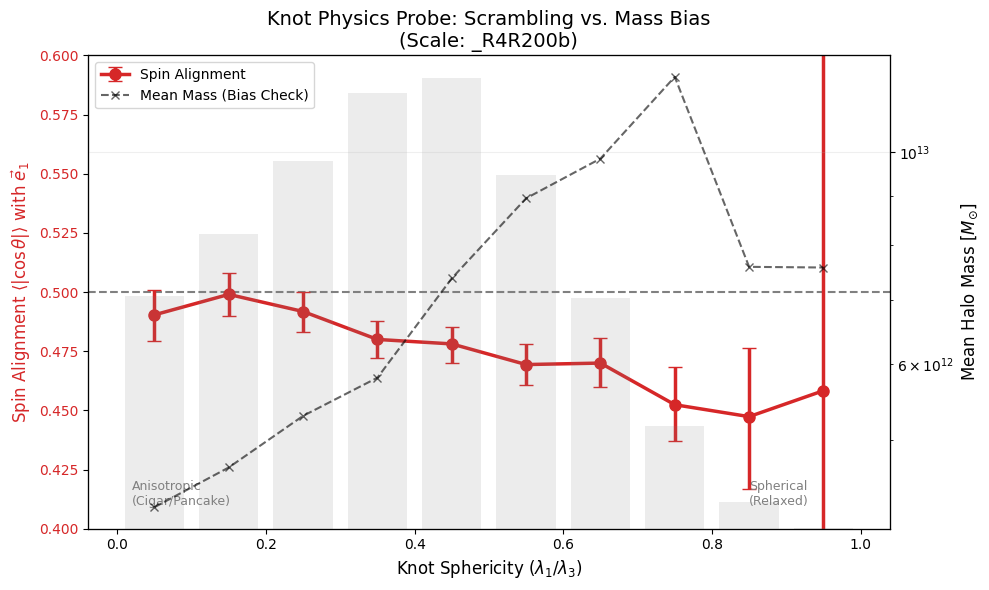

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

def plot_knot_scrambling_optimized(df, suffix='_R4R200b', min_n=50, n_boot=1000):
    print(f"\n========================================================")
    print(f"   KNOT PHYSICS PROBE: Scrambling Test ({suffix})")
    print(f"   (Optimized: Bootstrap Errors + Distribution)")
    print(f"========================================================")

    # 1. Setup Data (High Mass Only - Critical for Signal)
    mass_mask = (df['Mvir'].astype(float) > 1e12).values

    # Extract Tensor
    t11 = df.loc[mass_mask, f'tens11{suffix}'].values
    t22 = df.loc[mass_mask, f'tens22{suffix}'].values
    t33 = df.loc[mass_mask, f'tens33{suffix}'].values
    t12 = df.loc[mass_mask, f'tens12{suffix}'].values
    t13 = df.loc[mass_mask, f'tens13{suffix}'].values
    t23 = df.loc[mass_mask, f'tens23{suffix}'].values

    N = len(t11)
    T = np.empty((N, 3, 3))
    T[:,0,0]=t11; T[:,1,1]=t22; T[:,2,2]=t33
    T[:,0,1]=t12; T[:,1,0]=t12; T[:,0,2]=t13; T[:,2,0]=t13; T[:,1,2]=t23; T[:,2,1]=t23

    evals, evecs = np.linalg.eigh(T)

    # 2. Filter for KNOTS
    is_knot = (evals[:, 0] > 0)
    n_knot = np.sum(is_knot)
    print(f"Analyzing {n_knot} High-Mass Knot Halos")

    if n_knot < min_n: return

    # 3. Calculate Shape Metrics
    # Lambda1 (Slowest Collapse) < Lambda2 < Lambda3 (Fastest Collapse)
    l1 = evals[is_knot, 0]
    l2 = evals[is_knot, 1]
    l3 = evals[is_knot, 2]

    # Sphericity: How round is it? (1 = Sphere, 0 = Needle/Pancake)
    sphericity = l1 / (l3 + 1e-9)

    # Triaxiality: T = (l1^2 - l2^2) / (l1^2 - l3^2)
    # This helps distinguish Cigars (Prolate) from Pancakes (Oblate)
    # But for now, let's stick to your simple metric to avoid over-complicating,
    # just noting that Sphericity is the primary variable.

    # Extract Data
    spin_subset = df.loc[mass_mask, ['jx_u', 'jy_u', 'jz_u']].values
    spin_knot = spin_subset[is_knot]
    evecs_knot = evecs[is_knot]
    mass_knot = df.loc[mass_mask, 'Mvir'].values[is_knot].astype(float)

    # Alignment with e1 ("Ghost Filament" Axis)
    mu_1 = np.abs(np.einsum('ij,ij->i', spin_knot, evecs_knot[:, :, 0]))

    # 4. Binning (Equal Width)
    n_bins = 10
    # Create bin edges explicitly to ensure plotting is clean
    bins = np.linspace(0, 1, n_bins+1)

    df_plot = pd.DataFrame({
        'sphericity': sphericity,
        'mu_1': mu_1,
        'mass': mass_knot
    })

    # Assign bins
    df_plot['bin_idx'] = pd.cut(df_plot['sphericity'], bins=bins, labels=False, include_lowest=True)

    # 5. Bootstrap Aggregation
    # We calculate the mean and 95% CI for each bin
    bin_stats = []

    for b in range(n_bins):
        subset = df_plot[df_plot['bin_idx'] == b]
        count = len(subset)

        if count < 10:
            bin_stats.append(None)
            continue

        # Real Mean
        mean_mu = subset['mu_1'].mean()
        mean_mass = subset['mass'].mean()
        center_bin = (bins[b] + bins[b+1]) / 2

        # Bootstrap Error
        # Resample the subset 1000 times
        boot_means = np.random.choice(subset['mu_1'].values, (n_boot, count), replace=True).mean(axis=1)
        err_low = mean_mu - np.percentile(boot_means, 2.5)
        err_high = np.percentile(boot_means, 97.5) - mean_mu

        bin_stats.append({
            'sphere_val': center_bin,
            'mu1_mean': mean_mu,
            'err_low': err_low,
            'err_high': err_high,
            'mass_mean': mean_mass,
            'count': count
        })

    stats = pd.DataFrame([x for x in bin_stats if x is not None])

    # --- PRINT TABLE ---
    print("\n--- Bin Statistics (KNOTS) ---")
    print(f"{'Sphericity':<12} {'Count':<8} {'Mean Mass':<12} {'Align(mu1)':<10}")
    print("-" * 45)
    for index, row in stats.iterrows():
        print(f"{row['sphere_val']:.3f}       {int(row['count']):<8} {row['mass_mean']:.2e}   {row['mu1_mean']:.3f}")
    print("-" * 45)

    # --- PLOTTING ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 1. Background Histogram (Density)
    # This shows where the data actually lives!
    ax_hist = ax1.twinx()
    ax_hist.bar(stats['sphere_val'], stats['count'], width=0.08, color='gray', alpha=0.15, label='Halo Count')
    ax_hist.set_yticks([]) # Hide y-ticks for histogram to reduce clutter

    # 2. Mass Bias (Right Axis)
    ax2 = ax1.twinx()
    # Move the spine of the second axis outwards so it doesn't overlap
    ax2.spines["right"].set_position(("axes", 1.0))

    line_mass = ax2.plot(stats['sphere_val'], stats['mass_mean'], '--x', color='black', alpha=0.6, label='Mean Mass (Bias Check)')
    ax2.set_ylabel(r'Mean Halo Mass [$M_{\odot}$]', fontsize=12, color='black')
    ax2.set_yscale('log')

    # 3. Alignment Signal (Left Axis - The Star of the Show)
    # Using asymmetric error bars from bootstrap
    errs = [stats['err_low'], stats['err_high']]
    line_align = ax1.errorbar(stats['sphere_val'], stats['mu1_mean'], yerr=errs,
                 fmt='-o', color='#D62728', capsize=5, linewidth=2.5, markersize=8, label='Spin Alignment')

    # Reference Line
    ax1.axhline(0.5, color='gray', linestyle='--', linewidth=1.5, zorder=0)

    # Labels
    ax1.set_xlabel(r'Knot Sphericity $(\lambda_1 / \lambda_3)$', fontsize=12)
    ax1.set_ylabel(r'Spin Alignment $\langle |\cos \theta| \rangle$ with $\vec{e}_1$', fontsize=12, color='#D62728')
    ax1.tick_params(axis='y', labelcolor='#D62728')
    ax1.set_ylim(0.4, 0.6)

    # Combined Legend
    lines = [line_align, line_mass[0]]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=10, frameon=True)

    # Text Annotations for Extremes
    ax1.text(0.02, 0.41, 'Anisotropic\n(Cigar/Pancake)', fontsize=9, color='gray')
    ax1.text(0.85, 0.41, 'Spherical\n(Relaxed)', fontsize=9, color='gray')

    plt.title(f'Knot Physics Probe: Scrambling vs. Mass Bias\n(Scale: {suffix})', fontsize=14)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# Run
plot_knot_scrambling_optimized(df, suffix='_R4R200b')


   FILAMENT PHYSICS PROBE: Robustness Test (_R4R200b)
Analyzing 107906 High-Mass Filament Halos

--- Bin Statistics (FILAMENTS) ---
Gap (l2-l1)  Count    Mean Mass    Align(mu1)
---------------------------------------------
30.127       98952    5.01e+11   0.518
229.623       6114     2.35e+11   0.505
397.427       1817     1.95e+11   0.489
563.377       627      1.72e+11   0.461
727.082       235      1.51e+11   0.496
900.416       87       1.49e+11   0.496
1073.707       44       1.37e+11   0.483
1219.318       18       1.35e+11   0.458
---------------------------------------------


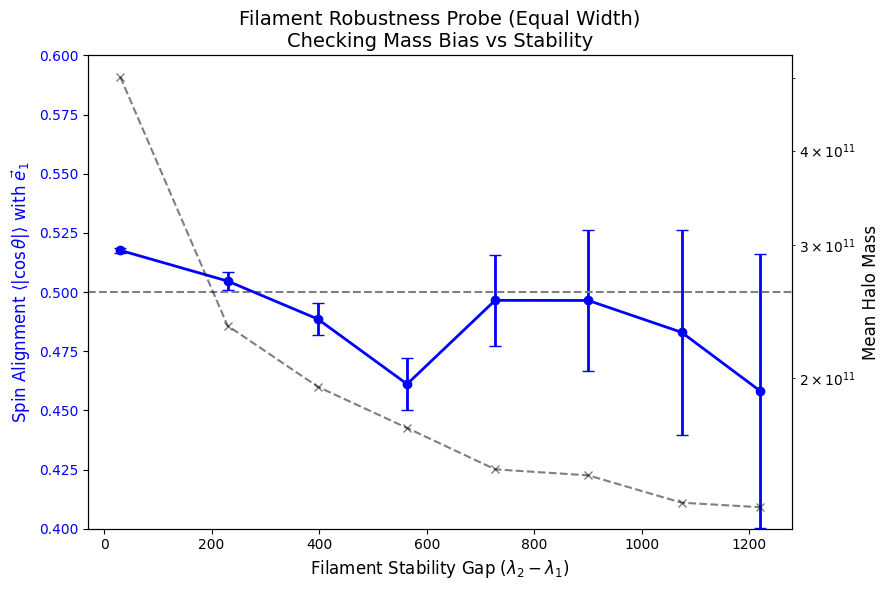

In [ ]:
def plot_filament_robustness_equal_width(df, suffix='_R4R200b', min_n=50):
    print(f"\n========================================================")
    print(f"   FILAMENT PHYSICS PROBE: Robustness Test ({suffix})")
    print(f"========================================================")

    # 1. Setup Data (High Mass Only)
    mass_mask = (df['Mvir'].astype(float) > 1e11).values

    # Extract Tensor
    t11 = df.loc[mass_mask, f'tens11{suffix}'].values
    t22 = df.loc[mass_mask, f'tens22{suffix}'].values
    t33 = df.loc[mass_mask, f'tens33{suffix}'].values
    t12 = df.loc[mass_mask, f'tens12{suffix}'].values
    t13 = df.loc[mass_mask, f'tens13{suffix}'].values
    t23 = df.loc[mass_mask, f'tens23{suffix}'].values

    N = len(t11)
    T = np.empty((N, 3, 3))
    T[:,0,0]=t11; T[:,1,1]=t22; T[:,2,2]=t33
    T[:,0,1]=t12; T[:,1,0]=t12; T[:,0,2]=t13; T[:,2,0]=t13; T[:,1,2]=t23; T[:,2,1]=t23

    evals, evecs = np.linalg.eigh(T)

    # 2. Filter for FILAMENTS
    is_filament = (evals[:, 1] > 0) & (evals[:, 0] <= 0)
    n_fil = np.sum(is_filament)
    print(f"Analyzing {n_fil} High-Mass Filament Halos")

    if n_fil == 0: return

    # 3. Calculate Stability Gap
    eigen_gap = evals[is_filament, 1] - evals[is_filament, 0]

    # Extract Data
    spin_fil = df.loc[mass_mask, ['jx_u', 'jy_u', 'jz_u']].values[is_filament]
    evecs_fil = evecs[is_filament]
    mass_fil = df.loc[mass_mask, 'Mvir'].values[is_filament].astype(float)
    mu_1 = np.abs(np.einsum('ij,ij->i', spin_fil, evecs_fil[:, :, 0]))

    # 4. Binning (Equal Width)
    n_bins = 10
    gap_bins = pd.cut(eigen_gap, bins=n_bins, labels=False)

    df_plot = pd.DataFrame({
        'gap': eigen_gap,
        'bin': gap_bins,
        'mu_1': mu_1,
        'mass': mass_fil
    })

    # 5. Aggregate
    grouped = df_plot.groupby('bin')
    stats = grouped.agg({
        'gap': 'mean',
        'mass': 'mean',
        'mu_1': ['mean', 'std', 'count']
    })

    stats.columns = ['gap_mean', 'mass_mean', 'mu1_mean', 'mu1_std', 'count']
    stats['mu1_err'] = stats['mu1_std'] / np.sqrt(stats['count'])
    stats = stats[stats['count'] > 10]

    # --- PRINT COUNTS TABLE ---
    print("\n--- Bin Statistics (FILAMENTS) ---")
    print(f"{'Gap (l2-l1)':<12} {'Count':<8} {'Mean Mass':<12} {'Align(mu1)':<10}")
    print("-" * 45)
    for index, row in stats.iterrows():
        print(f"{row['gap_mean']:.3f}       {int(row['count']):<8} {row['mass_mean']:.2e}   {row['mu1_mean']:.3f}")
    print("-" * 45)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(9, 6))

    ax1.errorbar(stats['gap_mean'], stats['mu1_mean'], yerr=stats['mu1_err'],
                 fmt='-o', color='blue', capsize=4, linewidth=2, label='Spin Alignment')
    ax1.axhline(0.5, color='gray', linestyle='--')
    ax1.set_xlabel(r'Filament Stability Gap $(\lambda_2 - \lambda_1)$', fontsize=12)
    ax1.set_ylabel(r'Spin Alignment $\langle |\cos \theta| \rangle$ with $\vec{e}_1$', fontsize=12, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(0.4, 0.6)

    ax2 = ax1.twinx()
    ax2.plot(stats['gap_mean'], stats['mass_mean'], '--x', color='black', alpha=0.5, label='Mean Mass')
    ax2.set_ylabel('Mean Halo Mass', fontsize=12, color='black')
    ax2.set_yscale('log')

    plt.title(f'Filament Robustness Probe (Equal Width)\nChecking Mass Bias vs Stability', fontsize=14)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# Run
plot_filament_robustness_equal_width(df, suffix='_R4R200b')